### This notebook implements the MIAE method on the Pavia University Hyperspectral Image

Imports

In [1]:
import numpy as np
import scipy.io as sio
import time
import random
import cv2
import os
from spectral import *
from tqdm import tqdm
import math
import matplotlib.pyplot as plt
from scipy.signal import convolve2d
from scipy.special import gamma, kv, erf

import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as fun
import torch.utils.data as data
import torchsummary
import torchprofile
from fvcore.nn import FlopCountAnalysis, parameter_count_table

In [2]:
# Set device
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# Set random seed for reproducibility
def set_random_seed(seed=42):
    random.seed(seed)
    np.random.seed(seed)
    torch.manual_seed(seed)
    torch.cuda.manual_seed_all(seed)
    torch.backends.cudnn.deterministic = True
    torch.backends.cudnn.benchmark = False

set_random_seed()

Helper Functions

In [3]:
# Defining each PSF

kernel_size = 7
sigma = 3.40

def gaussian_psf(sigma, psf_size):
    """Generate a Gaussian PSF."""
    x = np.linspace(-psf_size, psf_size, 2*psf_size+1)
    y = np.linspace(-psf_size, psf_size, 2*psf_size+1)
    X, Y = np.meshgrid(x, y)
    psf = np.exp(-(X**2 + Y**2) / (2 * sigma**2))
    psf = psf / psf.sum()
    return psf
gaus_psf = gaussian_psf(sigma, kernel_size)

def kolmogorov_psf(sigma, psf_size):
    """Generate a Kolmogorov PSF."""
    x = np.linspace(-psf_size, psf_size, 2*psf_size+1)
    y = np.linspace(-psf_size, psf_size, 2*psf_size+1)
    X, Y = np.meshgrid(x, y)
    r = np.sqrt(X**2 + Y**2)
    psf = np.exp(-(r / sigma)**(5/3))
    psf = psf / psf.sum()
    return psf
kol_psf = kolmogorov_psf(sigma, kernel_size)

def airy_psf(sigma, psf_size):
    """Generate an Airy PSF."""
    x = np.linspace(-psf_size, psf_size, 2*psf_size+1)
    y = np.linspace(-psf_size, psf_size, 2*psf_size+1)
    X, Y = np.meshgrid(x, y)
    r = np.sqrt(X**2 + Y**2)
    z = (2.33811 * r) / sigma
    psf = (2 * kv(1, z) / z)**2
    psf[r == 0] = 1
    psf = psf / psf.sum()
    return psf
air_psf = airy_psf(sigma, kernel_size)

def moffat_psf(sigma, psf_size, beta=3.5):
    """Generate a Moffat PSF."""
    x = np.linspace(-psf_size, psf_size, 2*psf_size+1)
    y = np.linspace(-psf_size, psf_size, 2*psf_size+1)
    X, Y = np.meshgrid(x, y)
    r = np.sqrt(X**2 + Y**2)
    psf = (1 + (r / sigma)**2)**(-beta)
    psf = psf / psf.sum()
    return psf
mof_psf = moffat_psf(sigma, kernel_size)

def sinc_psf(sigma, psf_size):
    """Generate a Sinc PSF."""
    x = np.linspace(-psf_size, psf_size, 2*psf_size+1)
    y = np.linspace(-psf_size, psf_size, 2*psf_size+1)
    X, Y = np.meshgrid(x, y)
    r = np.sqrt(X**2 + Y**2)
    psf = np.sinc(r / sigma)
    psf = psf / psf.sum()
    return psf
sinc_psf = sinc_psf(sigma, kernel_size)

def lorentzian_squared_psf(sigma, psf_size):
    """Generate a Lorentzian Squared PSF."""
    x = np.linspace(-psf_size, psf_size, 2*psf_size+1)
    y = np.linspace(-psf_size, psf_size, 2*psf_size+1)
    X, Y = np.meshgrid(x, y)
    r = np.sqrt(X**2 + Y**2)
    psf = 1 / (1 + (r / sigma)**4)
    psf = psf / psf.sum()
    return psf
lor_sq_psf = lorentzian_squared_psf(sigma, kernel_size)

def hermite_psf(sigma, psf_size, n=1):
    """Generate a Hermite PSF."""
    from numpy.polynomial.hermite import hermval
    x = np.linspace(-psf_size, psf_size, 2*psf_size+1)
    y = np.linspace(-psf_size, psf_size, 2*psf_size+1)
    X, Y = np.meshgrid(x, y)
    r = np.sqrt(X**2 + Y**2)
    psf = np.exp(-r**2 / (2 * sigma**2)) * hermval(r / sigma, [0]*n + [1])
    psf = psf / psf.sum()
    return psf
her_psf = hermite_psf(sigma, kernel_size)

def parabolic_psf(sigma, psf_size):
    """Generate a Parabolic PSF."""
    x = np.linspace(-psf_size, psf_size, 2*psf_size+1)
    y = np.linspace(-psf_size, psf_size, 2*psf_size+1)
    X, Y = np.meshgrid(x, y)
    r = np.sqrt(X**2 + Y**2)
    psf = np.maximum(0, 1 - (r / sigma)**2)
    psf = psf / psf.sum()
    return psf
par_psf = parabolic_psf(sigma, kernel_size)

def gabor_psf(sigma, psf_size, theta=0, lambd=1, gamma=0.5, psi=0):
    """Generate a Gabor PSF."""
    x = np.linspace(-psf_size, psf_size, 2*psf_size+1)
    y = np.linspace(-psf_size, psf_size, 2*psf_size+1)
    X, Y = np.meshgrid(x, y)
    x_theta = X * np.cos(theta) + Y * np.sin(theta)
    y_theta = -X * np.sin(theta) + Y * np.cos(theta)
    psf = np.exp(-0.5 * (x_theta**2 + gamma**2 * y_theta**2) / sigma**2) * np.cos(2 * np.pi * x_theta / lambd + psi)
    psf = psf / psf.sum()
    return psf
gab_psf = gabor_psf(sigma, kernel_size)

def delta_function_psf(sigma, psf_size):
    """Generate a Delta Function PSF."""
    psf = np.zeros((2*psf_size+1, 2*psf_size+1))
    psf[psf_size, psf_size] = 1
    return psf
delta_psf = delta_function_psf(sigma, kernel_size)

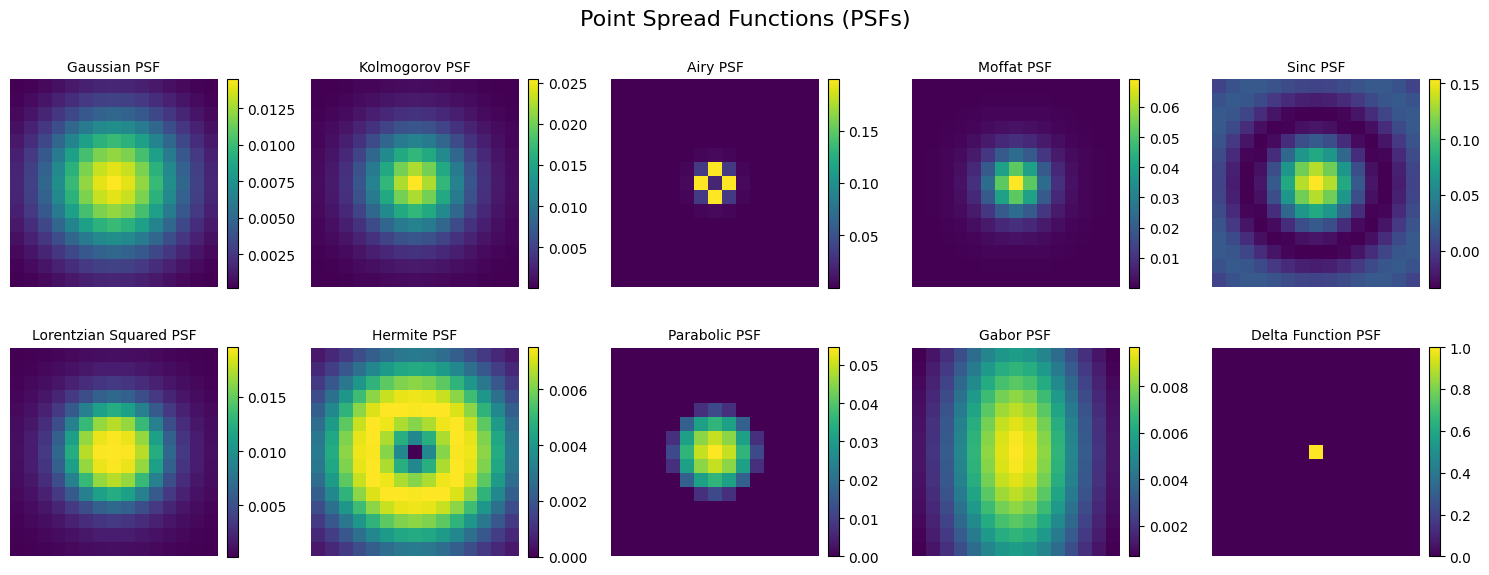

In [4]:
# Visualizing all the PSFs that will be used

psfs = [
    (gaus_psf, "Gaussian PSF"),
    (kol_psf, "Kolmogorov PSF"),
    (air_psf, "Airy PSF"),
    (mof_psf, "Moffat PSF"),
    (sinc_psf, "Sinc PSF"),
    (lor_sq_psf, "Lorentzian Squared PSF"),
    (her_psf, "Hermite PSF"),
    (par_psf, "Parabolic PSF"),
    (gab_psf, "Gabor PSF"),
    (delta_psf, "Delta Function PSF")
]

# Create subplots
fig, axes = plt.subplots(2, 5, figsize=(15, 6))  # 5 columns, 2 rows
fig.suptitle("Point Spread Functions (PSFs)", fontsize=16)

# Plot each PSF
for i, (psf, label) in enumerate(psfs):
    ax = axes[i // 5, i % 5]  # Determine subplot position
    im = ax.imshow(psf, cmap='viridis')
    ax.set_title(label, fontsize=10)
    ax.axis('off')
    plt.colorbar(im, ax=ax, fraction=0.046, pad=0.04)

plt.tight_layout()
plt.show()

In [5]:
# Function to apply PSF to an image
def apply_psf(image, psf):
    
    """
    Convolve each channel of 'image' with 'psf' using 'same' padding.

    Parameters:
    -----------
    image : np.ndarray
        Shape (height, width, channels).
    psf   : np.ndarray
        Shape (kernel_height, kernel_width).
        
    Returns:
    --------
    blurred_image : np.ndarray
        Same shape as input image (height, width, channels).
    """
    
    # Prepare an output array of the same shape as 'image'
    blurred_image = np.zeros_like(image, dtype=np.float32)

    # Convolve each channel separately
    channels = image.shape[2]
    for c in range(channels):
        # convolve2d with mode='same' replicates TensorFlow's 'SAME' padding
        blurred_image[:, :, c] = convolve2d(image[:, :, c], psf, mode='same')
        
    return blurred_image
    
# Function to downsample an image
def downsample_image(image, factor):
    # Ensure the input image is a NumPy array
    if not isinstance(image, np.ndarray):
        image = np.array(image)
    
    # Get the dimensions of the image
    height, width, channels = image.shape
    
    # Initialize a list to hold the downsampled channels
    downsampled_channels = []
    
    # Downsample each channel individually
    for c in range(channels):
        channel = image[:, :, c]
        downsampled_channel = cv2.resize(channel, (width // factor, height // factor), interpolation=cv2.INTER_AREA)
        downsampled_channels.append(downsampled_channel)
    
    # Stack the downsampled channels back together
    downsampled_image = np.stack(downsampled_channels, axis=-1)
    
    return downsampled_image
    
# Function to add noise to an image
def add_awgn_noise(hsi_image, SNR_dB):
    
    """
    Add AWGN (Additive White Gaussian Noise) to the input hsi_image,
    given a desired SNR in dB. Uses NumPy only.

    Parameters
    ----------
    hsi_image : np.ndarray
        Input image of shape (rows, cols, channels).
    SNR_dB : float
        Desired SNR in decibels.

    Returns
    -------
    noisy_hsi_image : np.ndarray
        Noisy image of the same shape as hsi_image.
    """

     # Ensure float32
    hsi_image = hsi_image.astype(np.float32)

    rows, cols, channels = hsi_image.shape

    # Compute the signal power for each channel
    # shape: (channels,)
    signal_power = np.mean(hsi_image ** 2, axis=(0, 1))

    # Convert SNR from dB to linear scale
    SNR_linear = 10 ** (SNR_dB / 10.0)

    # Compute noise power and noise standard deviation per channel
    noise_power = signal_power / SNR_linear  # shape: (channels,)
    noise_std = np.sqrt(noise_power)         # shape: (channels,)

    # Reshape for broadcasting across (rows, cols)
    noise_std = noise_std.reshape((1, 1, channels))

    # Generate white Gaussian noise
    noise = np.random.normal(
        loc=0.0, 
        scale=1.0, 
        size=(rows, cols, channels)
    ).astype(np.float32)

    # Scale noise by the computed standard deviation
    noise *= noise_std

    # Add noise to the original image
    noisy_hsi_image = hsi_image + noise

    return noisy_hsi_image
    
# Function to normalize an image between 0 and 1 safely
def normalize(image):
    """
    Normalize an image to the range [0, 1] while clipping outliers.
    
    Parameters:
    -----------
    image : np.ndarray
        Input image with arbitrary range values.
    
    Returns:
    --------
    normalized_image : np.ndarray
        Normalized image in range [0, 1].
    """
    min_val, max_val = np.percentile(image, [1, 99])
    return (np.clip(image, min_val, max_val) - min_val) / (max_val - min_val)

# Function to obtain the Spectral Response Function for spectral degradation
def get_srf_bands(num_bands: int) -> np.ndarray:
    """
    Return a (num_bands, 3) array of [center_nm, low_edge_nm, high_edge_nm]
    matching the specified 'num_bands' from {1,3,4,8,16}.
    
    1-band  => IKONOS Panchromatic
    3-bands => IKONOS RGB
    4-bands => IKONOS B, G, R, NIR
    8-bands => WorldView-2 
    16-bands => WorldView-3

    Raises ValueError if num_bands is not in [1,3,4,8,16].
    """

    if num_bands == 1:
        # IKONOS panchromatic
        band_specs = np.array([
            [729.0, 409.0, 1048.0]  # center, lower, upper
        ], dtype=np.float32)
    
    elif num_bands == 3:
        # IKONOS RGB
        band_specs = np.array([
            [480.0, 421.0, 539.0],  # Blue
            [552.0, 480.0, 624.0],  # Green
            [666.0, 602.0, 729.0],  # Red
        ], dtype=np.float32)
    
    elif num_bands == 4:
        # IKONOS B, G, R, NIR
        band_specs = np.array([
            [480.0, 421.0, 539.0],  # Blue
            [552.0, 480.0, 624.0],  # Green
            [666.0, 602.0, 729.0],  # Red
            [803.0, 713.0, 893.0],  # NIR
        ], dtype=np.float32)

    elif num_bands == 8:
        # WorldView-2
        band_specs = np.array([
            [427.0, 396.0, 458.0],  # Coastal Blue
            [478.0, 442.0, 515.0],  # Blue
            [546.0, 506.0, 586.0],  # Green
            [608.0, 584.0, 632.0],  # Yellow
            [659.0, 624.0, 694.0],  # Red
            [724.0, 699.0, 749.0],  # Red Edge
            [833.0, 765.0, 901.0],  # NIR1
            [949.0, 856.0, 1043.0], # NIR2
        ], dtype=np.float32)
    
    elif num_bands == 16:
        # WorldView-3
        band_specs = np.array([
            [426.0, 397.0, 454.0],    # Coastal Blue
            [481.0, 445.0, 517.0],    # Blue
            [547.0, 507.0, 586.0],    # Green
            [605.0, 580.0, 629.0],    # Yellow
            [661.0, 626.0, 696.0],    # Red
            [724.0, 698.0, 749.0],    # Red Edge
            [832.0, 765.0, 899.0],    # NIR1
            [948.0, 857.0, 1039.0],   # NIR2
            [1210.0, 1184.0, 1235.0], # SWIR1
            [1572.0, 1546.0, 1598.0], # SWIR2
            [1661.0, 1636.0, 1686.0], # SWIR3
            [1730.0, 1702.0, 1759.0], # SWIR4
            [2164.0, 2137.0, 2191.0], # SWIR5
            [2203.0, 2174.0, 2232.0], # SWIR6
            [2260.0, 2228.0, 2292.0], # SWIR7
            [2329.0, 2285.0, 2373.0], # SWIR8
        ], dtype=np.float32)
    
    else:
        raise ValueError(f"Unsupported num_bands={num_bands}. Must be 1,3,4,8, or 16.")

    return band_specs
    
# Function to apply SRF to an image
def apply_srf(
    hyper_image: np.ndarray,
    band_specs: np.ndarray,
    fwhm_factor: float = 4.2
):
    """
    Apply a Gaussian-based SRF (based on band_specs) to the given HR hyperspectral image.
    
    Unlike the previous version, this function infers the number of HSI bands (L) 
    from hyper_image.shape, and automatically constructs a linearly-spaced 
    wavelength array from the minimum lower_edge to the maximum upper_edge 
    in band_specs.

    Parameters
    ----------
    hyper_image : np.ndarray
        (rows, cols, L) float32 (or will be converted). The high-resolution HSI.
    band_specs : np.ndarray
        (num_bands, 3) array, each row = [center_nm, low_edge_nm, upper_edge_nm].
        Examples: 
            - 1-band IKONOS Panchromatic 
            - 3-band IKONOS RGB 
            - 4-band IKONOS (B,G,R,NIR) 
            - 8-band WorldView-2 
            - 16-band WorldView-3
        etc.
    fwhm_factor : float
        Factor to convert from (upper_edge - lower_edge) to approximate standard deviation.
        By default 4.2, typical ratio (FWHM / (2.355...) or so for a Gaussian).

    Returns
    -------
    ms_image : np.ndarray
        (rows, cols, num_bands). The resulting multi/pan/RGB image.
    srf : np.ndarray
        (num_bands, L). The spectral response function for each output band
        across the L inferred HSI wavelength positions.
    auto_wavelengths : np.ndarray
        (L,) The automatically-generated wavelength array spanning 
        [min_lower_edge, max_upper_edge].
    """

    # 1) Ensure float32
    hyper_image = hyper_image.astype(np.float32)
    rows, cols, L = hyper_image.shape

    # 2) Determine the min/max edges from band_specs
    #    We will assume the entire HSI covers this range uniformly.
    #    E.g. for IKONOS Panchromatic: [409, 1048], etc.
    min_lower_edge = band_specs[:, 1].min()
    max_upper_edge = band_specs[:, 2].max()

    # 3) Construct a linearly-spaced wavelength array of length L
    #    from min_lower_edge to max_upper_edge, inclusive
    auto_wavelengths = np.linspace(min_lower_edge, max_upper_edge, L).astype(np.float32)
    # Shape: (L,)  We'll reshape to (1, L) for broadcasting
    wave_2d = auto_wavelengths[None, :]  # shape => (1, L)

    # 4) Prepare the SRF array
    num_bands = band_specs.shape[0]
    srf = np.zeros((num_bands, L), dtype=np.float32)

    for i in range(num_bands):
        center_nm = band_specs[i, 0]
        low_nm    = band_specs[i, 1]
        high_nm   = band_specs[i, 2]

        # approximate standard deviation from (high - low) / fwhm_factor
        std_nm = (high_nm - low_nm) / fwhm_factor

        # Gaussian SRF across all L wavelengths
        # shape => (1, L); after the operation => (L,) effectively
        srf_i = np.exp(-0.5 * ((wave_2d - center_nm) / std_nm) ** 2)

        # Normalize so the sum of srf_i is 1 across the L channels
        sum_i = srf_i.sum()
        if sum_i > 1e-8:
            srf_i /= sum_i

        srf[i, :] = srf_i

    # 5) Now srf has shape (num_bands, L). We want to apply it to hyper_image:
    #    hyper_image: (rows, cols, L)
    #    srf^T: (L, num_bands)
    # => tensordot => (rows, cols, num_bands)
    srf_t = srf.T  # shape => (L, num_bands)
    ms_image = np.tensordot(hyper_image, srf_t, axes=([2], [0]))  # => (rows, cols, num_bands)

    # 6) Convert to float32
    ms_image = ms_image.astype(np.float32)

    return ms_image, srf, auto_wavelengths

Functions to visualize the inputs

In [6]:
# Function to visualize an HSI
def visualize_hsi(img, bands, title):
    """
    Visualize a hyperspectral image by converting it to an RGB representation.
    
    Parameters:
    -----------
    img : np.ndarray
        Hyperspectral image array.
    bands : tuple
        Band indices to use for RGB representation.
    title : str
        Title for the plot.
    """
    img_rgb = get_rgb(img, bands)
    plt.figure(figsize=(10, 10))
    plt.imshow(img_rgb)
    plt.title(title)
    plt.axis('on')
    plt.show()

# Function to visualize an MSI/RGB/Panchromatic image along with the SRF
def plot_multispectral_with_srf(ms_image, bands, title, srf, wavelengths, ikonos_bands):
    """
    Visualize a multispectral (or RGB/panchromatic) image alongside its Spectral Response Function (SRF).
    
    Parameters
    ----------
    ms_image : np.ndarray
        Multispectral image, shape: (rows, cols, num_bands).
    bands : tuple
        Band indices to use for RGB representation (only used if num_bands >= 3).
    title : str
        Title for the image plot.
    srf : np.ndarray
        Spectral Response Function, shape: (num_bands, L).
    wavelengths : np.ndarray
        Wavelengths corresponding to the L hyperspectral bands (x-axis for SRF).
    ikonos_bands : np.ndarray
        An array with shape (num_bands, 3) containing [center_nm, low_edge_nm, high_edge_nm]
        for each band. It is used here just to show the center wavelength in the legend.
    
    Notes
    -----
    - This function assumes num_bands is one of {1,3,4,8,16}.
    - If num_bands=1, we skip get_rgb and just display a grayscale single-band image.
    - If num_bands=3,4,8,16, we attempt to display an RGB image using 'bands' for the channel ordering.
    - The SRF curve colors and labels are chosen via if/elif blocks, 
      matching each possible number of bands.
    """
    num_bands = ms_image.shape[2]  # e.g. 1,3,4,8,16

    # 1) Choose band labels & colors depending on how many bands we have
    if num_bands == 1:
        band_labels = ["Panchromatic"]
        band_colors = ["k"]
    elif num_bands == 3:
        band_labels = ["Blue", "Green", "Red"]
        band_colors = ["b", "g", "r"]
    elif num_bands == 4:
        band_labels = ["Blue", "Green", "Red", "NIR"]
        band_colors = ["b", "g", "r", "k"]
    elif num_bands == 8:
        band_labels = ["Coastal", "Blue", "Green", "Yellow", 
                       "Red", "Red Edge", "NIR1", "NIR2"]
        # You can pick any 8 distinct colors you like:
        band_colors = ["b", "g", "r", "c", "m", "y", "k", "orange"]
    elif num_bands == 16:
        band_labels = [
            "Coastal Blue", "Blue", "Green", "Yellow", 
            "Red", "Red Edge", "NIR1", "NIR2",
            "SWIR1", "SWIR2", "SWIR3", "SWIR4",
            "SWIR5", "SWIR6", "SWIR7", "SWIR8"
        ]
        # Again, pick any 16 distinct colors you like:
        band_colors = [
            "b", "g", "r", "c", "m", "y", "k", "orange", 
            "purple", "brown", "pink", "gray", 
            "olive", "navy", "teal", "maroon"
        ]
    else:
        raise ValueError("Function only supports images with 1, 3, 4, 8, or 16 bands.")
    
    # 2) Create the figure with 2 subplots (image on the left, SRF on the right)
    fig, axs = plt.subplots(1, 2, figsize=(15, 6))
    
    # 3) Plot the image
    if num_bands == 1:
        # Just display the single-band image in grayscale
        single_band_2d = ms_image[:, :, 0]  # shape (rows, cols)
        axs[0].imshow(single_band_2d, cmap="gray")
        axs[0].set_title(title + " (Single-Band/Panchromatic)")
    else:
        # We have at least 3 bands, so let's form an RGB image
        img_rgb = get_rgb(ms_image, bands)
        axs[0].imshow(img_rgb)
        axs[0].set_title(title)
    axs[0].axis('off')
    
    # 4) Plot the SRF curves in the second subplot
    for i in range(num_bands):
        center_nm = ikonos_bands[i, 0]  # The 'center' column from your band_specs
        axs[1].plot(
            wavelengths,
            srf[i, :],
            label=f'{band_labels[i]} (Center: {center_nm} nm)',
            color=band_colors[i]
        )
    axs[1].set_xlabel('Wavelength (nm)')
    axs[1].set_ylabel('Spectral Response')
    axs[1].set_title('Spectral Response Functions (SRF)')
    axs[1].legend()
    axs[1].grid(True)
    
    plt.tight_layout()
    plt.show()
    
# Function to plot the spectra at input pixels  
def plot_spectra(ground_truth_hsi, super_resolved_hsi, x, y):
    """
    Plotting the spectra of two hyperspectral images at a specific pixel location.
    
    Inputs:
    ground_truth_hsi (numpy.ndarray): The ground truth hyperspectral image
    super_resolved_hsi (numpy.ndarray): The super resolved hyperspectral image (output of model)
    x (int): The x pixel location
    y (int): The y pixel location
    """
    
    ground_truth_hsi = ground_truth_hsi.astype(np.float32)
    super_resolved_hsi = super_resolved_hsi.astype(np.float32)
    
    # Extract the spectra at the specific pixel location (x,y)
    ground_truth_spectra = ground_truth_hsi[y, x, :]
    super_resolved_spectra = super_resolved_hsi[y, x, :]
    
    # Number of spectral bands
    num_bands = ground_truth_hsi.shape[2]
    print("Number of bands = ", num_bands)
    
    # Plot the spectra
    plt.figure(figsize=(10,5))
    plt.plot(range(num_bands), ground_truth_spectra, label='Ground Truth Spectra')
    plt.plot(range(num_bands), super_resolved_spectra, label='Super Resolved Spectra')
    
    # Add labels and title
    plt.xlabel('Spectral band')
    plt.ylabel('Reflectance')
    plt.title(f'Spectra at pixel location (x={x}, y={y})')
    plt.legend()
    plt.grid(True)
    
    plt.tight_layout()
    plt.show()

Synthetic input generation functions

In [7]:
# Function to spatially degrade an image
def spatial_degradation(image, psf, downsample_ratio, SNR):
    """
    Apply spatial degradation to an image.
    
    Parameters:
    -----------
    image : np.ndarray
        Input image.
    psf : np.ndarray
        Point Spread Function.
    downsample_ratio : int
        Factor by which to downsample.
    SNR : float
        Signal-to-Noise Ratio for noise addition.
    
    Returns:
    --------
    degraded_image : np.ndarray
        Spatially degraded image.
    """
    I_HS = normalize(image)
    I_HS = apply_psf(I_HS, psf)
    I_HS = downsample_image(I_HS, downsample_ratio)
    I_HS = add_awgn_noise(I_HS, SNR)
    return I_HS

# Function to spectrally degrade an image
def spectral_degradation(image, SNR, num_bands=4, fwhm_factor=4.3):
    """
    Apply spectral degradation to an image.
    
    Parameters
    ----------
    image : np.ndarray
        Input HSI image, shape (rows, cols, L).
    SNR : float
        Signal-to-Noise Ratio for noise addition.
    num_bands : int
        Desired number of output bands. Must be one of {1,3,4,8,16}.
        1 => IKONOS Panchromatic
        3 => IKONOS RGB
        4 => IKONOS B/G/R/NIR
        8 => WorldView-2
        16 => WorldView-3
    fwhm_factor : float
        Factor to approximate std dev from (upper_edge - lower_edge).
        Default=4.2 is typical for a rough Gaussian FWHM approximation.

    Returns
    -------
    I_MS : np.ndarray
        Spectrally degraded image of shape (rows, cols, num_bands).
    srf : np.ndarray
        The sensor SRF curves, shape (num_bands, L).
    band_specs : np.ndarray
        The band specs used, shape (num_bands, 3).
    auto_wavelengths : np.ndarray
        The automatically generated wavelengths, shape (L,).
    """
    
    # 1) Fetch the band specs for the desired sensor configuration
    band_specs = get_srf_bands(num_bands)

    # 2) Normalize the image to [0,1] (or however your normalize function works)
    I_MS = normalize(image)

    # 3) Apply the SRF to produce the 'multispectral' (or panchromatic/RGB) image
    I_MS, srf, auto_wavelengths = apply_srf(I_MS, band_specs, fwhm_factor=fwhm_factor)

    # 4) Add AWGN noise
    I_MS = add_awgn_noise(I_MS, SNR)

    # 5) Return the result plus info you might need for plotting or further usage
    return I_MS, srf, band_specs, auto_wavelengths

Importing and degrading the Pavia University

In [8]:
# Get the current working directory
notebook_directory = os.getcwd()

# Define the relative path to the dataset
dataset_relative_path = "../../../Datasets/Synthetic_data/"

# Construct the full path to the dataset
dataset_path = os.path.join(notebook_directory, dataset_relative_path)

# Normalize the path to remove redundancies
normalized_dataset_path = os.path.normpath(dataset_path)

# Define the data file path
mat_file_path = os.path.join(normalized_dataset_path, 'Pavia_University_data.mat')

Setting up and visualizing the ground truth and MSI, Pan, RGB images

Ground truth image shape:  (610, 340, 103)


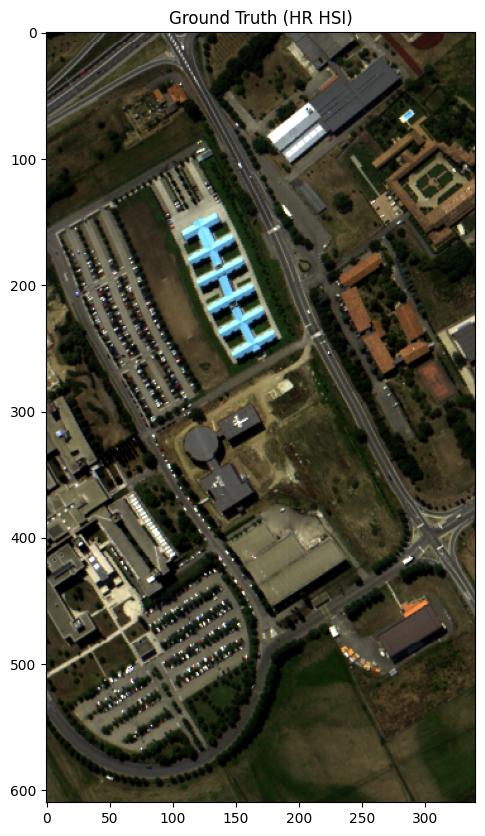

MSI shape:  (610, 340, 1)


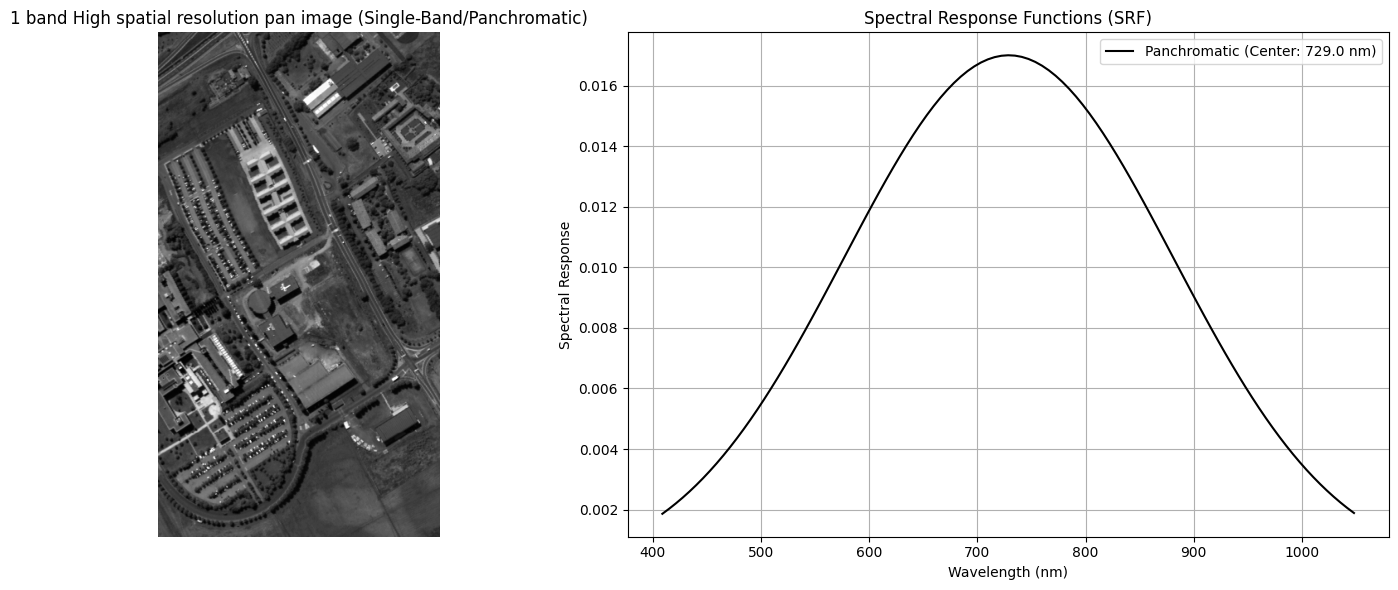

MSI shape:  (610, 340, 3)


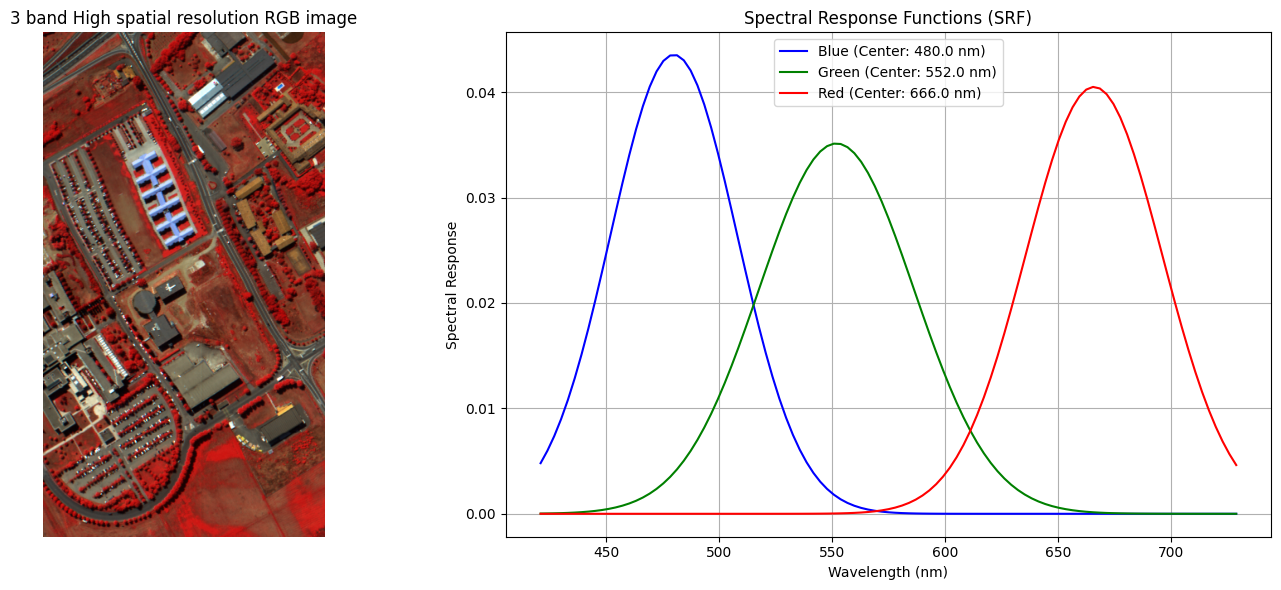

MSI shape:  (610, 340, 4)


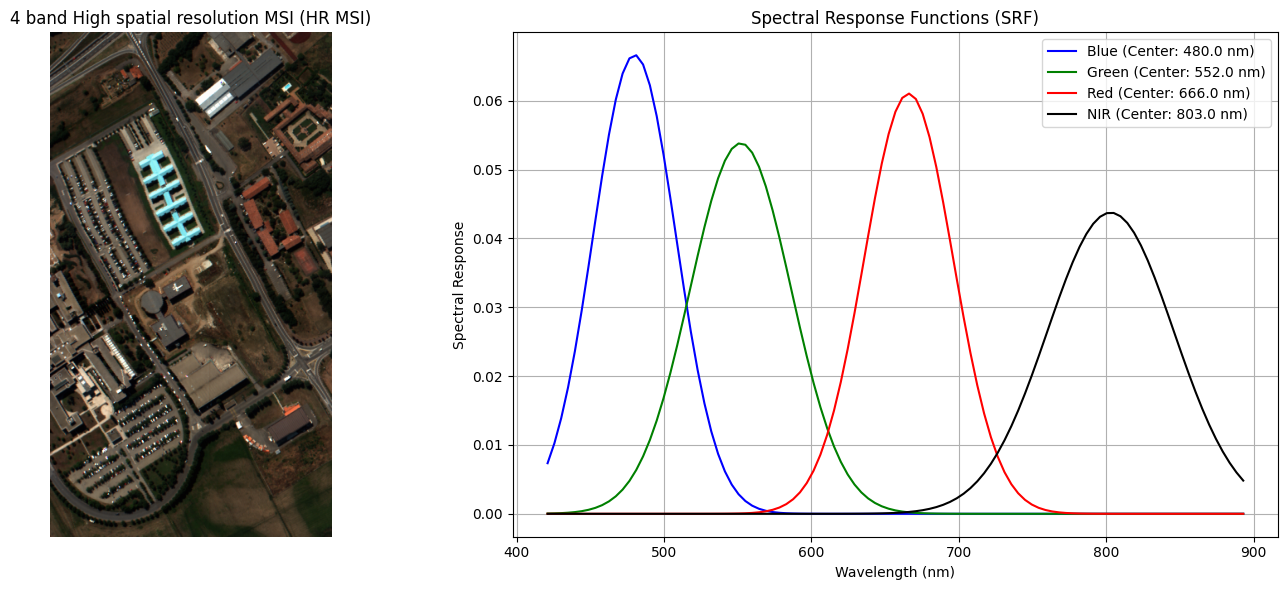

MSI shape:  (610, 340, 8)


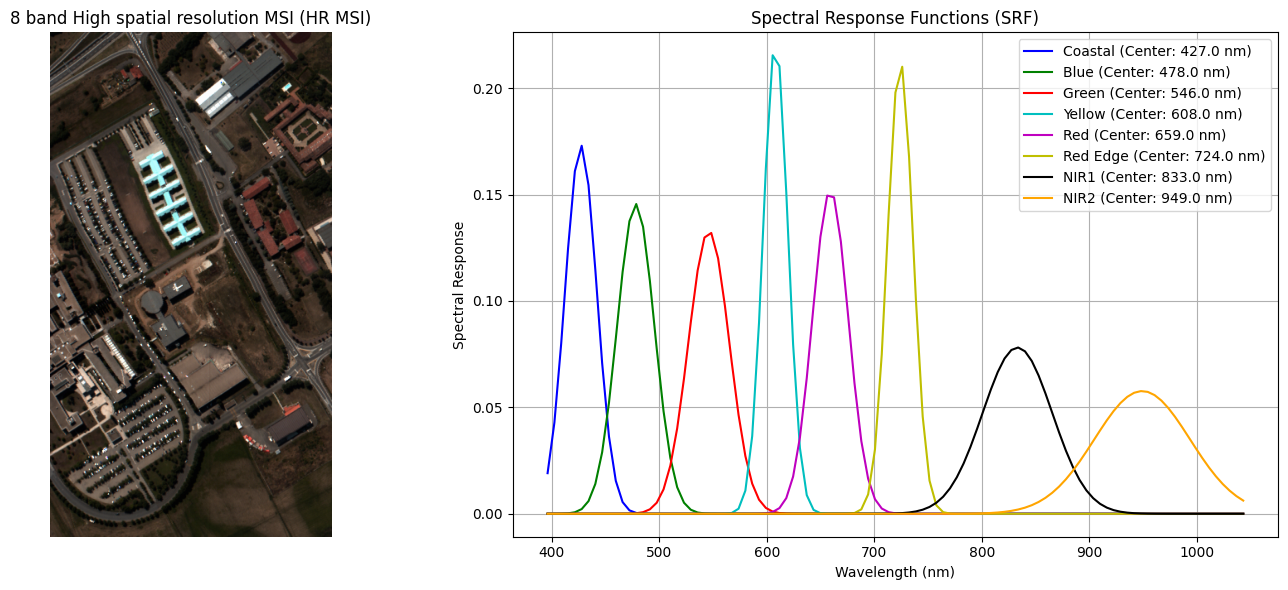

MSI shape:  (610, 340, 16)


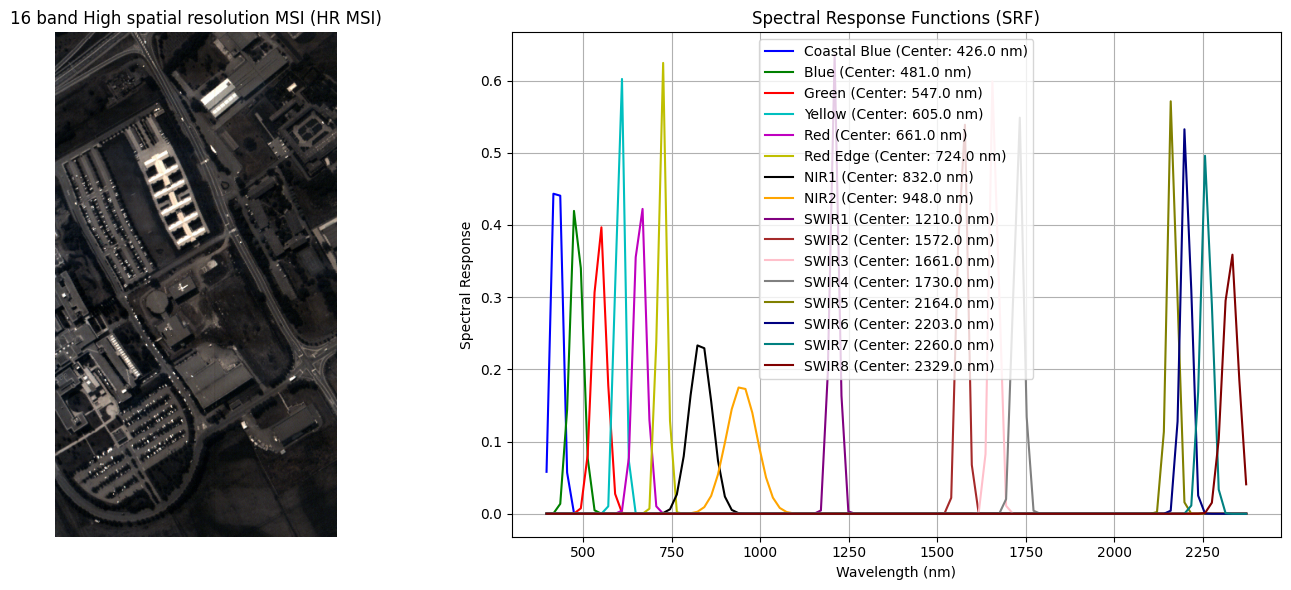

In [9]:
pavia_university = sio.loadmat(mat_file_path)
pavia_university_image = pavia_university['paviaU']

# Ground Truth HR HSI (H, W, C)
I_REF = normalize(pavia_university_image)
print("Ground truth image shape: ", I_REF.shape)
visualize_hsi(I_REF, (50,35,15), "Ground Truth (HR HSI)")

# High Resolution MSI with 1 band
I_MS_1, srf_1, band_specs_1, auto_wavs_1 = spectral_degradation(image=pavia_university_image, SNR=40, num_bands=1, fwhm_factor=4.2)
print("MSI shape: ", I_MS_1.shape)
plot_multispectral_with_srf(I_MS_1, None, "1 band High spatial resolution pan image", srf_1, auto_wavs_1, band_specs_1)

# High Resolution MSI with 3 bands
I_MS_3, srf_3, band_specs_3, auto_wavs_3 = spectral_degradation(image=pavia_university_image, SNR=40, num_bands=3, fwhm_factor=4.2)
print("MSI shape: ", I_MS_3.shape)
plot_multispectral_with_srf(I_MS_3, (2,1,0), "3 band High spatial resolution RGB image", srf_3, auto_wavs_3, band_specs_3)

# High Resolution MSI with 4 bands
I_MS_4, srf_4, band_specs_4, auto_wavs_4 = spectral_degradation(image=pavia_university_image, SNR=40, num_bands=4, fwhm_factor=4.2)
print("MSI shape: ", I_MS_4.shape)
plot_multispectral_with_srf(I_MS_4, (2,1,0), "4 band High spatial resolution MSI (HR MSI)", srf_4, auto_wavs_4, band_specs_4)

# High Resolution MSI with 8 bands
I_MS_8, srf_8, band_specs_8, auto_wavs_8 = spectral_degradation(image=pavia_university_image, SNR=40, num_bands=8, fwhm_factor=4.2)
print("MSI shape: ", I_MS_8.shape)
plot_multispectral_with_srf(I_MS_8, (4,2,1), "8 band High spatial resolution MSI (HR MSI)", srf_8, auto_wavs_8, band_specs_8)

# High Resolution MSI with 16 bands
I_MS_16, srf_16, band_specs_16, auto_wavs_16 = spectral_degradation(image=pavia_university_image, SNR=40, num_bands=16, fwhm_factor=4.2)
print("MSI shape: ", I_MS_16.shape)
plot_multispectral_with_srf(I_MS_16, (4,2,1), "16 band High spatial resolution MSI (HR MSI)", srf_16, auto_wavs_16, band_specs_16)

Setting up and visualizing the HSI images with Gaussian PSF

HSI shape with 4x Downsample:  (152, 85, 103)


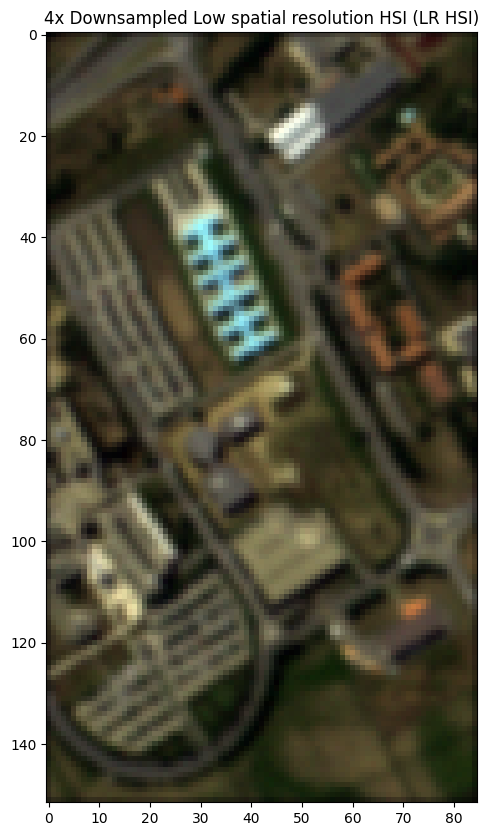

HSI shape with 8x Downsample:  (76, 42, 103)


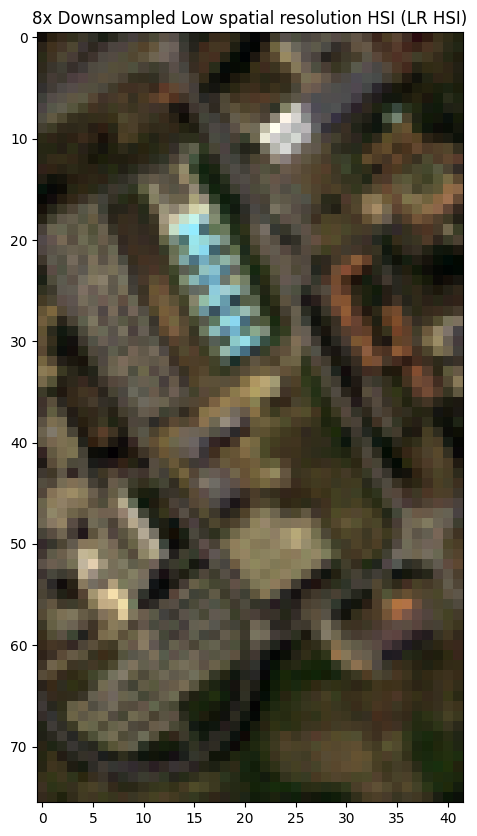

HSI shape with 16x Downsample:  (38, 21, 103)


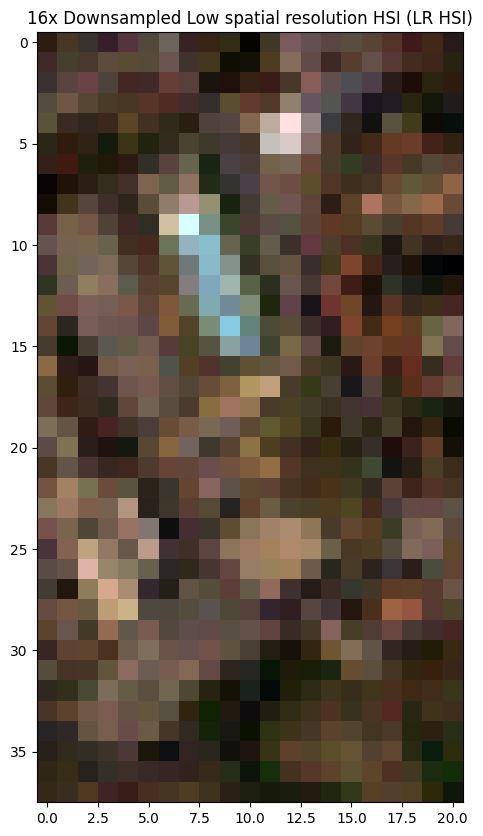

HSI shape with 32x Downsample:  (19, 10, 103)


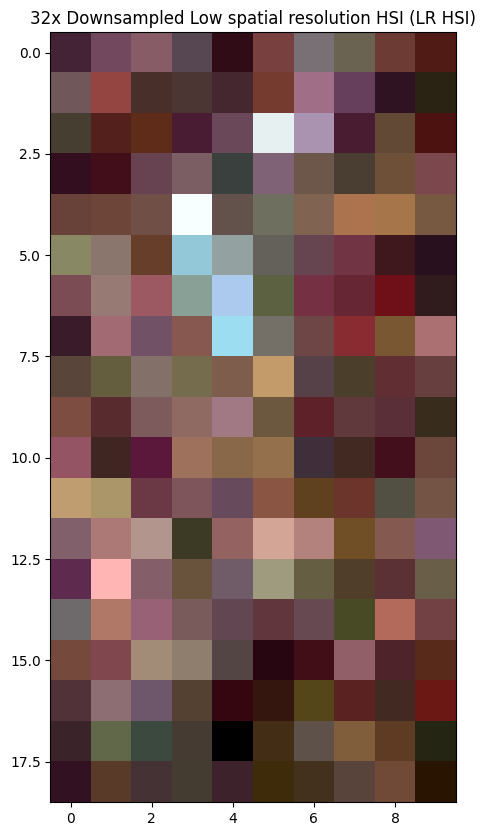

In [10]:
# Low Resolution HSI with 4x downsampling (H/4, W/4, C)
I_HS_4_gaus = spatial_degradation(pavia_university_image, gaus_psf, 4, 35)
print("HSI shape with 4x Downsample: ", I_HS_4_gaus.shape)
visualize_hsi(I_HS_4_gaus, (50,35,15), "4x Downsampled Low spatial resolution HSI (LR HSI)")

# Low Resolution HSI with 8x downsampling (H/8, W/8, C)
I_HS_8_gaus = spatial_degradation(pavia_university_image, gaus_psf, 8, 30)
print("HSI shape with 8x Downsample: ", I_HS_8_gaus.shape)
visualize_hsi(I_HS_8_gaus, (50,35,15), "8x Downsampled Low spatial resolution HSI (LR HSI)")

# Low Resolution HSI with 16x downsampling (H/16, W/16, C)
I_HS_16_gaus = spatial_degradation(pavia_university_image, gaus_psf, 16, 25)
print("HSI shape with 16x Downsample: ", I_HS_16_gaus.shape)
visualize_hsi(I_HS_16_gaus, (50,35,15), "16x Downsampled Low spatial resolution HSI (LR HSI)")

# Low Resolution HSI with 32x downsampling (H/32, W/32, C)
I_HS_32_gaus = spatial_degradation(pavia_university_image, gaus_psf, 32, 20)
print("HSI shape with 32x Downsample: ", I_HS_32_gaus.shape)
visualize_hsi(I_HS_32_gaus, (50,35,15), "32x Downsampled Low spatial resolution HSI (LR HSI)")

Setting up and visualizing the HSI images with Kolmogorov PSF

HSI shape with 4x Downsample:  (152, 85, 103)


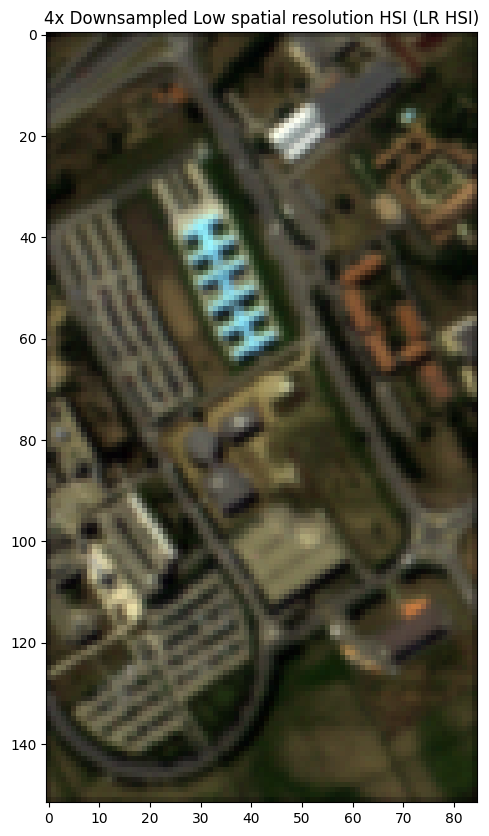

HSI shape with 8x Downsample:  (76, 42, 103)


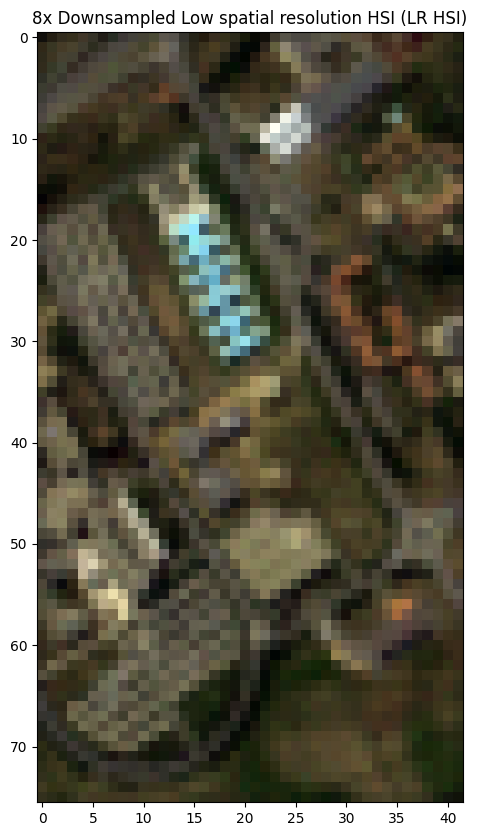

HSI shape with 16x Downsample:  (38, 21, 103)


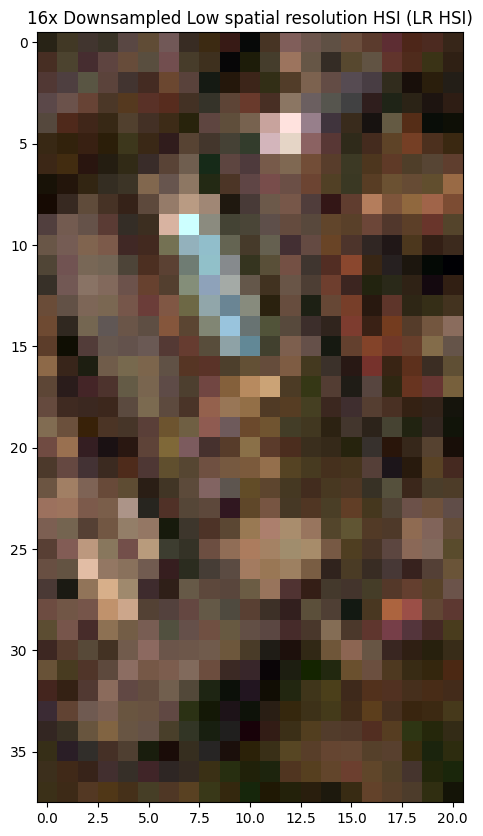

HSI shape with 32x Downsample:  (19, 10, 103)


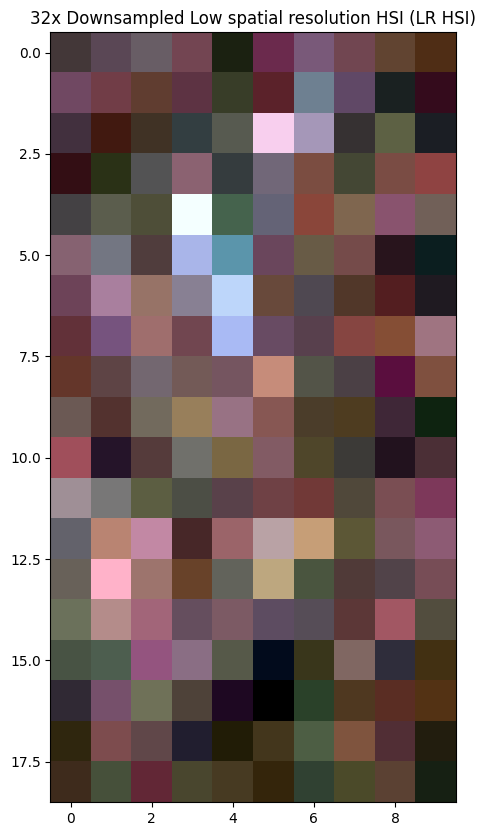

In [11]:
# Low Resolution HSI with 4x downsampling (H/4, W/4, C)
I_HS_4_kol = spatial_degradation(pavia_university_image, kol_psf, 4, 35)
print("HSI shape with 4x Downsample: ", I_HS_4_kol.shape)
visualize_hsi(I_HS_4_kol, (50,35,15), "4x Downsampled Low spatial resolution HSI (LR HSI)")

# Low Resolution HSI with 8x downsampling (H/8, W/8, C)
I_HS_8_kol = spatial_degradation(pavia_university_image, kol_psf, 8, 30)
print("HSI shape with 8x Downsample: ", I_HS_8_kol.shape)
visualize_hsi(I_HS_8_kol, (50,35,15), "8x Downsampled Low spatial resolution HSI (LR HSI)")

# Low Resolution HSI with 16x downsampling (H/16, W/16, C)
I_HS_16_kol = spatial_degradation(pavia_university_image, kol_psf, 16, 25)
print("HSI shape with 16x Downsample: ", I_HS_16_kol.shape)
visualize_hsi(I_HS_16_kol, (50,35,15), "16x Downsampled Low spatial resolution HSI (LR HSI)")

# Low Resolution HSI with 32x downsampling (H/32, W/32, C)
I_HS_32_kol = spatial_degradation(pavia_university_image, kol_psf, 32, 20)
print("HSI shape with 32x Downsample: ", I_HS_32_kol.shape)
visualize_hsi(I_HS_32_kol, (50,35,15), "32x Downsampled Low spatial resolution HSI (LR HSI)")

Setting up and visualizing the HSI images with Airy PSF

HSI shape with 4x Downsample:  (152, 85, 103)


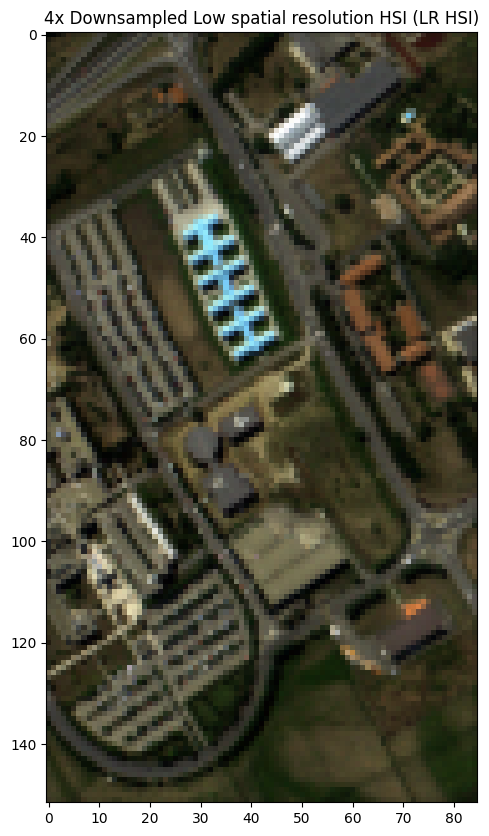

HSI shape with 8x Downsample:  (76, 42, 103)


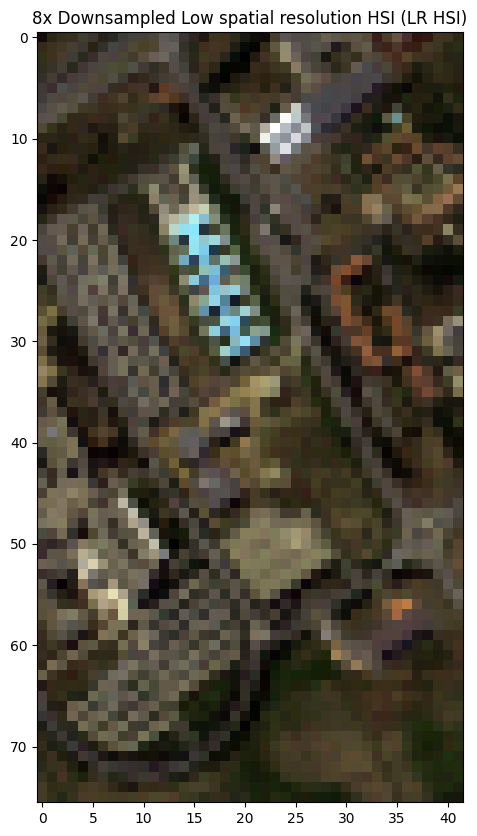

HSI shape with 16x Downsample:  (38, 21, 103)


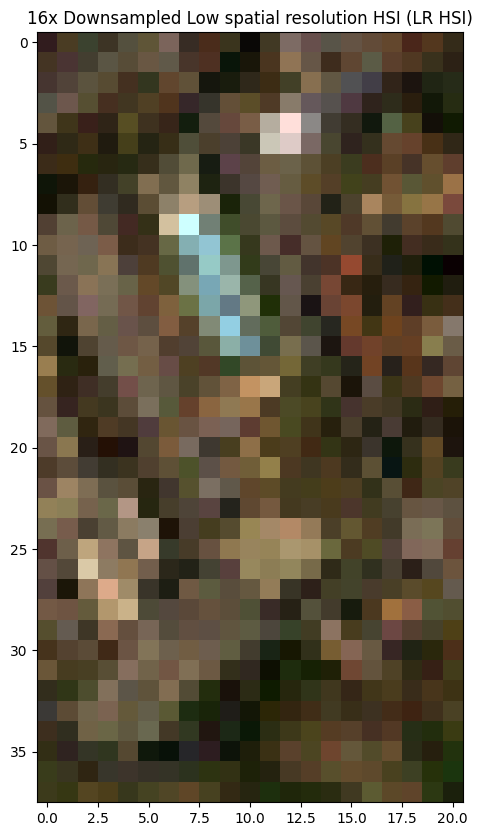

HSI shape with 32x Downsample:  (19, 10, 103)


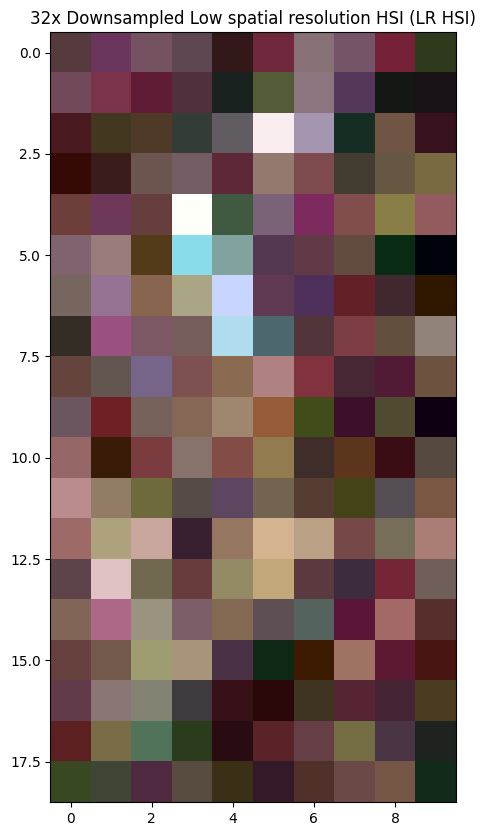

In [12]:
# Low Resolution HSI with 4x downsampling (H/4, W/4, C)
I_HS_4_air = spatial_degradation(pavia_university_image, air_psf, 4, 35)
print("HSI shape with 4x Downsample: ", I_HS_4_air.shape)
visualize_hsi(I_HS_4_air, (50,35,15), "4x Downsampled Low spatial resolution HSI (LR HSI)")

# Low Resolution HSI with 8x downsampling (H/8, W/8, C)
I_HS_8_air = spatial_degradation(pavia_university_image, air_psf, 8, 30)
print("HSI shape with 8x Downsample: ", I_HS_8_air.shape)
visualize_hsi(I_HS_8_air, (50,35,15), "8x Downsampled Low spatial resolution HSI (LR HSI)")

# Low Resolution HSI with 16x downsampling (H/16, W/16, C)
I_HS_16_air = spatial_degradation(pavia_university_image, air_psf, 16, 25)
print("HSI shape with 16x Downsample: ", I_HS_16_air.shape)
visualize_hsi(I_HS_16_air, (50,35,15), "16x Downsampled Low spatial resolution HSI (LR HSI)")

# Low Resolution HSI with 32x downsampling (H/32, W/32, C)
I_HS_32_air = spatial_degradation(pavia_university_image, air_psf, 32, 20)
print("HSI shape with 32x Downsample: ", I_HS_32_air.shape)
visualize_hsi(I_HS_32_air, (50,35,15), "32x Downsampled Low spatial resolution HSI (LR HSI)")

Setting up and visualizing the HSI images with Moffat PSF

HSI shape with 4x Downsample:  (152, 85, 103)


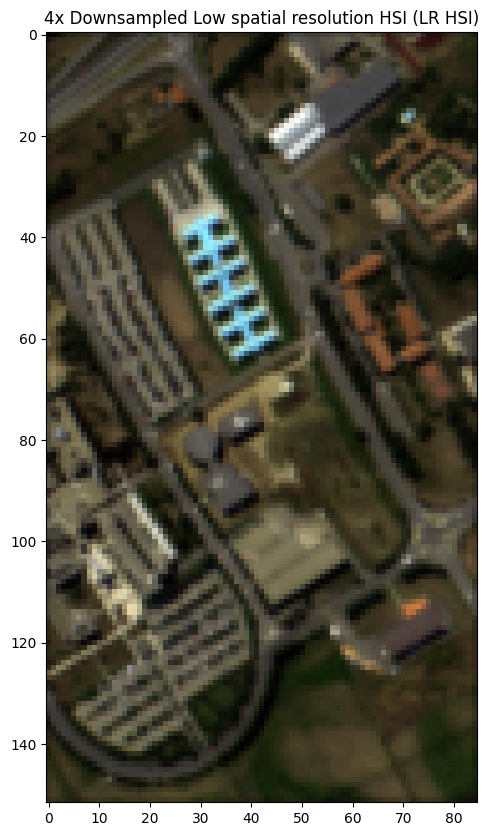

HSI shape with 8x Downsample:  (76, 42, 103)


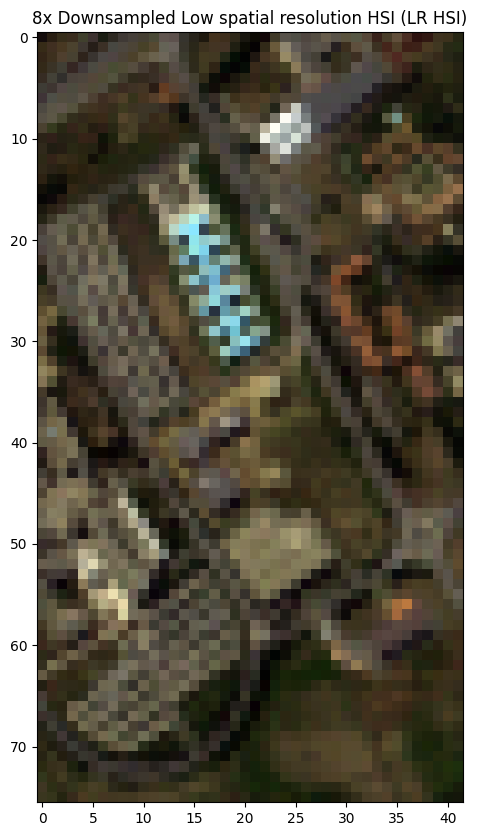

HSI shape with 16x Downsample:  (38, 21, 103)


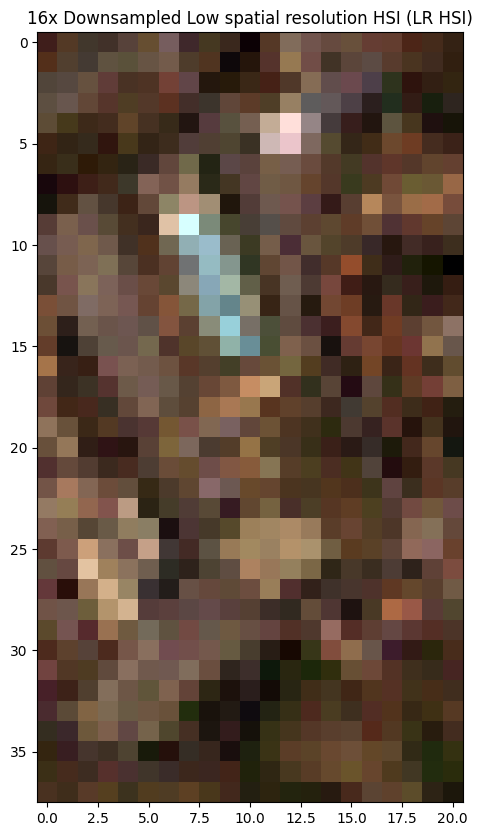

HSI shape with 32x Downsample:  (19, 10, 103)


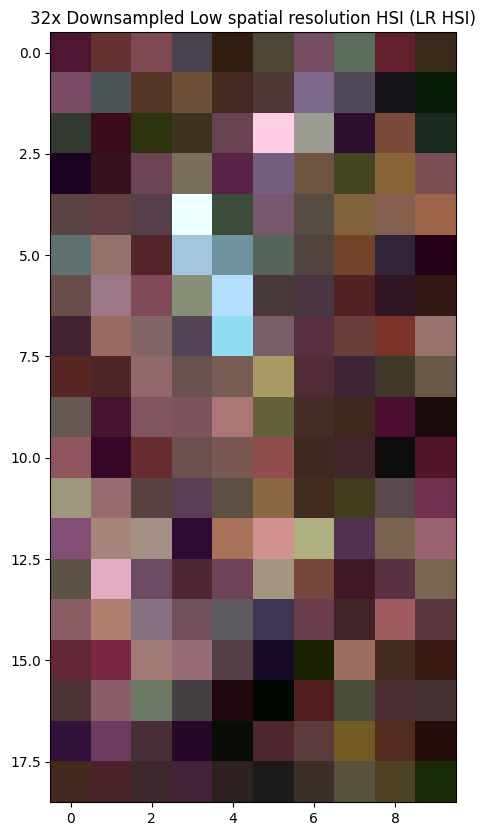

In [13]:
# Low Resolution HSI with 4x downsampling (H/4, W/4, C)
I_HS_4_mof = spatial_degradation(pavia_university_image, mof_psf, 4, 35)
print("HSI shape with 4x Downsample: ", I_HS_4_mof.shape)
visualize_hsi(I_HS_4_mof, (50,35,15), "4x Downsampled Low spatial resolution HSI (LR HSI)")

# Low Resolution HSI with 8x downsampling (H/8, W/8, C)
I_HS_8_mof = spatial_degradation(pavia_university_image, mof_psf, 8, 30)
print("HSI shape with 8x Downsample: ", I_HS_8_mof.shape)
visualize_hsi(I_HS_8_mof, (50,35,15), "8x Downsampled Low spatial resolution HSI (LR HSI)")

# Low Resolution HSI with 16x downsampling (H/16, W/16, C)
I_HS_16_mof = spatial_degradation(pavia_university_image, mof_psf, 16, 25)
print("HSI shape with 16x Downsample: ", I_HS_16_mof.shape)
visualize_hsi(I_HS_16_mof, (50,35,15), "16x Downsampled Low spatial resolution HSI (LR HSI)")

# Low Resolution HSI with 32x downsampling (H/32, W/32, C)
I_HS_32_mof = spatial_degradation(pavia_university_image, mof_psf, 32, 20)
print("HSI shape with 32x Downsample: ", I_HS_32_mof.shape)
visualize_hsi(I_HS_32_mof, (50,35,15), "32x Downsampled Low spatial resolution HSI (LR HSI)")

Setting up and visualizing the HSI images with Sinc PSF

HSI shape with 4x Downsample:  (152, 85, 103)


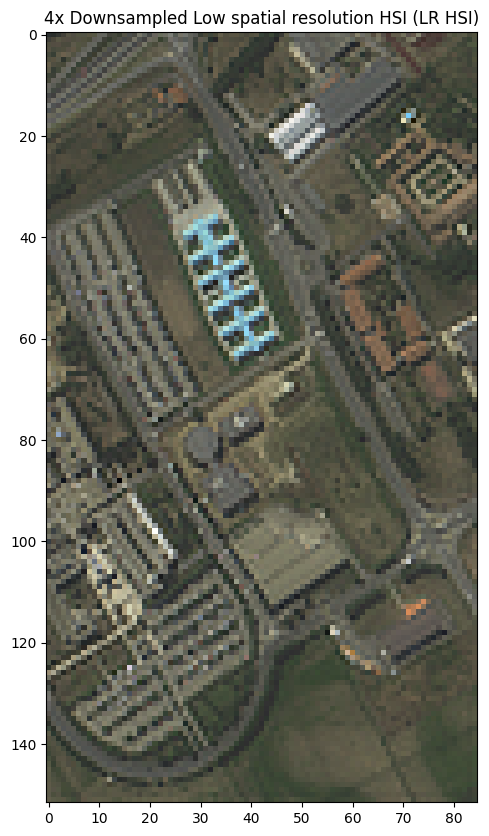

HSI shape with 8x Downsample:  (76, 42, 103)


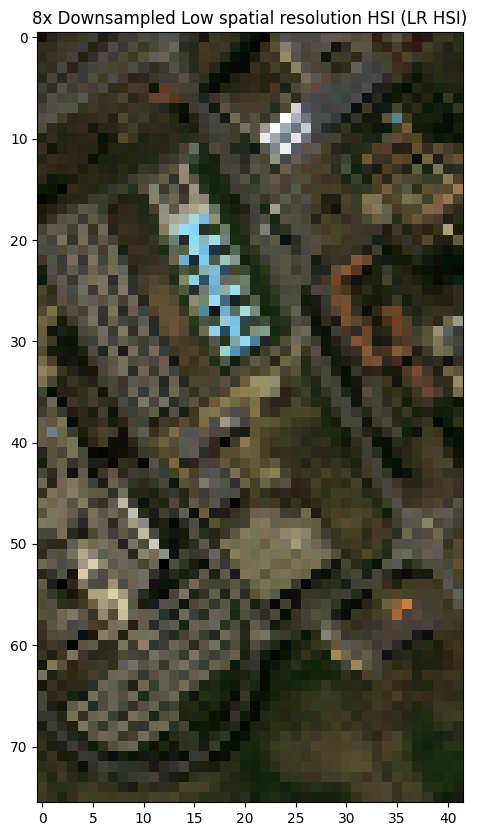

HSI shape with 16x Downsample:  (38, 21, 103)


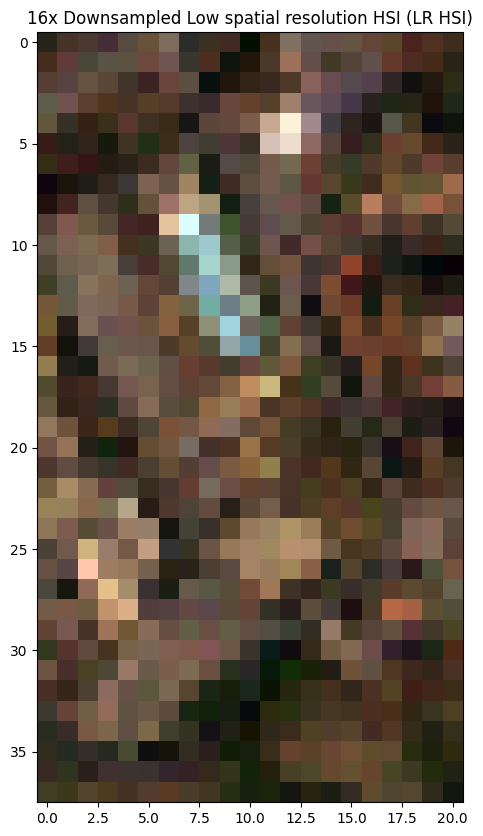

HSI shape with 32x Downsample:  (19, 10, 103)


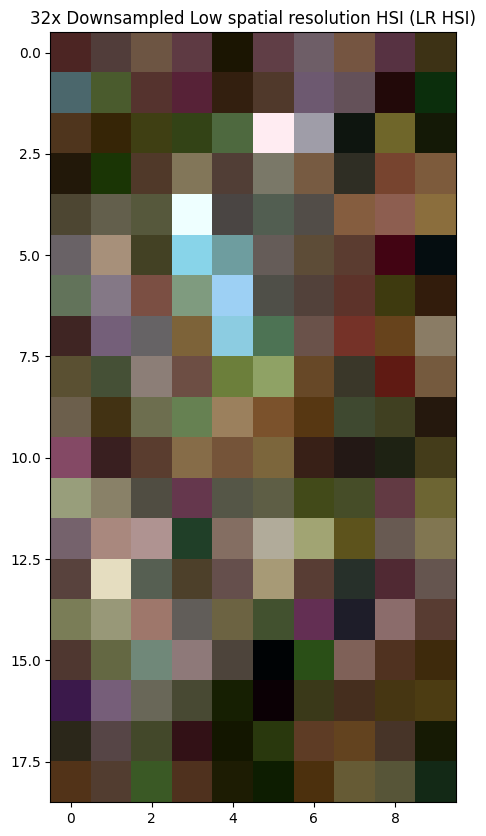

In [14]:
# Low Resolution HSI with 4x downsampling (H/4, W/4, C)
I_HS_4_sinc = spatial_degradation(pavia_university_image, sinc_psf, 4, 35)
print("HSI shape with 4x Downsample: ", I_HS_4_sinc.shape)
visualize_hsi(I_HS_4_sinc, (50,35,15), "4x Downsampled Low spatial resolution HSI (LR HSI)")

# Low Resolution HSI with 8x downsampling (H/8, W/8, C)
I_HS_8_sinc = spatial_degradation(pavia_university_image, sinc_psf, 8, 30)
print("HSI shape with 8x Downsample: ", I_HS_8_sinc.shape)
visualize_hsi(I_HS_8_sinc, (50,35,15), "8x Downsampled Low spatial resolution HSI (LR HSI)")

# Low Resolution HSI with 16x downsampling (H/16, W/16, C)
I_HS_16_sinc = spatial_degradation(pavia_university_image, sinc_psf, 16, 25)
print("HSI shape with 16x Downsample: ", I_HS_16_sinc.shape)
visualize_hsi(I_HS_16_sinc, (50,35,15), "16x Downsampled Low spatial resolution HSI (LR HSI)")

# Low Resolution HSI with 32x downsampling (H/32, W/32, C)
I_HS_32_sinc = spatial_degradation(pavia_university_image, sinc_psf, 32, 20)
print("HSI shape with 32x Downsample: ", I_HS_32_sinc.shape)
visualize_hsi(I_HS_32_sinc, (50,35,15), "32x Downsampled Low spatial resolution HSI (LR HSI)")

Setting up and visualizing the HSI images with Lorentzian Squared PSF

HSI shape with 4x Downsample:  (152, 85, 103)


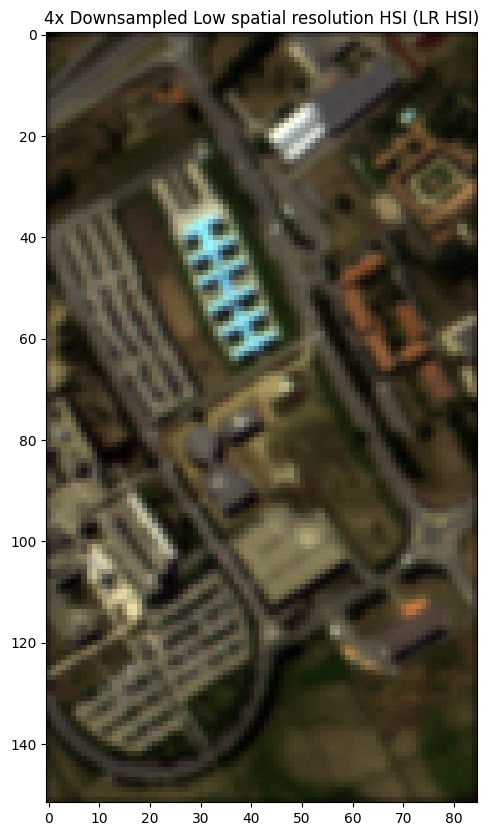

HSI shape with 8x Downsample:  (76, 42, 103)


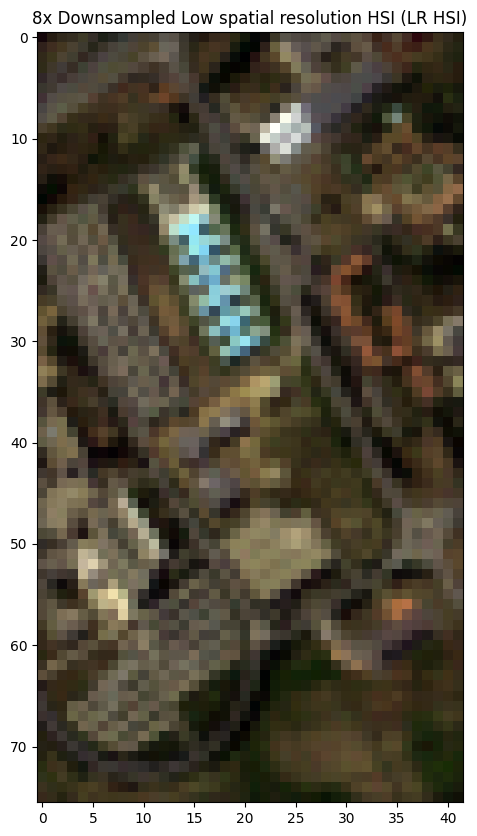

HSI shape with 16x Downsample:  (38, 21, 103)


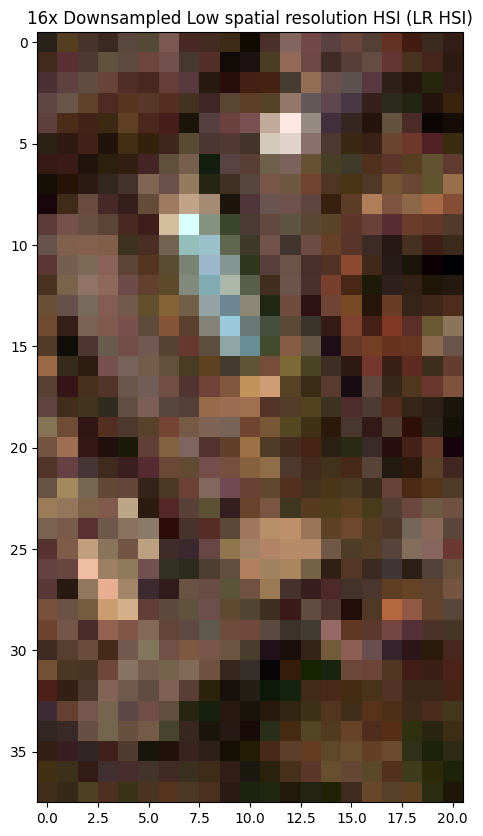

HSI shape with 32x Downsample:  (19, 10, 103)


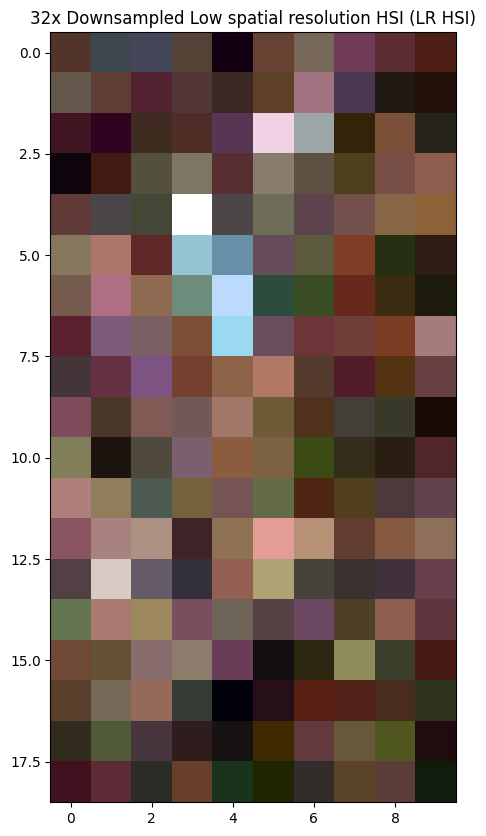

In [15]:
# Low Resolution HSI with 4x downsampling (H/4, W/4, C)
I_HS_4_lor_sq = spatial_degradation(pavia_university_image, lor_sq_psf, 4, 35)
print("HSI shape with 4x Downsample: ", I_HS_4_lor_sq.shape)
visualize_hsi(I_HS_4_lor_sq, (50,35,15), "4x Downsampled Low spatial resolution HSI (LR HSI)")

# Low Resolution HSI with 8x downsampling (H/8, W/8, C)
I_HS_8_lor_sq = spatial_degradation(pavia_university_image, lor_sq_psf, 8, 30)
print("HSI shape with 8x Downsample: ", I_HS_8_lor_sq.shape)
visualize_hsi(I_HS_8_lor_sq, (50,35,15), "8x Downsampled Low spatial resolution HSI (LR HSI)")

# Low Resolution HSI with 16x downsampling (H/16, W/16, C)
I_HS_16_lor_sq = spatial_degradation(pavia_university_image, lor_sq_psf, 16, 25)
print("HSI shape with 16x Downsample: ", I_HS_16_lor_sq.shape)
visualize_hsi(I_HS_16_lor_sq, (50,35,15), "16x Downsampled Low spatial resolution HSI (LR HSI)")

# Low Resolution HSI with 32x downsampling (H/32, W/32, C)
I_HS_32_lor_sq = spatial_degradation(pavia_university_image, lor_sq_psf, 32, 20)
print("HSI shape with 32x Downsample: ", I_HS_32_lor_sq.shape)
visualize_hsi(I_HS_32_lor_sq, (50,35,15), "32x Downsampled Low spatial resolution HSI (LR HSI)")

Setting up and visualizing the HSI images with Hermite PSF

HSI shape with 4x Downsample:  (152, 85, 103)


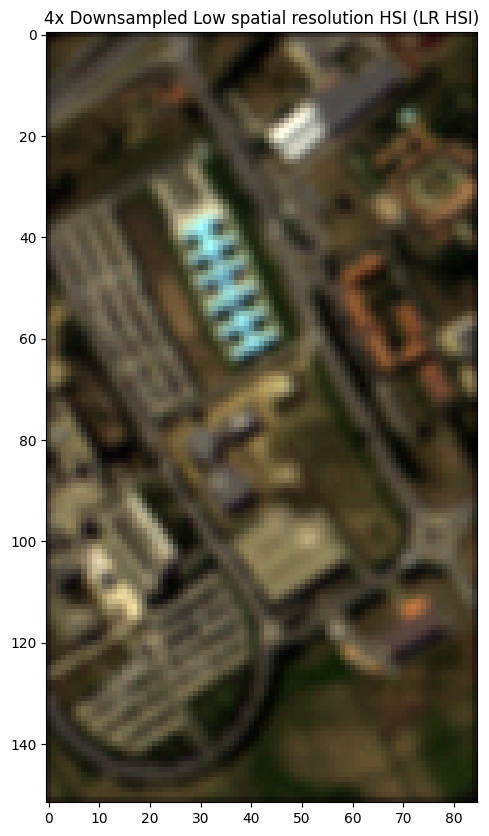

HSI shape with 8x Downsample:  (76, 42, 103)


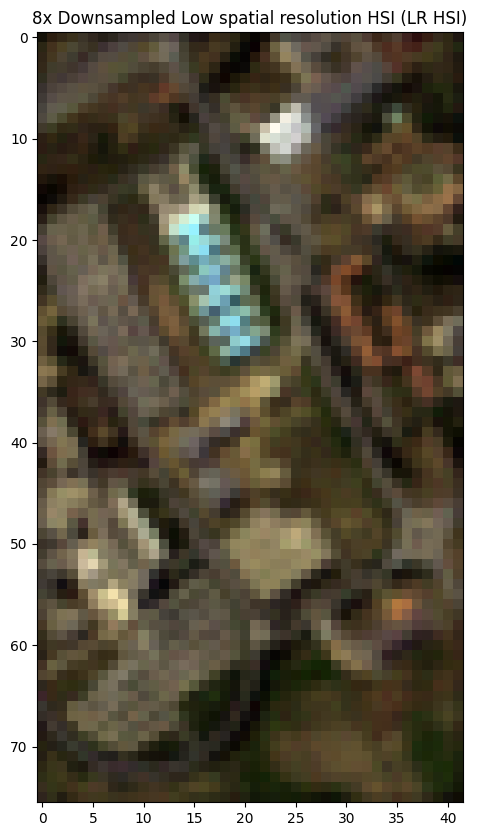

HSI shape with 16x Downsample:  (38, 21, 103)


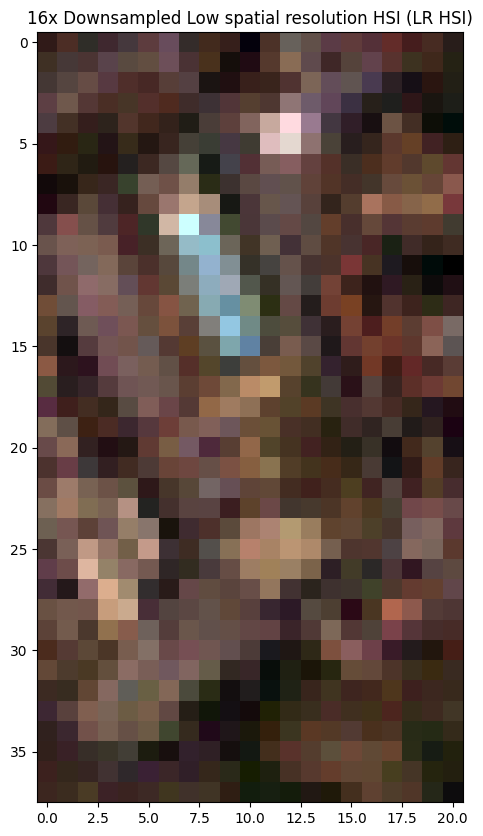

HSI shape with 32x Downsample:  (19, 10, 103)


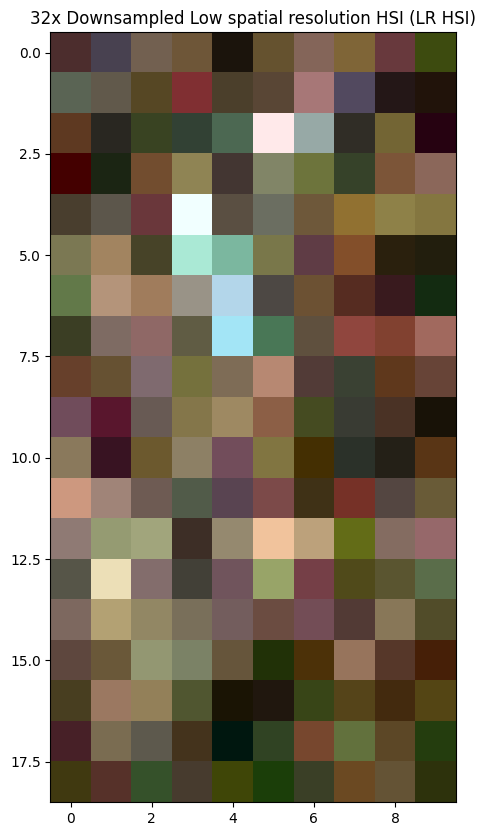

In [16]:
# Low Resolution HSI with 4x downsampling (H/4, W/4, C)
I_HS_4_her = spatial_degradation(pavia_university_image, her_psf, 4, 35)
print("HSI shape with 4x Downsample: ", I_HS_4_her.shape)
visualize_hsi(I_HS_4_her, (50,35,15), "4x Downsampled Low spatial resolution HSI (LR HSI)")

# Low Resolution HSI with 8x downsampling (H/8, W/8, C)
I_HS_8_her = spatial_degradation(pavia_university_image, her_psf, 8, 30)
print("HSI shape with 8x Downsample: ", I_HS_8_her.shape)
visualize_hsi(I_HS_8_her, (50,35,15), "8x Downsampled Low spatial resolution HSI (LR HSI)")

# Low Resolution HSI with 16x downsampling (H/16, W/16, C)
I_HS_16_her = spatial_degradation(pavia_university_image, her_psf, 16, 25)
print("HSI shape with 16x Downsample: ", I_HS_16_her.shape)
visualize_hsi(I_HS_16_her, (50,35,15), "16x Downsampled Low spatial resolution HSI (LR HSI)")

# Low Resolution HSI with 32x downsampling (H/32, W/32, C)
I_HS_32_her = spatial_degradation(pavia_university_image, her_psf, 32, 20)
print("HSI shape with 32x Downsample: ", I_HS_32_her.shape)
visualize_hsi(I_HS_32_her, (50,35,15), "32x Downsampled Low spatial resolution HSI (LR HSI)")

Setting up and visualizing the HSI images with Parabolic PSF

HSI shape with 4x Downsample:  (152, 85, 103)


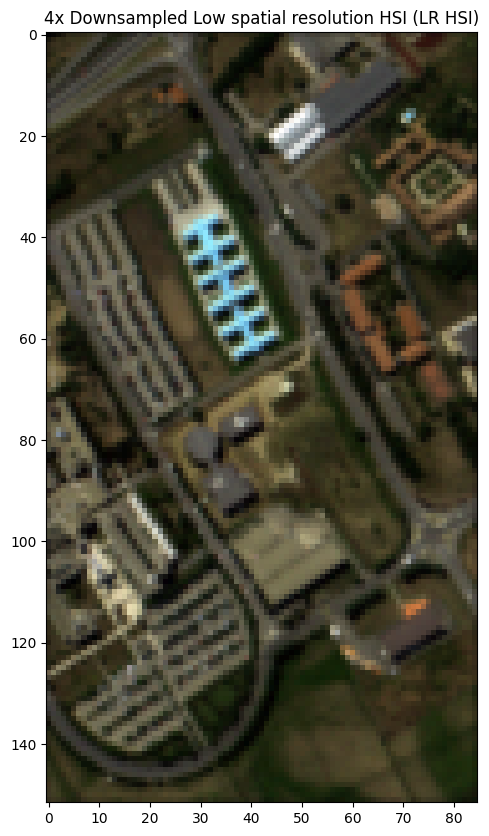

HSI shape with 8x Downsample:  (76, 42, 103)


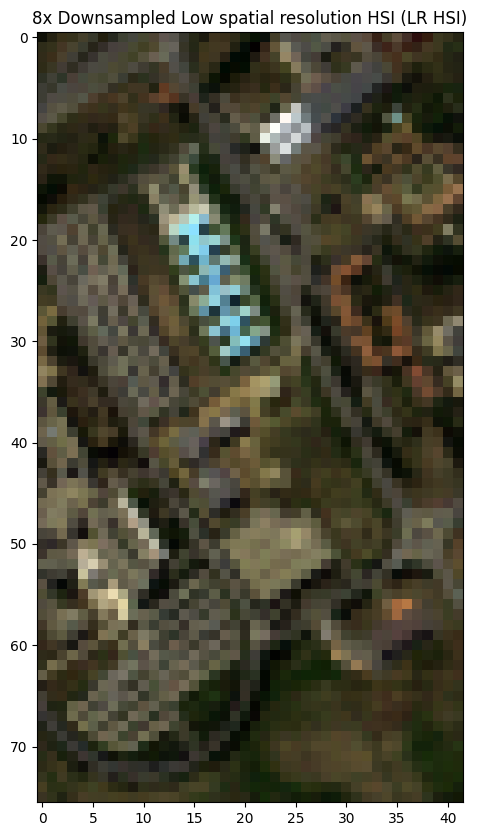

HSI shape with 16x Downsample:  (38, 21, 103)


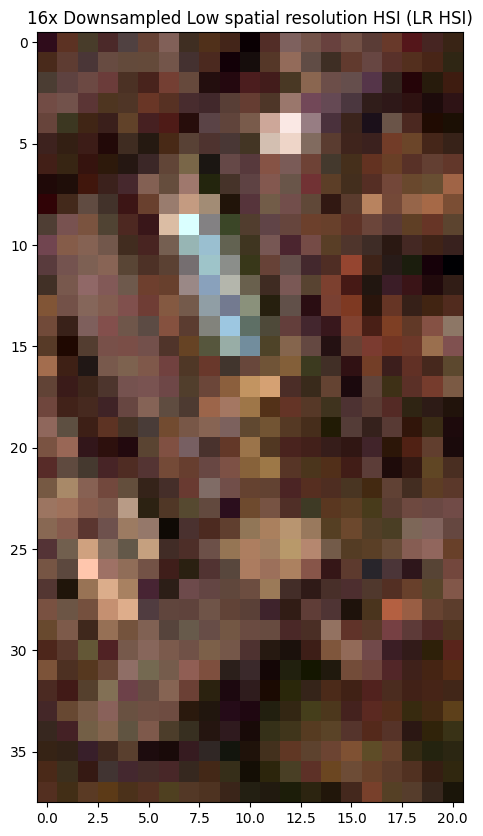

HSI shape with 32x Downsample:  (19, 10, 103)


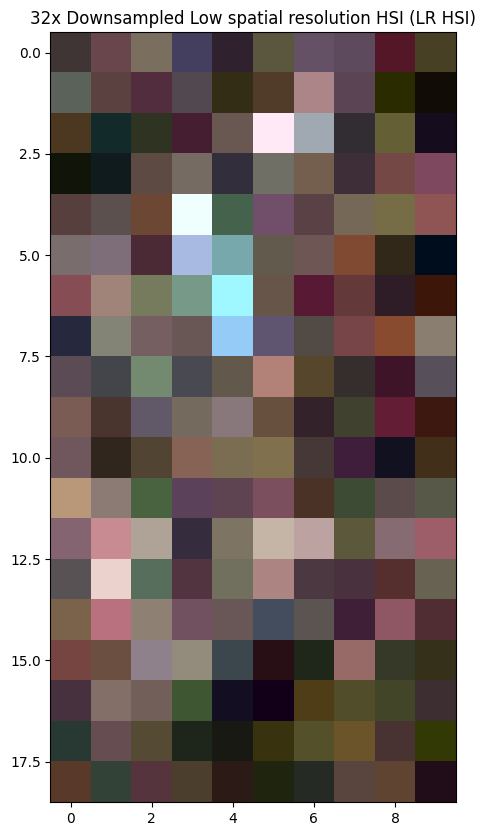

In [17]:
# Low Resolution HSI with 4x downsampling (H/4, W/4, C)
I_HS_4_par = spatial_degradation(pavia_university_image, par_psf, 4, 35)
print("HSI shape with 4x Downsample: ", I_HS_4_par.shape)
visualize_hsi(I_HS_4_par, (50,35,15), "4x Downsampled Low spatial resolution HSI (LR HSI)")

# Low Resolution HSI with 8x downsampling (H/8, W/8, C)
I_HS_8_par = spatial_degradation(pavia_university_image, par_psf, 8, 30)
print("HSI shape with 8x Downsample: ", I_HS_8_par.shape)
visualize_hsi(I_HS_8_par, (50,35,15), "8x Downsampled Low spatial resolution HSI (LR HSI)")

# Low Resolution HSI with 16x downsampling (H/16, W/16, C)
I_HS_16_par = spatial_degradation(pavia_university_image, par_psf, 16, 25)
print("HSI shape with 16x Downsample: ", I_HS_16_par.shape)
visualize_hsi(I_HS_16_par, (50,35,15), "16x Downsampled Low spatial resolution HSI (LR HSI)")

# Low Resolution HSI with 32x downsampling (H/32, W/32, C)
I_HS_32_par = spatial_degradation(pavia_university_image, par_psf, 32, 20)
print("HSI shape with 32x Downsample: ", I_HS_32_par.shape)
visualize_hsi(I_HS_32_par, (50,35,15), "32x Downsampled Low spatial resolution HSI (LR HSI)")

Setting up and visualizing the HSI images with Gabor PSF

HSI shape with 4x Downsample:  (152, 85, 103)


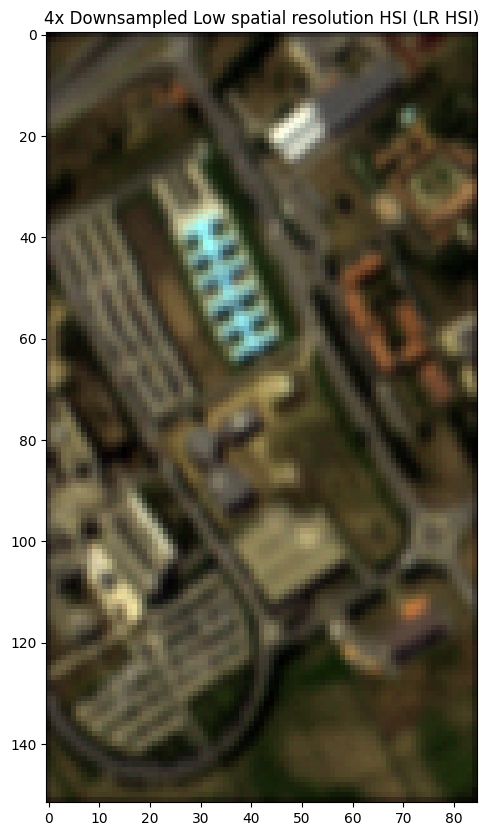

HSI shape with 8x Downsample:  (76, 42, 103)


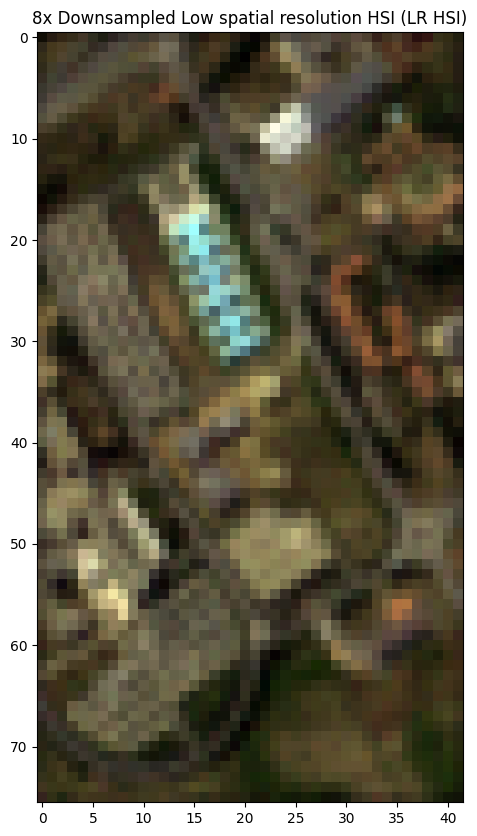

HSI shape with 16x Downsample:  (38, 21, 103)


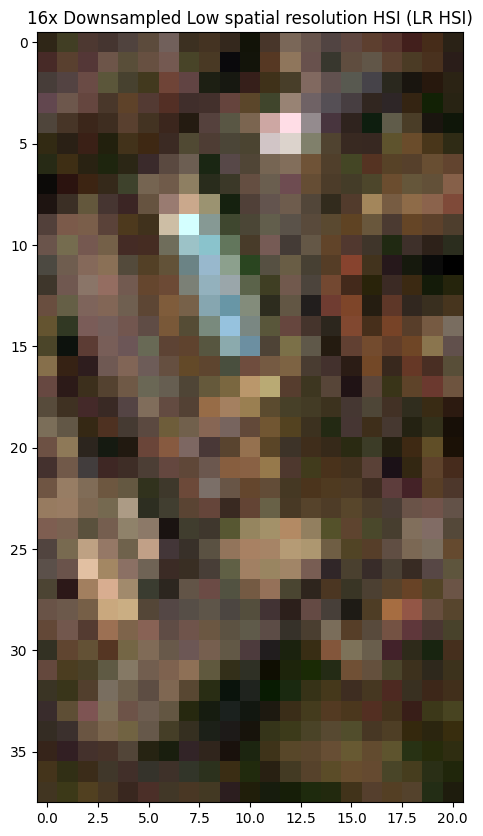

HSI shape with 32x Downsample:  (19, 10, 103)


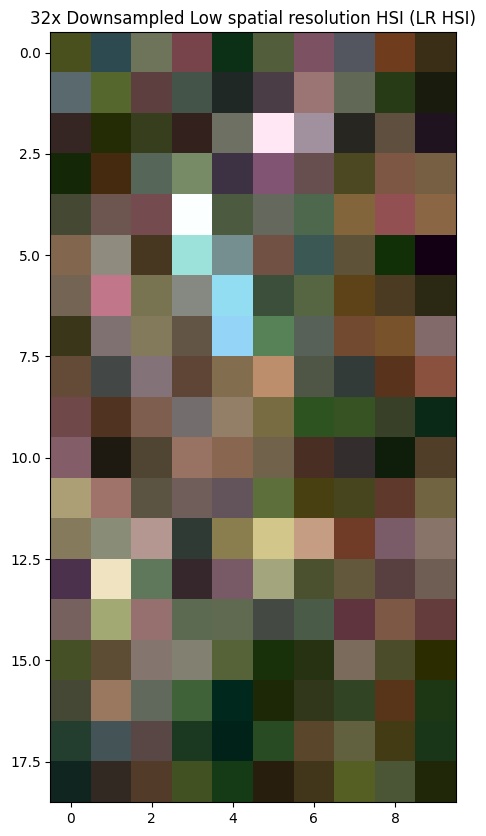

In [18]:
# Low Resolution HSI with 4x downsampling (H/4, W/4, C)
I_HS_4_gab = spatial_degradation(pavia_university_image, gab_psf, 4, 35)
print("HSI shape with 4x Downsample: ", I_HS_4_gab.shape)
visualize_hsi(I_HS_4_gab, (50,35,15), "4x Downsampled Low spatial resolution HSI (LR HSI)")

# Low Resolution HSI with 8x downsampling (H/8, W/8, C)
I_HS_8_gab = spatial_degradation(pavia_university_image, gab_psf, 8, 30)
print("HSI shape with 8x Downsample: ", I_HS_8_gab.shape)
visualize_hsi(I_HS_8_gab, (50,35,15), "8x Downsampled Low spatial resolution HSI (LR HSI)")

# Low Resolution HSI with 16x downsampling (H/16, W/16, C)
I_HS_16_gab = spatial_degradation(pavia_university_image, gab_psf, 16, 25)
print("HSI shape with 16x Downsample: ", I_HS_16_gab.shape)
visualize_hsi(I_HS_16_gab, (50,35,15), "16x Downsampled Low spatial resolution HSI (LR HSI)")

# Low Resolution HSI with 32x downsampling (H/32, W/32, C)
I_HS_32_gab = spatial_degradation(pavia_university_image, gab_psf, 32, 20)
print("HSI shape with 32x Downsample: ", I_HS_32_gab.shape)
visualize_hsi(I_HS_32_gab, (50,35,15), "32x Downsampled Low spatial resolution HSI (LR HSI)")

Setting up and visualizing the HSI images with Delta PSF

HSI shape with 4x Downsample:  (152, 85, 103)


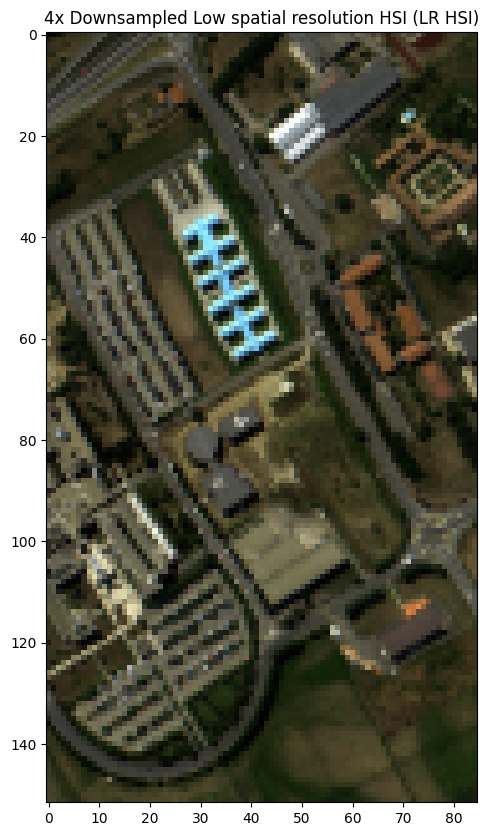

HSI shape with 8x Downsample:  (76, 42, 103)


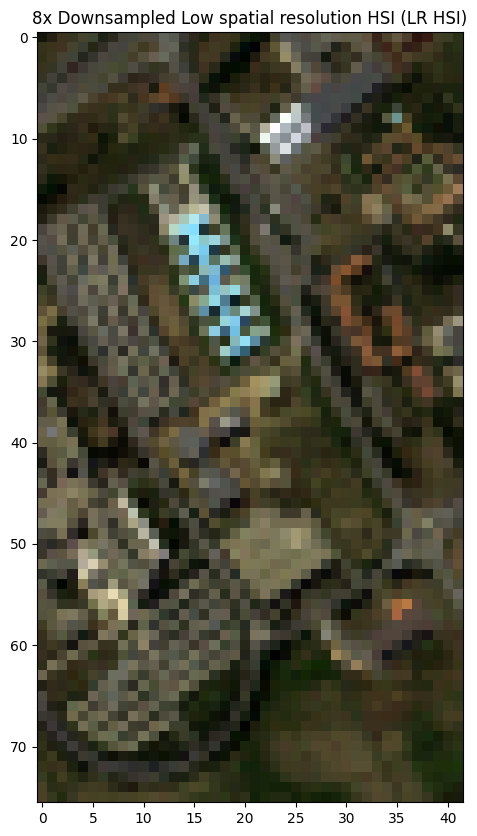

HSI shape with 16x Downsample:  (38, 21, 103)


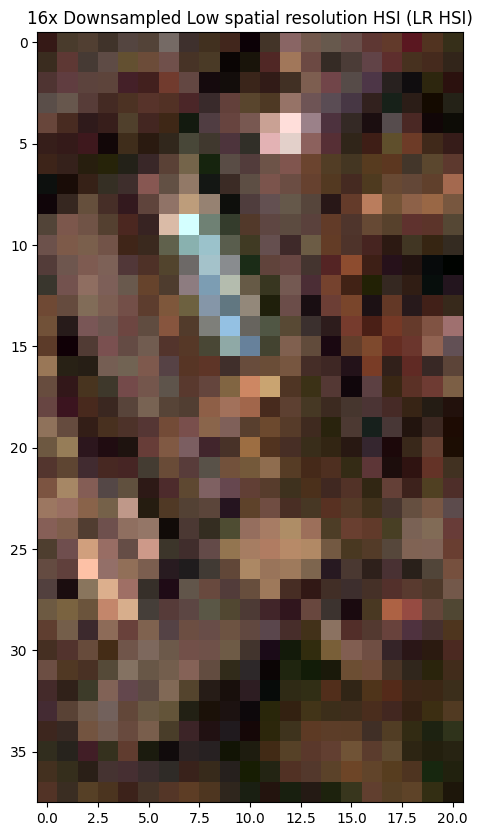

HSI shape with 32x Downsample:  (19, 10, 103)


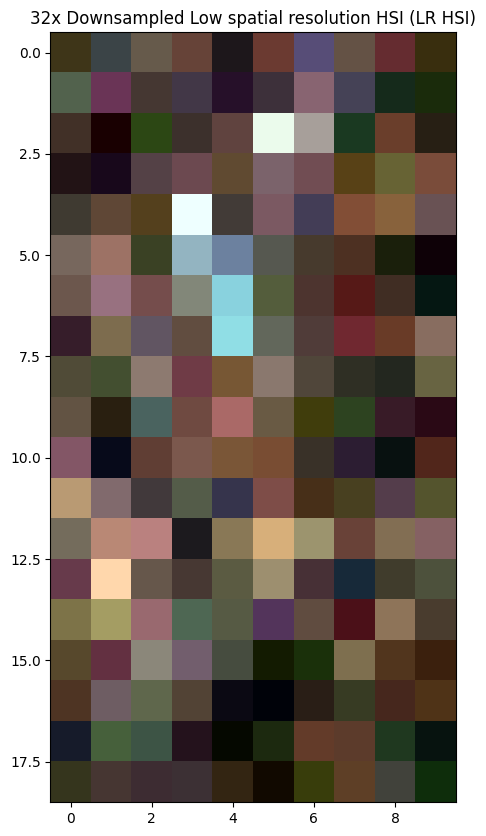

In [19]:
# Low Resolution HSI with 4x downsampling (H/4, W/4, C)
I_HS_4_delta = spatial_degradation(pavia_university_image, delta_psf, 4, 35)
print("HSI shape with 4x Downsample: ", I_HS_4_delta.shape)
visualize_hsi(I_HS_4_delta, (50,35,15), "4x Downsampled Low spatial resolution HSI (LR HSI)")

# Low Resolution HSI with 8x downsampling (H/8, W/8, C)
I_HS_8_delta = spatial_degradation(pavia_university_image, delta_psf, 8, 30)
print("HSI shape with 8x Downsample: ", I_HS_8_delta.shape)
visualize_hsi(I_HS_8_delta, (50,35,15), "8x Downsampled Low spatial resolution HSI (LR HSI)")

# Low Resolution HSI with 16x downsampling (H/16, W/16, C)
I_HS_16_delta = spatial_degradation(pavia_university_image, delta_psf, 16, 25)
print("HSI shape with 16x Downsample: ", I_HS_16_delta.shape)
visualize_hsi(I_HS_16_delta, (50,35,15), "16x Downsampled Low spatial resolution HSI (LR HSI)")

# Low Resolution HSI with 32x downsampling (H/32, W/32, C)
I_HS_32_delta = spatial_degradation(pavia_university_image, delta_psf, 32, 20)
print("HSI shape with 32x Downsample: ", I_HS_32_delta.shape)
visualize_hsi(I_HS_32_delta, (50,35,15), "32x Downsampled Low spatial resolution HSI (LR HSI)")

MIAE: Model Inspired Autoencoder for Unsupervised Hyperspectral Image Super-Resolution implementation from their GitHub

In [20]:
def get_flops_fvcore(model, inputs):
    """
    Estimate FLOPs and parameter count using fvcore.

    Parameters
    ----------
    model : torch.nn.Module
        Your model.
    inputs : tuple
        Tuple of input tensors (e.g., (pan, lms, ms)).

    Returns
    -------
    flops : str
        FLOPs in readable format.
    param_table : str
        Parameter count in table format.
    """
    model.eval()
    with torch.no_grad():
        flops = FlopCountAnalysis(model, inputs)
        flops_total = flops.total()
        params = parameter_count_table(model, max_depth=2)
    return flops_total, params

In [21]:
class BlurDown:
    def __init__(self, out_h, out_w, pad_mode='constant'):
        self.out_h = out_h
        self.out_w = out_w
        self.pad_mode = pad_mode  # 'constant', 'reflect', etc.

    def __call__(self, input_tensor: torch.Tensor, psf, pad, groups):
        """
        input_tensor: (N, C, H, W)
        psf:          (C, 1, kH, kW) or (1,1,kH,kW)
        pad:          integer for conv2d padding
        groups:       typically = C (each channel blurred individually)
        out_h, out_w: final desired spatial size
        """
        # 1) Repeat psf across channels if needed
        if psf.shape[0] == 1:
            psf = psf.repeat(groups, 1, 1, 1)

        # 2) Convolve with stride=1 => just blur
        blurred = fun.conv2d(input_tensor, psf, stride=1, padding=(pad, pad), groups=groups)

        # 3) Resize to (out_h, out_w). 
        out = fun.interpolate(blurred, size=(self.out_h, self.out_w), mode='bilinear')

        return out

In [22]:
class AENet(nn.Module):
    def __init__(self, hs_bands, ms_bands, edm_num, stage=3):
        super().__init__()
        self.hs_bands = hs_bands
        self.ms_bands = ms_bands
        self.edm_num = edm_num
        self.stage = stage
        self.module_list = nn.ModuleList([])
        edm = torch.ones([self.hs_bands, self.edm_num, 1, 1]) * (1.0 / self.edm_num)
        self.edm = nn.Parameter(edm)
        self.Y_net = nn.Sequential(
            nn.Conv2d(self.hs_bands, self.edm_num, (1, 1)),
            nn.LeakyReLU(0.2),
            nn.Conv2d(self.edm_num, self.edm_num, (1, 1)),
            nn.LeakyReLU(0.2)
        )
        self.Z_net = nn.Sequential(
            nn.Conv2d(self.ms_bands, self.edm_num, (1, 1)),
            nn.LeakyReLU(0.2)
        )
        self.S0_net = nn.Sequential(
            nn.Conv2d(2 * self.edm_num, self.edm_num, (1, 1)),
            nn.LeakyReLU(0.2)
        )
        for k in range(0, self.stage - 1):
            self.module_list.append(
                nn.Sequential(
                    nn.Conv2d(self.edm_num, self.edm_num, (1, 1)),
                    nn.LeakyReLU(0.2)
                )
            )
            self.module_list.append(
                nn.Sequential(
                    nn.Conv2d(3 * self.edm_num, self.edm_num, (1, 1)),
                    nn.LeakyReLU(0.2)
                )
            )
        self._init_weights(self)
        pass

    def forward(self, Yu, Z):
        N, B, H, W = Yu.shape
        N, b, H, W = Z.shape
        Y1 = self.Y_net(Yu)
        Z1 = self.Z_net(Z)
        S = torch.cat([Y1, Z1], dim=1)
        S = self.S0_net(S)
        for k in range(0, self.stage - 1):
            S = self.module_list[2 * k - 2](S)
            S = torch.cat([S, Y1, Z1], dim=1)
            S = self.module_list[2 * k - 1](S)
        S = torch.clamp(S, 0.0, 1.0)
        X = fun.conv2d(S, self.edm, None)
        X = torch.clamp(X, 0.0, 1.0)
        return X

    @staticmethod
    def _init_weights(model, init_type='normal'):
        for m in model.modules():
            if isinstance(m, nn.Conv2d):
                num_inputs = m.weight.data.shape[1]
                if init_type == 'normal':
                    nn.init.trunc_normal_(m.weight.data, mean=0.0, std=np.sqrt(1.0 / num_inputs))
                elif init_type == 'constant':
                    nn.init.constant_(m.weight.data, 1.0 / num_inputs)
                if hasattr(m, 'bias') and m.bias is not None:
                    nn.init.constant_(m.bias.data, 0.0)
        pass

In [23]:
class MIAE:
    def __init__(
        self,
        I_HS: np.ndarray,    # shape (h, w, L)
        I_MS: np.ndarray,    # shape (H, W, l)
        I_REF: np.ndarray,   # shape (H, W, L) or None
        psf: np.ndarray,     # shape (K, K)
        srf: np.ndarray,     # shape (l, L)
        ratio=8, 
        edm_num=80,
        stage=3
    ):
        """
        I_HS: low-res HSI
        I_MS: MSI
        I_REF: optional ground-truth for metrics
        psf:  PSF (K,K)
        srf:  SRF (l,L)
        ratio: upsampling factor
        edm_num, stage: architecture for AENet
        """

        # Convert input arrays to float32
        I_HS = I_HS.astype(np.float32)
        I_MS = I_MS.astype(np.float32)
        self.ref = I_REF.astype(np.float32) if I_REF is not None else None

        # Basic shapes
        self.h, self.w, self.hs_bands = I_HS.shape
        self.H, self.W, self.ms_bands = I_MS.shape
        self.ratio = ratio

        # Convert to Torch (channel-first)
        # => shape (1, L, h, w)
        self.hsi = torch.from_numpy(np.transpose(I_HS, (2,0,1))[None, ...])
        # => shape (1, l, H, W)
        self.msi = torch.from_numpy(np.transpose(I_MS, (2,0,1))[None, ...])

        # Upsample the HSI by ratio (bilinear), matching original code
        self.__hsi_up = nn.Upsample(size=(self.H, self.W), mode='bilinear', align_corners=False)(self.hsi)

        # Prepare PSF => (1,1,K,K), then replicate across L channels
        self.ker_size = psf.shape[0]
        self.psf = torch.tensor(psf[np.newaxis, np.newaxis, ...].astype(np.float32))
        self.psf_hs = self.psf.repeat(self.hs_bands, 1, 1, 1)  # => (L,1,K,K)

        # Prepare SRF => (l, L, 1,1)
        srf_4d = srf.astype(np.float32)[:, :, np.newaxis, np.newaxis]
        self.srf = torch.tensor(srf_4d)

        # Same hyperparams as original
        self.lr = 0.005
        self.lam_A, self.lam_B, self.lam_C = 1, 1, 1e-3

        # Build AENet
        self.model = AENet(self.hs_bands, self.ms_bands, edm_num, stage)

        # Move all to device
        self.__hsi    = self.hsi.float().to(device)
        self.__msi    = self.msi.float().to(device)
        self.__hsi_up = self.__hsi_up.float().to(device)
        self.psf_hs   = self.psf_hs.to(device)
        self.srf      = self.srf.to(device)
        self.model    = self.model.to(device)

        # Adam optimizer with weight decay = lam_C
        self.optimizer = optim.Adam(self.model.parameters(), lr=self.lr, weight_decay=self.lam_C)
        # Original code uses a LambdaLR:
        self.lr_fun = lambda epoch: (1.0 - max(0, epoch + 1 - 1000) / 9000)
        self.scheduler = optim.lr_scheduler.LambdaLR(self.optimizer, self.lr_fun)

        # Patch training parameters
        self.patch_size   = 5 * self.ratio
        self.patch_stride = 3 * self.ratio
        self.batch_size   = self.set_batch_size()

        # Border cut
        self.hs_border = math.ceil((self.ker_size - 1) / 2 / self.ratio)
        self.ms_border = self.hs_border * self.ratio

        # The blur-down object for cpt_target
        self.blur_down = BlurDown(out_h=self.h, out_w=self.w)

    def set_batch_size(self):
        """
        Same logic as the original set_batch_size function:
        if ratio==8 => base=25, etc., and multiply by (H//512)*(W//256).
        """
        batch_size = 100
        if self.ratio == 4:
            batch_size = 100
        elif self.ratio == 8:
            batch_size = 25
        elif self.ratio == 16:
            batch_size = 5
        factor = (self.H // 512) * (self.W // 256)
        factor = max(factor, 1)  # ensure not zero
        return batch_size * factor

    def cpt_target(self, X):
        """
        Spatial degrade: blur + downsample => Y
        Spectral degrade: conv with srf => Z
        Compare (Y,Z) to (lrHSI, MSI) in build_loss
        """
        # => Y
        pad = int((self.ker_size - 1) / 2)
        Y = self.blur_down(
            input_tensor=X,
            psf=self.psf_hs,
            pad=int((self.ker_size-1)//2),
            groups=self.hs_bands
        )
                # => Z
        Z = fun.conv2d(X, self.srf, None)
        return Y, Z

    def build_loss(self, Y, Z, hsi, msi):
        """
        L1 difference, ignoring border. Weighted by lam_A, lam_B.
        """
        
        dY = Y - hsi
        dZ = Z - msi
        dY = dY[:, :, self.hs_border:-self.hs_border, self.hs_border:-self.hs_border]
        dZ = dZ[:, :, self.ms_border:-self.ms_border, self.ms_border:-self.ms_border]

        loss_spatial = torch.sum(torch.mean(torch.abs(dY), dim=(2,3))) * ((self.H/self.ratio)*(self.W/self.ratio))
        loss_spectral = torch.sum(torch.mean(torch.abs(dZ), dim=(2,3))) * (self.H*self.W)
        return self.lam_A*loss_spatial + self.lam_B*loss_spectral

    def train_all(self, max_iter=10000, verb=True):
        """
        Alternative training with the entire image each iteration (no patches).
        Use a tqdm progress bar to track progress.
        """
        t_start = time.perf_counter()
        hsi = self.__hsi.to(device)
        msi = self.__msi.to(device)
        hsi_up = self.__hsi_up.to(device)
        self.model.train()

        # Create a tqdm bar that goes from 0 to max_iter
        pbar = tqdm(range(max_iter), desc="Training (no patches)", ncols=80)
        for epoch in pbar:
            X = self.model(hsi_up, msi)
            Yhat, Zhat = self.cpt_target(X)
            loss = self.build_loss(Yhat, Zhat, hsi, msi)

            self.optimizer.zero_grad()
            loss.backward()
            self.optimizer.step()
            self.model.edm.data.clamp_(0.0, 1.0)

            # Update the progress bar's postfix to show current loss
            pbar.set_postfix(loss=f"{loss.item():.4f}")

            self.scheduler.step()

        pbar.close()  # close the progress bar
        train_time = time.perf_counter() - t_start
        print(f"Train_all done in {train_time:.2f}s")
        
    def get_super_resolved(self):
        """
        Obtain the final super-resolved HSI (H,W,L) as a NumPy array.
        Also calculate FLOPs, number of parameters, GPU memory consumed, and inference time.
        """
        self.model.eval()
        
        # Determine the device (GPU if available, otherwise CPU)
        device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
        
        # Number of parameters
        num_params = sum(p.numel() for p in self.model.parameters() if p.requires_grad)
        
        # FLOPs using fvcore
        inputs = (self.__hsi_up.to(device), self.__msi.to(device))
        flops, param_table = get_flops_fvcore(self.model, inputs)
        
        # Measure GPU memory and inference time
        torch.cuda.empty_cache()
        torch.cuda.reset_peak_memory_stats(device)
        start_memory = torch.cuda.max_memory_allocated(device)
        
        with torch.no_grad():
            # Measure inference time
            start_time = time.time()
            X = self.model(self.__hsi_up.to(device), self.__msi.to(device))
            end_time = time.time()
            
        end_memory = torch.cuda.max_memory_allocated(device)
        inference_time = end_time - start_time
        gpu_memory_used = end_memory - start_memory
        
        # Shape (1, L, H, W) => (L, H, W) => (H, W, L)
        X_np = X[0].cpu().numpy()
        X_np = np.transpose(X_np, (1, 2, 0))
        
        # Print metrics
        print(f"Number of parameters: {num_params}")
        print(f"FLOPs: {flops}")
        print(f"GPU memory consumed: {gpu_memory_used / (1024 ** 2):.2f} MB")
        print(f"Inference time: {inference_time:.4f} seconds")
        
        return X_np

Output file to save super-resolved images

In [24]:
# Get the current working directory
notebook_directory = os.getcwd()

# Define the relative path to the target directory
target_relative_path = "../../../Super_Resolved_Images_From_Comparison_Implementations/MIAE"

# Construct the full path to the target directory
target_path = os.path.join(notebook_directory, target_relative_path)

# Normalize the path to remove redundancies
normalized_target_path = os.path.normpath(target_path)

# Define the path to the MIAE folder
pavia_u_miae_folder_path = os.path.join(normalized_target_path, 'Pavia_University')

# Create the MIAE folder if it doesn't exist
if not os.path.exists(pavia_u_miae_folder_path):
    os.makedirs(pavia_u_miae_folder_path)

In [25]:
def split_image(image, split_index):
    return image[:split_index], image[split_index:]

def extract_part_to_save(image):
    image = image[:608, :320, :]
    _, image = split_image(image, 480)
    return image

## Super Resolving HSI degraded with Gaussian PSF

In [26]:
# Creating sub folder within which to save the super resolved images from Gaussian PSF degraded HSI
pavia_u_miae_gaus_folder_path = os.path.join(pavia_u_miae_folder_path, 'Gaussian_PSF')

# Create the Gaussian sub folder if it doesn't exist
if not os.path.exists(pavia_u_miae_gaus_folder_path):
    os.makedirs(pavia_u_miae_gaus_folder_path)

Running MIAE on Pavia University LR HSI with 4x Downsampling and 4 band MSI

In [27]:
ratio = 4
stage = 3
edm_num = 80

# Create the MIAE object
net = MIAE(
    I_HS=I_HS_4_gaus,
    I_MS=I_MS_4,
    I_REF=None,  # or None
    psf=gaus_psf,
    srf=srf_4,
    ratio=ratio,
    edm_num=edm_num,
    stage=stage
)

# Train 
net.train_all(max_iter=5000, verb=True)

# Then, after training is done, obtain final super-resolved image:
SR_image = net.get_super_resolved()  # shape (H, W, L) as a float32 numpy

# Saving only part of the image to ensure consistency with other methods
SR_image = extract_part_to_save(SR_image)

# Full file path (including the file name and extension)
file_path = f"{pavia_u_miae_gaus_folder_path}/SR_Pavia_U_gaussian_4x_4_bands.npy"

# Save the super resolved images to the specified location
np.save(file_path, SR_image)

print("Saved 4x super resolved image from 4 band MSI at location specified in pavia_u_miae_gaus_folder_path")

Training (no patches): 100%|█| 5000/5000 [01:41<00:00, 49.44it/s, loss=9623.9873
Unsupported operator aten::leaky_relu encountered 8 time(s)


Train_all done in 101.14s
Number of parameters: 87840
FLOPs: 18085280000
GPU memory consumed: 446.00 MB
Inference time: 0.0065 seconds
Saved 4x super resolved image from 4 band MSI at location specified in pavia_u_miae_gaus_folder_path


Running MIAE on Pavia University LR HSI with 8x Downsampling and 4 band MSI

In [28]:
ratio = 8
stage = 3
edm_num = 80

# Create the MIAE object
net = MIAE(
    I_HS=I_HS_8_gaus,
    I_MS=I_MS_4,
    I_REF=None,  # or None
    psf=gaus_psf,
    srf=srf_4,
    ratio=ratio,
    edm_num=edm_num,
    stage=stage
)

# Train 
net.train_all(max_iter=5000, verb=True)

# Then, after training is done, obtain final super-resolved image:
SR_image = net.get_super_resolved()  # shape (H, W, L) as a float32 numpy

# Saving only part of the image to ensure consistency with other methods
SR_image = extract_part_to_save(SR_image)

# Full file path (including the file name and extension)
file_path = f"{pavia_u_miae_gaus_folder_path}/SR_Pavia_U_gaussian_8x_4_bands.npy"

# Save the super resolved images to the specified location
np.save(file_path, SR_image)

print("Saved 8x super resolved image from 4 band MSI at location specified in pavia_u_miae_gaus_folder_path")

Training (no patches): 100%|█| 5000/5000 [01:39<00:00, 50.12it/s, loss=5426.6270
Unsupported operator aten::leaky_relu encountered 8 time(s)


Train_all done in 99.77s
Number of parameters: 87840
FLOPs: 18085280000
GPU memory consumed: 446.00 MB
Inference time: 0.0066 seconds
Saved 8x super resolved image from 4 band MSI at location specified in pavia_u_miae_gaus_folder_path


Running MIAE on Pavia University LR HSI with 16x Downsampling and 4 band MSI

In [29]:
ratio = 16
stage = 3
edm_num = 80

# Create the MIAE object
net = MIAE(
    I_HS=I_HS_16_gaus,
    I_MS=I_MS_4,
    I_REF=None,  # or None
    psf=gaus_psf,
    srf=srf_4,
    ratio=ratio,
    edm_num=edm_num,
    stage=stage
)

# Train 
net.train_all(max_iter=5000, verb=True)

# Then, after training is done, obtain final super-resolved image:
SR_image = net.get_super_resolved()  # shape (H, W, L) as a float32 numpy

# Saving only part of the image to ensure consistency with other methods
SR_image = extract_part_to_save(SR_image)

# Full file path (including the file name and extension)
file_path = f"{pavia_u_miae_gaus_folder_path}/SR_Pavia_U_gaussian_16x_4_bands.npy"

# Save the super resolved images to the specified location
np.save(file_path, SR_image)

print("Saved 16x super resolved image from 4 band MSI at location specified in pavia_u_miae_gaus_folder_path")

Training (no patches): 100%|█| 5000/5000 [01:39<00:00, 50.26it/s, loss=4019.4668
Unsupported operator aten::leaky_relu encountered 8 time(s)


Train_all done in 99.48s
Number of parameters: 87840
FLOPs: 18085280000
GPU memory consumed: 446.00 MB
Inference time: 0.0067 seconds
Saved 16x super resolved image from 4 band MSI at location specified in pavia_u_miae_gaus_folder_path


Running MIAE on Pavia University LR HSI with 32x Downsampling and 4 band MSI

In [30]:
ratio = 32
stage = 3
edm_num = 80

# Create the MIAE object
net = MIAE(
    I_HS=I_HS_32_gaus,
    I_MS=I_MS_4,
    I_REF=None,  # or None
    psf=gaus_psf,
    srf=srf_4,
    ratio=ratio,
    edm_num=edm_num,
    stage=stage
)

# Train 
net.train_all(max_iter=5000, verb=True)

# Then, after training is done, obtain final super-resolved image:
SR_image = net.get_super_resolved()  # shape (H, W, L) as a float32 numpy

# Saving only part of the image to ensure consistency with other methods
SR_image = extract_part_to_save(SR_image)

# Full file path (including the file name and extension)
file_path = f"{pavia_u_miae_gaus_folder_path}/SR_Pavia_U_gaussian_32x_4_bands.npy"

# Save the super resolved images to the specified location
np.save(file_path, SR_image)

print("Saved 32x super resolved image from 4 band MSI at location specified in pavia_u_miae_gaus_folder_path")

Training (no patches): 100%|█| 5000/5000 [01:39<00:00, 50.41it/s, loss=2714.0244
Unsupported operator aten::leaky_relu encountered 8 time(s)


Train_all done in 99.18s
Number of parameters: 87840
FLOPs: 18085280000
GPU memory consumed: 446.00 MB
Inference time: 0.0068 seconds
Saved 32x super resolved image from 4 band MSI at location specified in pavia_u_miae_gaus_folder_path


Running MIAE on Pavia University LR HSI with 8x Downsampling and 1 band Pan image

In [31]:
ratio = 8
stage = 3
edm_num = 80

# Create the MIAE object
net = MIAE(
    I_HS=I_HS_8_gaus,
    I_MS=I_MS_1,
    I_REF=None,  # or None
    psf=gaus_psf,
    srf=srf_1,
    ratio=ratio,
    edm_num=edm_num,
    stage=stage
)

# Train 
net.train_all(max_iter=5000, verb=True)

# Then, after training is done, obtain final super-resolved image:
SR_image = net.get_super_resolved()  # shape (H, W, L) as a float32 numpy

# Saving only part of the image to ensure consistency with other methods
SR_image = extract_part_to_save(SR_image)

# Full file path (including the file name and extension)
file_path = f"{pavia_u_miae_gaus_folder_path}/SR_Pavia_U_gaussian_8x_1_band.npy"

# Save the super resolved images to the specified location
np.save(file_path, SR_image)

print("Saved 8x super resolved image from 1 band Pan image at location specified in pavia_u_miae_gaus_folder_path")

Training (no patches): 100%|█| 5000/5000 [01:40<00:00, 49.86it/s, loss=4495.1489
Unsupported operator aten::leaky_relu encountered 8 time(s)


Train_all done in 100.28s
Number of parameters: 87600
FLOPs: 18035504000
GPU memory consumed: 446.00 MB
Inference time: 0.0065 seconds
Saved 8x super resolved image from 1 band Pan image at location specified in pavia_u_miae_gaus_folder_path


Running MIAE on Pavia University LR HSI with 8x Downsampling and 3 band RGB image

In [32]:
ratio = 8
stage = 3
edm_num = 80

# Create the MIAE object
net = MIAE(
    I_HS=I_HS_8_gaus,
    I_MS=I_MS_3,
    I_REF=None,  # or None
    psf=gaus_psf,
    srf=srf_3,
    ratio=ratio,
    edm_num=edm_num,
    stage=stage
)

# Train 
net.train_all(max_iter=5000, verb=True)

# Then, after training is done, obtain final super-resolved image:
SR_image = net.get_super_resolved()  # shape (H, W, L) as a float32 numpy

# Saving only part of the image to ensure consistency with other methods
SR_image = extract_part_to_save(SR_image)

# Full file path (including the file name and extension)
file_path = f"{pavia_u_miae_gaus_folder_path}/SR_Pavia_U_gaussian_8x_3_bands.npy"

# Save the super resolved images to the specified location
np.save(file_path, SR_image)

print("Saved 8x super resolved image from 3 band RGB image at location specified in pavia_u_miae_gaus_folder_path")

Training (no patches): 100%|█| 5000/5000 [01:39<00:00, 50.12it/s, loss=5644.0342
Unsupported operator aten::leaky_relu encountered 8 time(s)


Train_all done in 99.76s
Number of parameters: 87760
FLOPs: 18068688000
GPU memory consumed: 446.00 MB
Inference time: 0.0068 seconds
Saved 8x super resolved image from 3 band RGB image at location specified in pavia_u_miae_gaus_folder_path


Running MIAE on Pavia University LR HSI with 8x Downsampling and 8 band MSI

In [33]:
ratio = 8
stage = 3
edm_num = 80

# Create the MIAE object
net = MIAE(
    I_HS=I_HS_8_gaus,
    I_MS=I_MS_8,
    I_REF=None,  # or None
    psf=gaus_psf,
    srf=srf_8,
    ratio=ratio,
    edm_num=edm_num,
    stage=stage
)

# Train 
net.train_all(max_iter=5000, verb=True)

# Then, after training is done, obtain final super-resolved image:
SR_image = net.get_super_resolved()  # shape (H, W, L) as a float32 numpy

# Saving only part of the image to ensure consistency with other methods
SR_image = extract_part_to_save(SR_image)

# Full file path (including the file name and extension)
file_path = f"{pavia_u_miae_gaus_folder_path}/SR_Pavia_U_gaussian_8x_8_bands.npy"

# Save the super resolved images to the specified location
np.save(file_path, SR_image)

print("Saved 8x super resolved image from 8 band MSI at location specified in pavia_u_miae_gaus_folder_path")

Training (no patches): 100%|█| 5000/5000 [01:40<00:00, 49.93it/s, loss=7789.3350
Unsupported operator aten::leaky_relu encountered 8 time(s)


Train_all done in 100.14s
Number of parameters: 88160
FLOPs: 18151648000
GPU memory consumed: 446.00 MB
Inference time: 0.0067 seconds
Saved 8x super resolved image from 8 band MSI at location specified in pavia_u_miae_gaus_folder_path


Running MIAE on Pavia University LR HSI with 8x Downsampling and 16 band MSI

In [34]:
ratio = 8
stage = 3
edm_num = 80

# Create the MIAE object
net = MIAE(
    I_HS=I_HS_8_gaus,
    I_MS=I_MS_16,
    I_REF=None,  # or None
    psf=gaus_psf,
    srf=srf_16,
    ratio=ratio,
    edm_num=edm_num,
    stage=stage
)

# Train 
net.train_all(max_iter=5000, verb=True)

# Then, after training is done, obtain final super-resolved image:
SR_image = net.get_super_resolved()  # shape (H, W, L) as a float32 numpy

# Saving only part of the image to ensure consistency with other methods
SR_image = extract_part_to_save(SR_image)

# Full file path (including the file name and extension)
file_path = f"{pavia_u_miae_gaus_folder_path}/SR_Pavia_U_gaussian_8x_16_bands.npy"

# Save the super resolved images to the specified location
np.save(file_path, SR_image)

print("Saved 8x super resolved image from 16 band MSI at location specified in pavia_u_miae_gaus_folder_path")

Training (no patches): 100%|█| 5000/5000 [01:41<00:00, 49.46it/s, loss=11444.746
Unsupported operator aten::leaky_relu encountered 8 time(s)


Train_all done in 101.10s
Number of parameters: 88800
FLOPs: 18284384000
GPU memory consumed: 445.29 MB
Inference time: 0.0057 seconds
Saved 8x super resolved image from 16 band MSI at location specified in pavia_u_miae_gaus_folder_path


## Super Resolving HSI degraded with Kolmogorov HSI

In [35]:
# Creating sub folder within which to save the super resolved images from Kolmogorov PSF degraded HSI
pavia_u_miae_kol_folder_path = os.path.join(pavia_u_miae_folder_path, 'Kolmogorov_PSF')

# Create the Gaussian sub folder if it doesn't exist
if not os.path.exists(pavia_u_miae_kol_folder_path):
    os.makedirs(pavia_u_miae_kol_folder_path)

Running MIAE on Pavia University LR HSI with 4x Downsampling and 4 band MSI

In [36]:
ratio = 4
stage = 3
edm_num = 80

# Create the MIAE object
net = MIAE(
    I_HS=I_HS_4_kol,
    I_MS=I_MS_4,
    I_REF=None,  # or None
    psf=kol_psf,
    srf=srf_4,
    ratio=ratio,
    edm_num=edm_num,
    stage=stage
)

# Train 
net.train_all(max_iter=5000, verb=True)

# Then, after training is done, obtain final super-resolved image:
SR_image = net.get_super_resolved()  # shape (H, W, L) as a float32 numpy

# Saving only part of the image to ensure consistency with other methods
SR_image = extract_part_to_save(SR_image)

# Full file path (including the file name and extension)
file_path = f"{pavia_u_miae_kol_folder_path}/SR_Pavia_U_kolmogorov_4x_4_bands.npy"

# Save the super resolved images to the specified location
np.save(file_path, SR_image)

print("Saved 8x super resolved image from 4 band MSI at location specified in pavia_u_miae_kol_folder_path")

Training (no patches): 100%|█| 5000/5000 [01:40<00:00, 49.79it/s, loss=10300.638
Unsupported operator aten::leaky_relu encountered 8 time(s)


Train_all done in 100.42s
Number of parameters: 87840
FLOPs: 18085280000
GPU memory consumed: 446.00 MB
Inference time: 0.0058 seconds
Saved 8x super resolved image from 4 band MSI at location specified in pavia_u_miae_kol_folder_path


Running MIAE on Pavia University LR HSI with 8x Downsampling and 4 band MSI

In [37]:
ratio = 8
stage = 3
edm_num = 80

# Create the MIAE object
net = MIAE(
    I_HS=I_HS_8_kol,
    I_MS=I_MS_4,
    I_REF=None,  # or None
    psf=kol_psf,
    srf=srf_4,
    ratio=ratio,
    edm_num=edm_num,
    stage=stage
)

# Train 
net.train_all(max_iter=5000, verb=True)

# Then, after training is done, obtain final super-resolved image:
SR_image = net.get_super_resolved()  # shape (H, W, L) as a float32 numpy

# Saving only part of the image to ensure consistency with other methods
SR_image = extract_part_to_save(SR_image)

# Full file path (including the file name and extension)
file_path = f"{pavia_u_miae_kol_folder_path}/SR_Pavia_U_kolmogorov_8x_4_bands.npy"

# Save the super resolved images to the specified location
np.save(file_path, SR_image)

print("Saved 8x super resolved image from 4 band MSI at location specified in pavia_u_miae_kol_folder_path")

Training (no patches): 100%|█| 5000/5000 [01:39<00:00, 50.14it/s, loss=6361.6494
Unsupported operator aten::leaky_relu encountered 8 time(s)


Train_all done in 99.73s
Number of parameters: 87840
FLOPs: 18085280000
GPU memory consumed: 446.00 MB
Inference time: 0.0067 seconds
Saved 8x super resolved image from 4 band MSI at location specified in pavia_u_miae_kol_folder_path


Running MIAE on Pavia University LR HSI with 16x Downsampling and 4 band MSI

In [38]:
ratio = 16
stage = 3
edm_num = 80

# Create the MIAE object
net = MIAE(
    I_HS=I_HS_16_kol,
    I_MS=I_MS_4,
    I_REF=None,  # or None
    psf=kol_psf,
    srf=srf_4,
    ratio=ratio,
    edm_num=edm_num,
    stage=stage
)

# Train 
net.train_all(max_iter=5000, verb=True)

# Then, after training is done, obtain final super-resolved image:
SR_image = net.get_super_resolved()  # shape (H, W, L) as a float32 numpy

# Saving only part of the image to ensure consistency with other methods
SR_image = extract_part_to_save(SR_image)

# Full file path (including the file name and extension)
file_path = f"{pavia_u_miae_kol_folder_path}/SR_Pavia_U_kolmogorov_16x_4_bands.npy"

# Save the super resolved images to the specified location
np.save(file_path, SR_image)

print("Saved 8x super resolved image from 4 band MSI at location specified in pavia_u_miae_kol_folder_path")

Training (no patches): 100%|█| 5000/5000 [01:39<00:00, 50.25it/s, loss=4267.7188
Unsupported operator aten::leaky_relu encountered 8 time(s)


Train_all done in 99.50s
Number of parameters: 87840
FLOPs: 18085280000
GPU memory consumed: 446.00 MB
Inference time: 0.0068 seconds
Saved 8x super resolved image from 4 band MSI at location specified in pavia_u_miae_kol_folder_path


Running MIAE on Pavia University LR HSI with 32x Downsampling and 4 band MSI

In [39]:
ratio = 32
stage = 3
edm_num = 80

# Create the MIAE object
net = MIAE(
    I_HS=I_HS_32_kol,
    I_MS=I_MS_4,
    I_REF=None,  # or None
    psf=kol_psf,
    srf=srf_4,
    ratio=ratio,
    edm_num=edm_num,
    stage=stage
)

# Train 
net.train_all(max_iter=5000, verb=True)

# Then, after training is done, obtain final super-resolved image:
SR_image = net.get_super_resolved()  # shape (H, W, L) as a float32 numpy

# Saving only part of the image to ensure consistency with other methods
SR_image = extract_part_to_save(SR_image)

# Full file path (including the file name and extension)
file_path = f"{pavia_u_miae_kol_folder_path}/SR_Pavia_U_kolmogorov_32x_4_bands.npy"

# Save the super resolved images to the specified location
np.save(file_path, SR_image)

print("Saved 8x super resolved image from 4 band MSI at location specified in pavia_u_miae_kol_folder_path")

Training (no patches): 100%|█| 5000/5000 [01:39<00:00, 50.47it/s, loss=3123.0737
Unsupported operator aten::leaky_relu encountered 8 time(s)


Train_all done in 99.08s
Number of parameters: 87840
FLOPs: 18085280000
GPU memory consumed: 446.00 MB
Inference time: 0.0067 seconds
Saved 8x super resolved image from 4 band MSI at location specified in pavia_u_miae_kol_folder_path


Running MIAE on Pavia University LR HSI with 8x Downsampling and 1 band Pan image

In [40]:
ratio = 8
stage = 3
edm_num = 80

# Create the MIAE object
net = MIAE(
    I_HS=I_HS_8_kol,
    I_MS=I_MS_1,
    I_REF=None,  # or None
    psf=kol_psf,
    srf=srf_1,
    ratio=ratio,
    edm_num=edm_num,
    stage=stage
)

# Train 
net.train_all(max_iter=5000, verb=True)

# Then, after training is done, obtain final super-resolved image:
SR_image = net.get_super_resolved()  # shape (H, W, L) as a float32 numpy

# Saving only part of the image to ensure consistency with other methods
SR_image = extract_part_to_save(SR_image)

# Full file path (including the file name and extension)
file_path = f"{pavia_u_miae_kol_folder_path}/SR_Pavia_U_kolmogorov_8x_1_band.npy"

# Save the super resolved images to the specified location
np.save(file_path, SR_image)

print("Saved 8x super resolved image from 4 band MSI at location specified in pavia_u_miae_kol_folder_path")

Training (no patches): 100%|█| 5000/5000 [01:40<00:00, 49.93it/s, loss=5180.0522
Unsupported operator aten::leaky_relu encountered 8 time(s)


Train_all done in 100.15s
Number of parameters: 87600
FLOPs: 18035504000
GPU memory consumed: 446.00 MB
Inference time: 0.0065 seconds
Saved 8x super resolved image from 4 band MSI at location specified in pavia_u_miae_kol_folder_path


Running MIAE on Pavia University LR HSI with 8x Downsampling and 3 band RGB image

In [41]:
ratio = 8
stage = 3
edm_num = 80

# Create the MIAE object
net = MIAE(
    I_HS=I_HS_8_kol,
    I_MS=I_MS_3,
    I_REF=None,  # or None
    psf=kol_psf,
    srf=srf_3,
    ratio=ratio,
    edm_num=edm_num,
    stage=stage
)

# Train 
net.train_all(max_iter=5000, verb=True)

# Then, after training is done, obtain final super-resolved image:
SR_image = net.get_super_resolved()  # shape (H, W, L) as a float32 numpy

# Saving only part of the image to ensure consistency with other methods
SR_image = extract_part_to_save(SR_image)

# Full file path (including the file name and extension)
file_path = f"{pavia_u_miae_kol_folder_path}/SR_Pavia_U_kolmogorov_8x_3_bands.npy"

# Save the super resolved images to the specified location
np.save(file_path, SR_image)

print("Saved 8x super resolved image from 4 band MSI at location specified in pavia_u_miae_kol_folder_path")

Training (no patches): 100%|█| 5000/5000 [01:39<00:00, 50.12it/s, loss=6433.3364
Unsupported operator aten::leaky_relu encountered 8 time(s)


Train_all done in 99.77s
Number of parameters: 87760
FLOPs: 18068688000
GPU memory consumed: 446.00 MB
Inference time: 0.0243 seconds
Saved 8x super resolved image from 4 band MSI at location specified in pavia_u_miae_kol_folder_path


Running MIAE on Pavia University LR HSI with 8x Downsampling and 8 band MSI

In [42]:
ratio = 8
stage = 3
edm_num = 80

# Create the MIAE object
net = MIAE(
    I_HS=I_HS_8_kol,
    I_MS=I_MS_8,
    I_REF=None,  # or None
    psf=kol_psf,
    srf=srf_8,
    ratio=ratio,
    edm_num=edm_num,
    stage=stage
)

# Train 
net.train_all(max_iter=5000, verb=True)

# Then, after training is done, obtain final super-resolved image:
SR_image = net.get_super_resolved()  # shape (H, W, L) as a float32 numpy

# Saving only part of the image to ensure consistency with other methods
SR_image = extract_part_to_save(SR_image)

# Full file path (including the file name and extension)
file_path = f"{pavia_u_miae_kol_folder_path}/SR_Pavia_U_kolmogorov_8x_8_bands.npy"

# Save the super resolved images to the specified location
np.save(file_path, SR_image)

print("Saved 8x super resolved image from 4 band MSI at location specified in pavia_u_miae_kol_folder_path")

Training (no patches): 100%|█| 5000/5000 [01:40<00:00, 49.93it/s, loss=10567.830
Unsupported operator aten::leaky_relu encountered 8 time(s)


Train_all done in 100.15s
Number of parameters: 88160
FLOPs: 18151648000
GPU memory consumed: 446.00 MB
Inference time: 0.0065 seconds
Saved 8x super resolved image from 4 band MSI at location specified in pavia_u_miae_kol_folder_path


Running MIAE on Pavia University LR HSI with 8x Downsampling and 16 band MSI

In [43]:
ratio = 8
stage = 3
edm_num = 80

# Create the MIAE object
net = MIAE(
    I_HS=I_HS_8_kol,
    I_MS=I_MS_16,
    I_REF=None,  # or None
    psf=kol_psf,
    srf=srf_16,
    ratio=ratio,
    edm_num=edm_num,
    stage=stage
)

# Train 
net.train_all(max_iter=5000, verb=True)

# Then, after training is done, obtain final super-resolved image:
SR_image = net.get_super_resolved()  # shape (H, W, L) as a float32 numpy

# Saving only part of the image to ensure consistency with other methods
SR_image = extract_part_to_save(SR_image)

# Full file path (including the file name and extension)
file_path = f"{pavia_u_miae_kol_folder_path}/SR_Pavia_U_kolmogorov_8x_16_bands.npy"

# Save the super resolved images to the specified location
np.save(file_path, SR_image)

print("Saved 8x super resolved image from 4 band MSI at location specified in pavia_u_miae_kol_folder_path")

Training (no patches): 100%|█| 5000/5000 [01:41<00:00, 49.42it/s, loss=33900.500
Unsupported operator aten::leaky_relu encountered 8 time(s)


Train_all done in 101.18s
Number of parameters: 88800
FLOPs: 18284384000
GPU memory consumed: 445.29 MB
Inference time: 0.0057 seconds
Saved 8x super resolved image from 4 band MSI at location specified in pavia_u_miae_kol_folder_path


## Super Resolving HSI degraded with Airy HSI

In [44]:
# Creating sub folder within which to save the super resolved images from Airy PSF degraded HSI
pavia_u_miae_air_folder_path = os.path.join(pavia_u_miae_folder_path, 'Airy_PSF')

# Create the Gaussian sub folder if it doesn't exist
if not os.path.exists(pavia_u_miae_air_folder_path):
    os.makedirs(pavia_u_miae_air_folder_path)

Running MIAE on Pavia University LR HSI with 4x Downsampling and 4 band MSI

In [45]:
ratio = 4
stage = 3
edm_num = 80

# Create the MIAE object
net = MIAE(
    I_HS=I_HS_4_air,
    I_MS=I_MS_4,
    I_REF=None,  # or None
    psf=air_psf,
    srf=srf_4,
    ratio=ratio,
    edm_num=edm_num,
    stage=stage
)

# Train 
net.train_all(max_iter=5000, verb=True)

# Then, after training is done, obtain final super-resolved image:
SR_image = net.get_super_resolved()  # shape (H, W, L) as a float32 numpy

# Saving only part of the image to ensure consistency with other methods
SR_image = extract_part_to_save(SR_image)

# Full file path (including the file name and extension)
file_path = f"{pavia_u_miae_air_folder_path}/SR_Pavia_U_airy_4x_4_bands.npy"

# Save the super resolved images to the specified location
np.save(file_path, SR_image)

print("Saved 8x super resolved image from 4 band MSI at location specified in pavia_u_miae_air_folder_path")

Training (no patches): 100%|█| 5000/5000 [01:40<00:00, 49.82it/s, loss=20647.548
Unsupported operator aten::leaky_relu encountered 8 time(s)


Train_all done in 100.35s
Number of parameters: 87840
FLOPs: 18085280000
GPU memory consumed: 446.00 MB
Inference time: 0.0067 seconds
Saved 8x super resolved image from 4 band MSI at location specified in pavia_u_miae_air_folder_path


Running MIAE on Pavia University LR HSI with 8x Downsampling and 4 band MSI

In [46]:
ratio = 8
stage = 3
edm_num = 80

# Create the MIAE object
net = MIAE(
    I_HS=I_HS_8_air,
    I_MS=I_MS_4,
    I_REF=None,  # or None
    psf=air_psf,
    srf=srf_4,
    ratio=ratio,
    edm_num=edm_num,
    stage=stage
)

# Train 
net.train_all(max_iter=5000, verb=True)

# Then, after training is done, obtain final super-resolved image:
SR_image = net.get_super_resolved()  # shape (H, W, L) as a float32 numpy

# Saving only part of the image to ensure consistency with other methods
SR_image = extract_part_to_save(SR_image)

# Full file path (including the file name and extension)
file_path = f"{pavia_u_miae_air_folder_path}/SR_Pavia_U_airy_8x_4_bands.npy"

# Save the super resolved images to the specified location
np.save(file_path, SR_image)

print("Saved 8x super resolved image from 4 band MSI at location specified in pavia_u_miae_air_folder_path")

Training (no patches): 100%|█| 5000/5000 [01:39<00:00, 50.18it/s, loss=13272.390
Unsupported operator aten::leaky_relu encountered 8 time(s)


Train_all done in 99.64s
Number of parameters: 87840
FLOPs: 18085280000
GPU memory consumed: 446.00 MB
Inference time: 0.0066 seconds
Saved 8x super resolved image from 4 band MSI at location specified in pavia_u_miae_air_folder_path


Running MIAE on Pavia University LR HSI with 16x Downsampling and 4 band MSI

In [47]:
ratio = 16
stage = 3
edm_num = 80

# Create the MIAE object
net = MIAE(
    I_HS=I_HS_16_air,
    I_MS=I_MS_4,
    I_REF=None,  # or None
    psf=air_psf,
    srf=srf_4,
    ratio=ratio,
    edm_num=edm_num,
    stage=stage
)

# Train 
net.train_all(max_iter=5000, verb=True)

# Then, after training is done, obtain final super-resolved image:
SR_image = net.get_super_resolved()  # shape (H, W, L) as a float32 numpy

# Saving only part of the image to ensure consistency with other methods
SR_image = extract_part_to_save(SR_image)

# Full file path (including the file name and extension)
file_path = f"{pavia_u_miae_air_folder_path}/SR_Pavia_U_airy_16x_4_bands.npy"

# Save the super resolved images to the specified location
np.save(file_path, SR_image)

print("Saved 8x super resolved image from 4 band MSI at location specified in pavia_u_miae_air_folder_path")

Training (no patches): 100%|█| 5000/5000 [01:39<00:00, 50.30it/s, loss=6035.1113
Unsupported operator aten::leaky_relu encountered 8 time(s)


Train_all done in 99.41s
Number of parameters: 87840
FLOPs: 18085280000
GPU memory consumed: 446.00 MB
Inference time: 0.0067 seconds
Saved 8x super resolved image from 4 band MSI at location specified in pavia_u_miae_air_folder_path


Running MIAE on Pavia University LR HSI with 32x Downsampling and 4 band MSI

In [48]:
ratio = 32
stage = 3
edm_num = 80

# Create the MIAE object
net = MIAE(
    I_HS=I_HS_32_air,
    I_MS=I_MS_4,
    I_REF=None,  # or None
    psf=air_psf,
    srf=srf_4,
    ratio=ratio,
    edm_num=edm_num,
    stage=stage
)

# Train 
net.train_all(max_iter=5000, verb=True)

# Then, after training is done, obtain final super-resolved image:
SR_image = net.get_super_resolved()  # shape (H, W, L) as a float32 numpy

# Saving only part of the image to ensure consistency with other methods
SR_image = extract_part_to_save(SR_image)

# Full file path (including the file name and extension)
file_path = f"{pavia_u_miae_air_folder_path}/SR_Pavia_U_airy_32x_4_bands.npy"

# Save the super resolved images to the specified location
np.save(file_path, SR_image)

print("Saved 8x super resolved image from 4 band MSI at location specified in pavia_u_miae_air_folder_path")

Training (no patches): 100%|█| 5000/5000 [01:39<00:00, 50.39it/s, loss=3578.5647
Unsupported operator aten::leaky_relu encountered 8 time(s)


Train_all done in 99.24s
Number of parameters: 87840
FLOPs: 18085280000
GPU memory consumed: 446.00 MB
Inference time: 0.0067 seconds
Saved 8x super resolved image from 4 band MSI at location specified in pavia_u_miae_air_folder_path


Running MIAE on Pavia University LR HSI with 8x Downsampling and 1 band Pan image

In [49]:
ratio = 8
stage = 3
edm_num = 80

# Create the MIAE object
net = MIAE(
    I_HS=I_HS_8_air,
    I_MS=I_MS_1,
    I_REF=None,  # or None
    psf=air_psf,
    srf=srf_1,
    ratio=ratio,
    edm_num=edm_num,
    stage=stage
)

# Train 
net.train_all(max_iter=5000, verb=True)

# Then, after training is done, obtain final super-resolved image:
SR_image = net.get_super_resolved()  # shape (H, W, L) as a float32 numpy

# Saving only part of the image to ensure consistency with other methods
SR_image = extract_part_to_save(SR_image)

# Full file path (including the file name and extension)
file_path = f"{pavia_u_miae_air_folder_path}/SR_Pavia_U_airy_8x_1_band.npy"

# Save the super resolved images to the specified location
np.save(file_path, SR_image)

print("Saved 8x super resolved image from 4 band MSI at location specified in pavia_u_miae_air_folder_path")

Training (no patches): 100%|█| 5000/5000 [01:40<00:00, 49.89it/s, loss=7230.3506
Unsupported operator aten::leaky_relu encountered 8 time(s)


Train_all done in 100.23s
Number of parameters: 87600
FLOPs: 18035504000
GPU memory consumed: 446.00 MB
Inference time: 0.0065 seconds
Saved 8x super resolved image from 4 band MSI at location specified in pavia_u_miae_air_folder_path


Running MIAE on Pavia University LR HSI with 8x Downsampling and 3 band RGB image

In [50]:
ratio = 8
stage = 3
edm_num = 80

# Create the MIAE object
net = MIAE(
    I_HS=I_HS_8_air,
    I_MS=I_MS_3,
    I_REF=None,  # or None
    psf=air_psf,
    srf=srf_3,
    ratio=ratio,
    edm_num=edm_num,
    stage=stage
)

# Train 
net.train_all(max_iter=5000, verb=True)

# Then, after training is done, obtain final super-resolved image:
SR_image = net.get_super_resolved()  # shape (H, W, L) as a float32 numpy

# Saving only part of the image to ensure consistency with other methods
SR_image = extract_part_to_save(SR_image)

# Full file path (including the file name and extension)
file_path = f"{pavia_u_miae_air_folder_path}/SR_Pavia_U_airy_8x_3_bands.npy"

# Save the super resolved images to the specified location
np.save(file_path, SR_image)

print("Saved 8x super resolved image from 4 band MSI at location specified in pavia_u_miae_air_folder_path")

Training (no patches): 100%|█| 5000/5000 [01:39<00:00, 50.03it/s, loss=11869.570
Unsupported operator aten::leaky_relu encountered 8 time(s)


Train_all done in 99.95s
Number of parameters: 87760
FLOPs: 18068688000
GPU memory consumed: 446.00 MB
Inference time: 0.0067 seconds
Saved 8x super resolved image from 4 band MSI at location specified in pavia_u_miae_air_folder_path


Running MIAE on Pavia University LR HSI with 8x Downsampling and 8 band MSI

In [51]:
ratio = 8
stage = 3
edm_num = 80

# Create the MIAE object
net = MIAE(
    I_HS=I_HS_8_air,
    I_MS=I_MS_8,
    I_REF=None,  # or None
    psf=air_psf,
    srf=srf_8,
    ratio=ratio,
    edm_num=edm_num,
    stage=stage
)

# Train 
net.train_all(max_iter=5000, verb=True)

# Then, after training is done, obtain final super-resolved image:
SR_image = net.get_super_resolved()  # shape (H, W, L) as a float32 numpy

# Saving only part of the image to ensure consistency with other methods
SR_image = extract_part_to_save(SR_image)

# Full file path (including the file name and extension)
file_path = f"{pavia_u_miae_air_folder_path}/SR_Pavia_U_airy_8x_8_bands.npy"

# Save the super resolved images to the specified location
np.save(file_path, SR_image)

print("Saved 8x super resolved image from 4 band MSI at location specified in pavia_u_miae_air_folder_path")

Training (no patches): 100%|█| 5000/5000 [01:40<00:00, 49.90it/s, loss=17263.144
Unsupported operator aten::leaky_relu encountered 8 time(s)


Train_all done in 100.20s
Number of parameters: 88160
FLOPs: 18151648000
GPU memory consumed: 446.00 MB
Inference time: 0.0066 seconds
Saved 8x super resolved image from 4 band MSI at location specified in pavia_u_miae_air_folder_path


Running MIAE on Pavia University LR HSI with 8x Downsampling and 16 band MSI

In [52]:
ratio = 8
stage = 3
edm_num = 80

# Create the MIAE object
net = MIAE(
    I_HS=I_HS_8_air,
    I_MS=I_MS_16,
    I_REF=None,  # or None
    psf=air_psf,
    srf=srf_16,
    ratio=ratio,
    edm_num=edm_num,
    stage=stage
)

# Train 
net.train_all(max_iter=5000, verb=True)

# Then, after training is done, obtain final super-resolved image:
SR_image = net.get_super_resolved()  # shape (H, W, L) as a float32 numpy

# Saving only part of the image to ensure consistency with other methods
SR_image = extract_part_to_save(SR_image)

# Full file path (including the file name and extension)
file_path = f"{pavia_u_miae_air_folder_path}/SR_Pavia_U_airy_8x_16_bands.npy"

# Save the super resolved images to the specified location
np.save(file_path, SR_image)

print("Saved 8x super resolved image from 4 band MSI at location specified in pavia_u_miae_air_folder_path")

Training (no patches): 100%|█| 5000/5000 [01:41<00:00, 49.46it/s, loss=17583.511
Unsupported operator aten::leaky_relu encountered 8 time(s)


Train_all done in 101.09s
Number of parameters: 88800
FLOPs: 18284384000
GPU memory consumed: 445.29 MB
Inference time: 0.0056 seconds
Saved 8x super resolved image from 4 band MSI at location specified in pavia_u_miae_air_folder_path


## Super Resolving HSI degraded with Moffat HSI

In [53]:
# Creating sub folder within which to save the super resolved images from Moffat PSF degraded HSI
pavia_u_miae_mof_folder_path = os.path.join(pavia_u_miae_folder_path, 'Moffat_PSF')

# Create the Gaussian sub folder if it doesn't exist
if not os.path.exists(pavia_u_miae_mof_folder_path):
    os.makedirs(pavia_u_miae_mof_folder_path)

Running MIAE on Pavia University LR HSI with 4x Downsampling and 4 band MSI

In [54]:
ratio = 4
stage = 3
edm_num = 80

# Create the MIAE object
net = MIAE(
    I_HS=I_HS_4_mof,
    I_MS=I_MS_4,
    I_REF=None,  # or None
    psf=mof_psf,
    srf=srf_4,
    ratio=ratio,
    edm_num=edm_num,
    stage=stage
)

# Train 
net.train_all(max_iter=5000, verb=True)

# Then, after training is done, obtain final super-resolved image:
SR_image = net.get_super_resolved()  # shape (H, W, L) as a float32 numpy

# Saving only part of the image to ensure consistency with other methods
SR_image = extract_part_to_save(SR_image)

# Full file path (including the file name and extension)
file_path = f"{pavia_u_miae_mof_folder_path}/SR_Pavia_U_moffat_4x_4_bands.npy"

# Save the super resolved images to the specified location
np.save(file_path, SR_image)

print("Saved 4x super resolved image from 4 band MSI at location specified in pavia_u_miae_mof_folder_path")

Training (no patches): 100%|█| 5000/5000 [01:40<00:00, 49.85it/s, loss=13716.635
Unsupported operator aten::leaky_relu encountered 8 time(s)


Train_all done in 100.31s
Number of parameters: 87840
FLOPs: 18085280000
GPU memory consumed: 446.00 MB
Inference time: 0.0066 seconds
Saved 4x super resolved image from 4 band MSI at location specified in pavia_u_miae_mof_folder_path


Running MIAE on Pavia University LR HSI with 8x Downsampling and 4 band MSI

In [55]:
ratio = 8
stage = 3
edm_num = 80

# Create the MIAE object
net = MIAE(
    I_HS=I_HS_8_mof,
    I_MS=I_MS_4,
    I_REF=None,  # or None
    psf=mof_psf,
    srf=srf_4,
    ratio=ratio,
    edm_num=edm_num,
    stage=stage
)

# Train 
net.train_all(max_iter=5000, verb=True)

# Then, after training is done, obtain final super-resolved image:
SR_image = net.get_super_resolved()  # shape (H, W, L) as a float32 numpy

# Saving only part of the image to ensure consistency with other methods
SR_image = extract_part_to_save(SR_image)

# Full file path (including the file name and extension)
file_path = f"{pavia_u_miae_mof_folder_path}/SR_Pavia_U_moffat_8x_4_bands.npy"

# Save the super resolved images to the specified location
np.save(file_path, SR_image)

print("Saved 8x super resolved image from 4 band MSI at location specified in pavia_u_miae_mof_folder_path")

Training (no patches): 100%|█| 5000/5000 [01:39<00:00, 50.17it/s, loss=10161.380
Unsupported operator aten::leaky_relu encountered 8 time(s)


Train_all done in 99.66s
Number of parameters: 87840
FLOPs: 18085280000
GPU memory consumed: 446.00 MB
Inference time: 0.0067 seconds
Saved 8x super resolved image from 4 band MSI at location specified in pavia_u_miae_mof_folder_path


Running MIAE on Pavia University LR HSI with 16x Downsampling and 4 band MSI

In [56]:
ratio = 16
stage = 3
edm_num = 80

# Create the MIAE object
net = MIAE(
    I_HS=I_HS_16_mof,
    I_MS=I_MS_4,
    I_REF=None,  # or None
    psf=mof_psf,
    srf=srf_4,
    ratio=ratio,
    edm_num=edm_num,
    stage=stage
)

# Train 
net.train_all(max_iter=5000, verb=True)

# Then, after training is done, obtain final super-resolved image:
SR_image = net.get_super_resolved()  # shape (H, W, L) as a float32 numpy

# Saving only part of the image to ensure consistency with other methods
SR_image = extract_part_to_save(SR_image)

# Full file path (including the file name and extension)
file_path = f"{pavia_u_miae_mof_folder_path}/SR_Pavia_U_moffat_16x_4_bands.npy"

# Save the super resolved images to the specified location
np.save(file_path, SR_image)

print("Saved 16x super resolved image from 4 band MSI at location specified in pavia_u_miae_mof_folder_path")

Training (no patches): 100%|█| 5000/5000 [01:39<00:00, 50.27it/s, loss=5132.5996
Unsupported operator aten::leaky_relu encountered 8 time(s)


Train_all done in 99.47s
Number of parameters: 87840
FLOPs: 18085280000
GPU memory consumed: 446.00 MB
Inference time: 0.0067 seconds
Saved 16x super resolved image from 4 band MSI at location specified in pavia_u_miae_mof_folder_path


Running MIAE on Pavia University LR HSI with 32x Downsampling and 4 band MSI

In [57]:
ratio = 32
stage = 3
edm_num = 80

# Create the MIAE object
net = MIAE(
    I_HS=I_HS_32_mof,
    I_MS=I_MS_4,
    I_REF=None,  # or None
    psf=mof_psf,
    srf=srf_4,
    ratio=ratio,
    edm_num=edm_num,
    stage=stage
)

# Train 
net.train_all(max_iter=5000, verb=True)

# Then, after training is done, obtain final super-resolved image:
SR_image = net.get_super_resolved()  # shape (H, W, L) as a float32 numpy

# Saving only part of the image to ensure consistency with other methods
SR_image = extract_part_to_save(SR_image)

# Full file path (including the file name and extension)
file_path = f"{pavia_u_miae_mof_folder_path}/SR_Pavia_U_moffat_32x_4_bands.npy"

# Save the super resolved images to the specified location
np.save(file_path, SR_image)

print("Saved 32x super resolved image from 4 band MSI at location specified in pavia_u_miae_mof_folder_path")

Training (no patches): 100%|█| 5000/5000 [01:39<00:00, 50.38it/s, loss=3846.9634
Unsupported operator aten::leaky_relu encountered 8 time(s)


Train_all done in 99.24s
Number of parameters: 87840
FLOPs: 18085280000
GPU memory consumed: 446.00 MB
Inference time: 0.0067 seconds
Saved 32x super resolved image from 4 band MSI at location specified in pavia_u_miae_mof_folder_path


Running MIAE on Pavia University LR HSI with 8x Downsampling and 1 band Pan image

In [58]:
ratio = 8
stage = 3
edm_num = 80

# Create the MIAE object
net = MIAE(
    I_HS=I_HS_8_mof,
    I_MS=I_MS_1,
    I_REF=None,  # or None
    psf=mof_psf,
    srf=srf_1,
    ratio=ratio,
    edm_num=edm_num,
    stage=stage
)

# Train 
net.train_all(max_iter=5000, verb=True)

# Then, after training is done, obtain final super-resolved image:
SR_image = net.get_super_resolved()  # shape (H, W, L) as a float32 numpy

# Saving only part of the image to ensure consistency with other methods
SR_image = extract_part_to_save(SR_image)

# Full file path (including the file name and extension)
file_path = f"{pavia_u_miae_mof_folder_path}/SR_Pavia_U_moffat_8x_1_band.npy"

# Save the super resolved images to the specified location
np.save(file_path, SR_image)

print("Saved 8x super resolved image from 1 band Pan image at location specified in pavia_u_miae_mof_folder_path")

Training (no patches): 100%|█| 5000/5000 [01:40<00:00, 49.93it/s, loss=6280.3843
Unsupported operator aten::leaky_relu encountered 8 time(s)


Train_all done in 100.14s
Number of parameters: 87600
FLOPs: 18035504000
GPU memory consumed: 446.00 MB
Inference time: 0.0065 seconds
Saved 8x super resolved image from 1 band Pan image at location specified in pavia_u_miae_mof_folder_path


Running MIAE on Pavia University LR HSI with 8x Downsampling and 3 band RGB image

In [59]:
ratio = 8
stage = 3
edm_num = 80

# Create the MIAE object
net = MIAE(
    I_HS=I_HS_8_mof,
    I_MS=I_MS_3,
    I_REF=None,  # or None
    psf=mof_psf,
    srf=srf_3,
    ratio=ratio,
    edm_num=edm_num,
    stage=stage
)

# Train 
net.train_all(max_iter=5000, verb=True)

# Then, after training is done, obtain final super-resolved image:
SR_image = net.get_super_resolved()  # shape (H, W, L) as a float32 numpy

# Saving only part of the image to ensure consistency with other methods
SR_image = extract_part_to_save(SR_image)

# Full file path (including the file name and extension)
file_path = f"{pavia_u_miae_mof_folder_path}/SR_Pavia_U_moffat_8x_3_bands.npy"

# Save the super resolved images to the specified location
np.save(file_path, SR_image)

print("Saved 8x super resolved image from 3 band RGB image at location specified in pavia_u_miae_mof_folder_path")

Training (no patches): 100%|█| 5000/5000 [01:39<00:00, 50.07it/s, loss=9184.9473
Unsupported operator aten::leaky_relu encountered 8 time(s)


Train_all done in 99.86s
Number of parameters: 87760
FLOPs: 18068688000
GPU memory consumed: 446.00 MB
Inference time: 0.0066 seconds
Saved 8x super resolved image from 3 band RGB image at location specified in pavia_u_miae_mof_folder_path


Running MIAE on Pavia University LR HSI with 8x Downsampling and 8 band MSI

In [60]:
ratio = 8
stage = 3
edm_num = 80

# Create the MIAE object
net = MIAE(
    I_HS=I_HS_8_mof,
    I_MS=I_MS_8,
    I_REF=None,  # or None
    psf=mof_psf,
    srf=srf_8,
    ratio=ratio,
    edm_num=edm_num,
    stage=stage
)

# Train 
net.train_all(max_iter=5000, verb=True)

# Then, after training is done, obtain final super-resolved image:
SR_image = net.get_super_resolved()  # shape (H, W, L) as a float32 numpy

# Saving only part of the image to ensure consistency with other methods
SR_image = extract_part_to_save(SR_image)

# Full file path (including the file name and extension)
file_path = f"{pavia_u_miae_mof_folder_path}/SR_Pavia_U_moffat_8x_8_bands.npy"

# Save the super resolved images to the specified location
np.save(file_path, SR_image)

print("Saved 8x super resolved image from 8 band MSI at location specified in pavia_u_miae_mof_folder_path")

Training (no patches): 100%|█| 5000/5000 [01:40<00:00, 49.91it/s, loss=10428.177
Unsupported operator aten::leaky_relu encountered 8 time(s)


Train_all done in 100.18s
Number of parameters: 88160
FLOPs: 18151648000
GPU memory consumed: 446.00 MB
Inference time: 0.0067 seconds
Saved 8x super resolved image from 8 band MSI at location specified in pavia_u_miae_mof_folder_path


Running MIAE on Pavia University LR HSI with 8x Downsampling and 16 band MSI

In [61]:
ratio = 8
stage = 3
edm_num = 80

# Create the MIAE object
net = MIAE(
    I_HS=I_HS_8_mof,
    I_MS=I_MS_16,
    I_REF=None,  # or None
    psf=mof_psf,
    srf=srf_16,
    ratio=ratio,
    edm_num=edm_num,
    stage=stage
)

# Train 
net.train_all(max_iter=5000, verb=True)

# Then, after training is done, obtain final super-resolved image:
SR_image = net.get_super_resolved()  # shape (H, W, L) as a float32 numpy

# Saving only part of the image to ensure consistency with other methods
SR_image = extract_part_to_save(SR_image)

# Full file path (including the file name and extension)
file_path = f"{pavia_u_miae_mof_folder_path}/SR_Pavia_U_moffat_8x_16_bands.npy"

# Save the super resolved images to the specified location
np.save(file_path, SR_image)

print("Saved 8x super resolved image from 16 band MSI at location specified in pavia_u_miae_mof_folder_path")

Training (no patches): 100%|█| 5000/5000 [01:41<00:00, 49.50it/s, loss=13767.328
Unsupported operator aten::leaky_relu encountered 8 time(s)


Train_all done in 101.01s
Number of parameters: 88800
FLOPs: 18284384000
GPU memory consumed: 445.29 MB
Inference time: 0.0057 seconds
Saved 8x super resolved image from 16 band MSI at location specified in pavia_u_miae_mof_folder_path


## Super Resolving HSI degraded with Sinc HSI

In [62]:
# Creating sub folder within which to save the super resolved images from Sinc PSF degraded HSI
pavia_u_miae_sinc_folder_path = os.path.join(pavia_u_miae_folder_path, 'Sinc_PSF')

# Create the Gaussian sub folder if it doesn't exist
if not os.path.exists(pavia_u_miae_sinc_folder_path):
    os.makedirs(pavia_u_miae_sinc_folder_path)

Running MIAE on Pavia University LR HSI with 4x Downsampling and 4 band MSI

In [63]:
ratio = 4
stage = 3
edm_num = 80

# Create the MIAE object
net = MIAE(
    I_HS=I_HS_4_sinc,
    I_MS=I_MS_4,
    I_REF=None,  # or None
    psf=sinc_psf,
    srf=srf_4,
    ratio=ratio,
    edm_num=edm_num,
    stage=stage
)

# Train 
net.train_all(max_iter=5000, verb=True)

# Then, after training is done, obtain final super-resolved image:
SR_image = net.get_super_resolved()  # shape (H, W, L) as a float32 numpy

# Saving only part of the image to ensure consistency with other methods
SR_image = extract_part_to_save(SR_image)

# Full file path (including the file name and extension)
file_path = f"{pavia_u_miae_sinc_folder_path}/SR_Pavia_U_sinc_4x_4_bands.npy"

# Save the super resolved images to the specified location
np.save(file_path, SR_image)

print("Saved 4x super resolved image from 4 band MSI at location specified in pavia_u_miae_sinc_folder_path")

Training (no patches): 100%|█| 5000/5000 [01:40<00:00, 49.81it/s, loss=24220.441
Unsupported operator aten::leaky_relu encountered 8 time(s)


Train_all done in 100.38s
Number of parameters: 87840
FLOPs: 18085280000
GPU memory consumed: 446.00 MB
Inference time: 0.0068 seconds
Saved 4x super resolved image from 4 band MSI at location specified in pavia_u_miae_sinc_folder_path


Running MIAE on Pavia University LR HSI with 8x Downsampling and 4 band MSI

In [64]:
ratio = 8
stage = 3
edm_num = 80

# Create the MIAE object
net = MIAE(
    I_HS=I_HS_8_sinc,
    I_MS=I_MS_4,
    I_REF=None,  # or None
    psf=sinc_psf,
    srf=srf_4,
    ratio=ratio,
    edm_num=edm_num,
    stage=stage
)

# Train 
net.train_all(max_iter=5000, verb=True)

# Then, after training is done, obtain final super-resolved image:
SR_image = net.get_super_resolved()  # shape (H, W, L) as a float32 numpy

# Saving only part of the image to ensure consistency with other methods
SR_image = extract_part_to_save(SR_image)

# Full file path (including the file name and extension)
file_path = f"{pavia_u_miae_sinc_folder_path}/SR_Pavia_U_sinc_8x_4_bands.npy"

# Save the super resolved images to the specified location
np.save(file_path, SR_image)

print("Saved 8x super resolved image from 4 band MSI at location specified in pavia_u_miae_sinc_folder_path")

Training (no patches): 100%|█| 5000/5000 [01:39<00:00, 50.08it/s, loss=21421.330
Unsupported operator aten::leaky_relu encountered 8 time(s)


Train_all done in 99.84s
Number of parameters: 87840
FLOPs: 18085280000
GPU memory consumed: 446.00 MB
Inference time: 0.0067 seconds
Saved 8x super resolved image from 4 band MSI at location specified in pavia_u_miae_sinc_folder_path


Running MIAE on Pavia University LR HSI with 16x Downsampling and 4 band MSI

In [65]:
ratio = 16
stage = 3
edm_num = 80

# Create the MIAE object
net = MIAE(
    I_HS=I_HS_16_sinc,
    I_MS=I_MS_4,
    I_REF=None,  # or None
    psf=sinc_psf,
    srf=srf_4,
    ratio=ratio,
    edm_num=edm_num,
    stage=stage
)

# Train 
net.train_all(max_iter=5000, verb=True)

# Then, after training is done, obtain final super-resolved image:
SR_image = net.get_super_resolved()  # shape (H, W, L) as a float32 numpy

# Saving only part of the image to ensure consistency with other methods
SR_image = extract_part_to_save(SR_image)

# Full file path (including the file name and extension)
file_path = f"{pavia_u_miae_sinc_folder_path}/SR_Pavia_U_sinc_16x_4_bands.npy"

# Save the super resolved images to the specified location
np.save(file_path, SR_image)

print("Saved 16x super resolved image from 4 band MSI at location specified in pavia_u_miae_sinc_folder_path")

Training (no patches): 100%|█| 5000/5000 [01:39<00:00, 50.23it/s, loss=10801.424
Unsupported operator aten::leaky_relu encountered 8 time(s)


Train_all done in 99.55s
Number of parameters: 87840
FLOPs: 18085280000
GPU memory consumed: 446.00 MB
Inference time: 0.0066 seconds
Saved 16x super resolved image from 4 band MSI at location specified in pavia_u_miae_sinc_folder_path


Running MIAE on Pavia University LR HSI with 32x Downsampling and 4 band MSI

In [66]:
ratio = 32
stage = 3
edm_num = 80

# Create the MIAE object
net = MIAE(
    I_HS=I_HS_32_sinc,
    I_MS=I_MS_4,
    I_REF=None,  # or None
    psf=sinc_psf,
    srf=srf_4,
    ratio=ratio,
    edm_num=edm_num,
    stage=stage
)

# Train 
net.train_all(max_iter=5000, verb=True)

# Then, after training is done, obtain final super-resolved image:
SR_image = net.get_super_resolved()  # shape (H, W, L) as a float32 numpy

# Saving only part of the image to ensure consistency with other methods
SR_image = extract_part_to_save(SR_image)

# Full file path (including the file name and extension)
file_path = f"{pavia_u_miae_sinc_folder_path}/SR_Pavia_U_sinc_32x_4_bands.npy"

# Save the super resolved images to the specified location
np.save(file_path, SR_image)

print("Saved 32x super resolved image from 4 band MSI at location specified in pavia_u_miae_sinc_folder_path")

Training (no patches): 100%|█| 5000/5000 [01:39<00:00, 50.39it/s, loss=3843.9697
Unsupported operator aten::leaky_relu encountered 8 time(s)


Train_all done in 99.22s
Number of parameters: 87840
FLOPs: 18085280000
GPU memory consumed: 446.00 MB
Inference time: 0.0067 seconds
Saved 32x super resolved image from 4 band MSI at location specified in pavia_u_miae_sinc_folder_path


Running MIAE on Pavia University LR HSI with 8x Downsampling and 1 band Pan image

In [67]:
ratio = 8
stage = 3
edm_num = 80

# Create the MIAE object
net = MIAE(
    I_HS=I_HS_8_sinc,
    I_MS=I_MS_1,
    I_REF=None,  # or None
    psf=sinc_psf,
    srf=srf_1,
    ratio=ratio,
    edm_num=edm_num,
    stage=stage
)

# Train 
net.train_all(max_iter=5000, verb=True)

# Then, after training is done, obtain final super-resolved image:
SR_image = net.get_super_resolved()  # shape (H, W, L) as a float32 numpy

# Saving only part of the image to ensure consistency with other methods
SR_image = extract_part_to_save(SR_image)

# Full file path (including the file name and extension)
file_path = f"{pavia_u_miae_sinc_folder_path}/SR_Pavia_U_sinc_8x_1_band.npy"

# Save the super resolved images to the specified location
np.save(file_path, SR_image)

print("Saved 8x super resolved image from 1 band Pan image at location specified in pavia_u_miae_sinc_folder_path")

Training (no patches): 100%|█| 5000/5000 [01:40<00:00, 49.89it/s, loss=9398.2168
Unsupported operator aten::leaky_relu encountered 8 time(s)


Train_all done in 100.23s
Number of parameters: 87600
FLOPs: 18035504000
GPU memory consumed: 446.00 MB
Inference time: 0.0065 seconds
Saved 8x super resolved image from 1 band Pan image at location specified in pavia_u_miae_sinc_folder_path


Running MIAE on Pavia University LR HSI with 8x Downsampling and 3 band RGB image

In [68]:
ratio = 8
stage = 3
edm_num = 80

# Create the MIAE object
net = MIAE(
    I_HS=I_HS_8_sinc,
    I_MS=I_MS_3,
    I_REF=None,  # or None
    psf=sinc_psf,
    srf=srf_3,
    ratio=ratio,
    edm_num=edm_num,
    stage=stage
)

# Train 
net.train_all(max_iter=5000, verb=True)

# Then, after training is done, obtain final super-resolved image:
SR_image = net.get_super_resolved()  # shape (H, W, L) as a float32 numpy

# Saving only part of the image to ensure consistency with other methods
SR_image = extract_part_to_save(SR_image)

# Full file path (including the file name and extension)
file_path = f"{pavia_u_miae_sinc_folder_path}/SR_Pavia_U_sinc_8x_3_bands.npy"

# Save the super resolved images to the specified location
np.save(file_path, SR_image)

print("Saved 8x super resolved image from 3 band RGB image at location specified in pavia_u_miae_sinc_folder_path")

Training (no patches): 100%|█| 5000/5000 [01:39<00:00, 50.04it/s, loss=20591.193
Unsupported operator aten::leaky_relu encountered 8 time(s)


Train_all done in 99.92s
Number of parameters: 87760
FLOPs: 18068688000
GPU memory consumed: 446.00 MB
Inference time: 0.0066 seconds
Saved 8x super resolved image from 3 band RGB image at location specified in pavia_u_miae_sinc_folder_path


Running MIAE on Pavia University LR HSI with 8x Downsampling and 8 band MSI

In [69]:
ratio = 8
stage = 3
edm_num = 80

# Create the MIAE object
net = MIAE(
    I_HS=I_HS_8_sinc,
    I_MS=I_MS_8,
    I_REF=None,  # or None
    psf=sinc_psf,
    srf=srf_8,
    ratio=ratio,
    edm_num=edm_num,
    stage=stage
)

# Train 
net.train_all(max_iter=5000, verb=True)

# Then, after training is done, obtain final super-resolved image:
SR_image = net.get_super_resolved()  # shape (H, W, L) as a float32 numpy

# Saving only part of the image to ensure consistency with other methods
SR_image = extract_part_to_save(SR_image)

# Full file path (including the file name and extension)
file_path = f"{pavia_u_miae_sinc_folder_path}/SR_Pavia_U_sinc_8x_8_bands.npy"

# Save the super resolved images to the specified location
np.save(file_path, SR_image)

print("Saved 8x super resolved image from 8 band MSI at location specified in pavia_u_miae_sinc_folder_path")

Training (no patches): 100%|█| 5000/5000 [01:40<00:00, 49.92it/s, loss=28005.205
Unsupported operator aten::leaky_relu encountered 8 time(s)


Train_all done in 100.16s
Number of parameters: 88160
FLOPs: 18151648000
GPU memory consumed: 446.00 MB
Inference time: 0.0066 seconds
Saved 8x super resolved image from 8 band MSI at location specified in pavia_u_miae_sinc_folder_path


Running MIAE on Pavia University LR HSI with 8x Downsampling and 16 band MSI

In [70]:
ratio = 8
stage = 3
edm_num = 80

# Create the MIAE object
net = MIAE(
    I_HS=I_HS_8_sinc,
    I_MS=I_MS_16,
    I_REF=None,  # or None
    psf=sinc_psf,
    srf=srf_16,
    ratio=ratio,
    edm_num=edm_num,
    stage=stage
)

# Train 
net.train_all(max_iter=5000, verb=True)

# Then, after training is done, obtain final super-resolved image:
SR_image = net.get_super_resolved()  # shape (H, W, L) as a float32 numpy

# Saving only part of the image to ensure consistency with other methods
SR_image = extract_part_to_save(SR_image)

# Full file path (including the file name and extension)
file_path = f"{pavia_u_miae_sinc_folder_path}/SR_Pavia_U_sinc_8x_16_bands.npy"

# Save the super resolved images to the specified location
np.save(file_path, SR_image)

print("Saved 8x super resolved image from 16 band MSI at location specified in pavia_u_miae_sinc_folder_path")

Training (no patches): 100%|█| 5000/5000 [01:41<00:00, 49.46it/s, loss=22442.546
Unsupported operator aten::leaky_relu encountered 8 time(s)


Train_all done in 101.09s
Number of parameters: 88800
FLOPs: 18284384000
GPU memory consumed: 445.29 MB
Inference time: 0.0055 seconds
Saved 8x super resolved image from 16 band MSI at location specified in pavia_u_miae_sinc_folder_path


## Super Resolving HSI degraded with Lorentzian Squared HSI

In [71]:
# Creating sub folder within which to save the super resolved images from Lorentzian Squared PSF degraded HSI
pavia_u_miae_lor_sq_folder_path = os.path.join(pavia_u_miae_folder_path, 'Lorentzian_Squared_PSF')

# Create the Gaussian sub folder if it doesn't exist
if not os.path.exists(pavia_u_miae_lor_sq_folder_path):
    os.makedirs(pavia_u_miae_lor_sq_folder_path)

Running MIAE on Pavia University LR HSI with 4x Downsampling and 4 band MSI

In [72]:
ratio = 4
stage = 3
edm_num = 80

# Create the MIAE object
net = MIAE(
    I_HS=I_HS_4_lor_sq,
    I_MS=I_MS_4,
    I_REF=None,  # or None
    psf=lor_sq_psf,
    srf=srf_4,
    ratio=ratio,
    edm_num=edm_num,
    stage=stage
)

# Train 
net.train_all(max_iter=5000, verb=True)

# Then, after training is done, obtain final super-resolved image:
SR_image = net.get_super_resolved()  # shape (H, W, L) as a float32 numpy

# Saving only part of the image to ensure consistency with other methods
SR_image = extract_part_to_save(SR_image)

# Full file path (including the file name and extension)
file_path = f"{pavia_u_miae_lor_sq_folder_path}/SR_Pavia_U_lorentzian_squared_4x_4_bands.npy"

# Save the super resolved images to the specified location
np.save(file_path, SR_image)

print("Saved 4x super resolved image from 4 band MSI at location specified in pavia_u_miae_lor_sq_folder_path")

Training (no patches): 100%|█| 5000/5000 [01:40<00:00, 49.84it/s, loss=9740.6455
Unsupported operator aten::leaky_relu encountered 8 time(s)


Train_all done in 100.33s
Number of parameters: 87840
FLOPs: 18085280000
GPU memory consumed: 446.00 MB
Inference time: 0.0067 seconds
Saved 4x super resolved image from 4 band MSI at location specified in pavia_u_miae_lor_sq_folder_path


Running MIAE on Pavia University LR HSI with 8x Downsampling and 4 band MSI

In [73]:
ratio = 8
stage = 3
edm_num = 80

# Create the MIAE object
net = MIAE(
    I_HS=I_HS_8_lor_sq,
    I_MS=I_MS_4,
    I_REF=None,  # or None
    psf=lor_sq_psf,
    srf=srf_4,
    ratio=ratio,
    edm_num=edm_num,
    stage=stage
)

# Train 
net.train_all(max_iter=5000, verb=True)

# Then, after training is done, obtain final super-resolved image:
SR_image = net.get_super_resolved()  # shape (H, W, L) as a float32 numpy

# Saving only part of the image to ensure consistency with other methods
SR_image = extract_part_to_save(SR_image)

# Full file path (including the file name and extension)
file_path = f"{pavia_u_miae_lor_sq_folder_path}/SR_Pavia_U_lorentzian_squared_8x_4_bands.npy"

# Save the super resolved images to the specified location
np.save(file_path, SR_image)

print("Saved 8x super resolved image from 4 band MSI at location specified in pavia_u_miae_lor_sq_folder_path")

Training (no patches): 100%|█| 5000/5000 [01:39<00:00, 50.13it/s, loss=6461.4146
Unsupported operator aten::leaky_relu encountered 8 time(s)


Train_all done in 99.75s
Number of parameters: 87840
FLOPs: 18085280000
GPU memory consumed: 446.00 MB
Inference time: 0.0066 seconds
Saved 8x super resolved image from 4 band MSI at location specified in pavia_u_miae_lor_sq_folder_path


Running MIAE on Pavia University LR HSI with 16x Downsampling and 4 band MSI

In [74]:
ratio = 16
stage = 3
edm_num = 80

# Create the MIAE object
net = MIAE(
    I_HS=I_HS_16_lor_sq,
    I_MS=I_MS_4,
    I_REF=None,  # or None
    psf=lor_sq_psf,
    srf=srf_4,
    ratio=ratio,
    edm_num=edm_num,
    stage=stage
)

# Train 
net.train_all(max_iter=5000, verb=True)

# Then, after training is done, obtain final super-resolved image:
SR_image = net.get_super_resolved()  # shape (H, W, L) as a float32 numpy

# Saving only part of the image to ensure consistency with other methods
SR_image = extract_part_to_save(SR_image)

# Full file path (including the file name and extension)
file_path = f"{pavia_u_miae_lor_sq_folder_path}/SR_Pavia_U_lorentzian_squared_16x_4_bands.npy"

# Save the super resolved images to the specified location
np.save(file_path, SR_image)

print("Saved 16x super resolved image from 4 band MSI at location specified in pavia_u_miae_lor_sq_folder_path")

Training (no patches): 100%|█| 5000/5000 [01:39<00:00, 50.29it/s, loss=4731.1875
Unsupported operator aten::leaky_relu encountered 8 time(s)


Train_all done in 99.42s
Number of parameters: 87840
FLOPs: 18085280000
GPU memory consumed: 446.00 MB
Inference time: 0.0066 seconds
Saved 16x super resolved image from 4 band MSI at location specified in pavia_u_miae_lor_sq_folder_path


Running MIAE on Pavia University LR HSI with 32x Downsampling and 4 band MSI

In [75]:
ratio = 32
stage = 3
edm_num = 80

# Create the MIAE object
net = MIAE(
    I_HS=I_HS_32_lor_sq,
    I_MS=I_MS_4,
    I_REF=None,  # or None
    psf=lor_sq_psf,
    srf=srf_4,
    ratio=ratio,
    edm_num=edm_num,
    stage=stage
)

# Train 
net.train_all(max_iter=5000, verb=True)

# Then, after training is done, obtain final super-resolved image:
SR_image = net.get_super_resolved()  # shape (H, W, L) as a float32 numpy

# Saving only part of the image to ensure consistency with other methods
SR_image = extract_part_to_save(SR_image)

# Full file path (including the file name and extension)
file_path = f"{pavia_u_miae_lor_sq_folder_path}/SR_Pavia_U_lorentzian_squared_32x_4_bands.npy"

# Save the super resolved images to the specified location
np.save(file_path, SR_image)

print("Saved 32x super resolved image from 4 band MSI at location specified in pavia_u_miae_lor_sq_folder_path")

Training (no patches): 100%|█| 5000/5000 [01:39<00:00, 50.40it/s, loss=3154.2029
Unsupported operator aten::leaky_relu encountered 8 time(s)


Train_all done in 99.21s
Number of parameters: 87840
FLOPs: 18085280000
GPU memory consumed: 446.00 MB
Inference time: 0.0067 seconds
Saved 32x super resolved image from 4 band MSI at location specified in pavia_u_miae_lor_sq_folder_path


Running MIAE on Pavia University LR HSI with 8x Downsampling and 1 band Pan image

In [76]:
ratio = 8
stage = 3
edm_num = 80

# Create the MIAE object
net = MIAE(
    I_HS=I_HS_8_lor_sq,
    I_MS=I_MS_1,
    I_REF=None,  # or None
    psf=lor_sq_psf,
    srf=srf_1,
    ratio=ratio,
    edm_num=edm_num,
    stage=stage
)

# Train 
net.train_all(max_iter=5000, verb=True)

# Then, after training is done, obtain final super-resolved image:
SR_image = net.get_super_resolved()  # shape (H, W, L) as a float32 numpy

# Saving only part of the image to ensure consistency with other methods
SR_image = extract_part_to_save(SR_image)

# Full file path (including the file name and extension)
file_path = f"{pavia_u_miae_lor_sq_folder_path}/SR_Pavia_U_lorentzian_squared_8x_1_band.npy"

# Save the super resolved images to the specified location
np.save(file_path, SR_image)

print("Saved 8x super resolved image from 1 band Pan image at location specified in pavia_u_miae_lor_sq_folder_path")

Training (no patches): 100%|█| 5000/5000 [01:40<00:00, 49.87it/s, loss=5043.0713
Unsupported operator aten::leaky_relu encountered 8 time(s)


Train_all done in 100.27s
Number of parameters: 87600
FLOPs: 18035504000
GPU memory consumed: 446.00 MB
Inference time: 0.0065 seconds
Saved 8x super resolved image from 1 band Pan image at location specified in pavia_u_miae_lor_sq_folder_path


Running MIAE on Pavia University LR HSI with 8x Downsampling and 3 band RGB image

In [77]:
ratio = 8
stage = 3
edm_num = 80

# Create the MIAE object
net = MIAE(
    I_HS=I_HS_8_lor_sq,
    I_MS=I_MS_3,
    I_REF=None,  # or None
    psf=lor_sq_psf,
    srf=srf_3,
    ratio=ratio,
    edm_num=edm_num,
    stage=stage
)

# Train 
net.train_all(max_iter=5000, verb=True)

# Then, after training is done, obtain final super-resolved image:
SR_image = net.get_super_resolved()  # shape (H, W, L) as a float32 numpy

# Saving only part of the image to ensure consistency with other methods
SR_image = extract_part_to_save(SR_image)

# Full file path (including the file name and extension)
file_path = f"{pavia_u_miae_lor_sq_folder_path}/SR_Pavia_U_lorentzian_squared_8x_3_bands.npy"

# Save the super resolved images to the specified location
np.save(file_path, SR_image)

print("Saved 8x super resolved image from 3 band RGB image at location specified in pavia_u_miae_lor_sq_folder_path")

Training (no patches): 100%|█| 5000/5000 [01:39<00:00, 50.10it/s, loss=5927.9536
Unsupported operator aten::leaky_relu encountered 8 time(s)


Train_all done in 99.81s
Number of parameters: 87760
FLOPs: 18068688000
GPU memory consumed: 446.00 MB
Inference time: 0.0067 seconds
Saved 8x super resolved image from 3 band RGB image at location specified in pavia_u_miae_lor_sq_folder_path


Running MIAE on Pavia University LR HSI with 8x Downsampling and 8 band MSI

In [78]:
ratio = 8
stage = 3
edm_num = 80

# Create the MIAE object
net = MIAE(
    I_HS=I_HS_8_lor_sq,
    I_MS=I_MS_8,
    I_REF=None,  # or None
    psf=lor_sq_psf,
    srf=srf_8,
    ratio=ratio,
    edm_num=edm_num,
    stage=stage
)

# Train 
net.train_all(max_iter=5000, verb=True)

# Then, after training is done, obtain final super-resolved image:
SR_image = net.get_super_resolved()  # shape (H, W, L) as a float32 numpy

# Saving only part of the image to ensure consistency with other methods
SR_image = extract_part_to_save(SR_image)

# Full file path (including the file name and extension)
file_path = f"{pavia_u_miae_lor_sq_folder_path}/SR_Pavia_U_lorentzian_squared_8x_8_bands.npy"

# Save the super resolved images to the specified location
np.save(file_path, SR_image)

print("Saved 8x super resolved image from 8 band MSI at location specified in pavia_u_miae_lor_sq_folder_path")

Training (no patches): 100%|█| 5000/5000 [01:40<00:00, 49.97it/s, loss=8563.1387
Unsupported operator aten::leaky_relu encountered 8 time(s)


Train_all done in 100.07s
Number of parameters: 88160
FLOPs: 18151648000
GPU memory consumed: 446.00 MB
Inference time: 0.0066 seconds
Saved 8x super resolved image from 8 band MSI at location specified in pavia_u_miae_lor_sq_folder_path


Running MIAE on Pavia University LR HSI with 8x Downsampling and 16 band MSI

In [79]:
ratio = 8
stage = 3
edm_num = 80

# Create the MIAE object
net = MIAE(
    I_HS=I_HS_8_lor_sq,
    I_MS=I_MS_16,
    I_REF=None,  # or None
    psf=lor_sq_psf,
    srf=srf_16,
    ratio=ratio,
    edm_num=edm_num,
    stage=stage
)

# Train 
net.train_all(max_iter=5000, verb=True)

# Then, after training is done, obtain final super-resolved image:
SR_image = net.get_super_resolved()  # shape (H, W, L) as a float32 numpy

# Saving only part of the image to ensure consistency with other methods
SR_image = extract_part_to_save(SR_image)

# Full file path (including the file name and extension)
file_path = f"{pavia_u_miae_lor_sq_folder_path}/SR_Pavia_U_lorentzian_squared_8x_16_bands.npy"

# Save the super resolved images to the specified location
np.save(file_path, SR_image)

print("Saved 8x super resolved image from 16 band MSI at location specified in pavia_u_miae_lor_sq_folder_path")

Training (no patches): 100%|█| 5000/5000 [01:41<00:00, 49.47it/s, loss=11852.303
Unsupported operator aten::leaky_relu encountered 8 time(s)


Train_all done in 101.08s
Number of parameters: 88800
FLOPs: 18284384000
GPU memory consumed: 445.29 MB
Inference time: 0.0057 seconds
Saved 8x super resolved image from 16 band MSI at location specified in pavia_u_miae_lor_sq_folder_path


## Super Resolving HSI degraded with Parabolic HSI

In [80]:
# Creating sub folder within which to save the super resolved images from Parabolic PSF degraded HSI
pavia_u_miae_par_folder_path = os.path.join(pavia_u_miae_folder_path, 'Parabolic_PSF')

# Create the Gaussian sub folder if it doesn't exist
if not os.path.exists(pavia_u_miae_par_folder_path):
    os.makedirs(pavia_u_miae_par_folder_path)

Running MIAE on Pavia University LR HSI with 4x Downsampling and 4 band MSI

In [81]:
ratio = 4
stage = 3
edm_num = 80

# Create the MIAE object
net = MIAE(
    I_HS=I_HS_4_par,
    I_MS=I_MS_4,
    I_REF=None,  # or None
    psf=par_psf,
    srf=srf_4,
    ratio=ratio,
    edm_num=edm_num,
    stage=stage
)

# Train 
net.train_all(max_iter=5000, verb=True)

# Then, after training is done, obtain final super-resolved image:
SR_image = net.get_super_resolved()  # shape (H, W, L) as a float32 numpy

# Saving only part of the image to ensure consistency with other methods
SR_image = extract_part_to_save(SR_image)

# Full file path (including the file name and extension)
file_path = f"{pavia_u_miae_par_folder_path}/SR_Pavia_U_parabolic_4x_4_bands.npy"

# Save the super resolved images to the specified location
np.save(file_path, SR_image)

print("Saved 4x super resolved image from 4 band MSI at location specified in pavia_u_miae_par_folder_path")

Training (no patches): 100%|█| 5000/5000 [01:40<00:00, 49.86it/s, loss=13253.189
Unsupported operator aten::leaky_relu encountered 8 time(s)


Train_all done in 100.29s
Number of parameters: 87840
FLOPs: 18085280000
GPU memory consumed: 446.00 MB
Inference time: 0.0058 seconds
Saved 4x super resolved image from 4 band MSI at location specified in pavia_u_miae_par_folder_path


Running MIAE on Pavia University LR HSI with 8x Downsampling and 4 band MSI

In [82]:
ratio = 8
stage = 3
edm_num = 80

# Create the MIAE object
net = MIAE(
    I_HS=I_HS_8_par,
    I_MS=I_MS_4,
    I_REF=None,  # or None
    psf=par_psf,
    srf=srf_4,
    ratio=ratio,
    edm_num=edm_num,
    stage=stage
)

# Train 
net.train_all(max_iter=5000, verb=True)

# Then, after training is done, obtain final super-resolved image:
SR_image = net.get_super_resolved()  # shape (H, W, L) as a float32 numpy

# Saving only part of the image to ensure consistency with other methods
SR_image = extract_part_to_save(SR_image)

# Full file path (including the file name and extension)
file_path = f"{pavia_u_miae_par_folder_path}/SR_Pavia_U_parabolic_8x_4_bands.npy"

# Save the super resolved images to the specified location
np.save(file_path, SR_image)

print("Saved 8x super resolved image from 4 band MSI at location specified in pavia_u_miae_par_folder_path")

Training (no patches): 100%|█| 5000/5000 [01:39<00:00, 50.16it/s, loss=9757.5078
Unsupported operator aten::leaky_relu encountered 8 time(s)


Train_all done in 99.68s
Number of parameters: 87840
FLOPs: 18085280000
GPU memory consumed: 446.00 MB
Inference time: 0.0066 seconds
Saved 8x super resolved image from 4 band MSI at location specified in pavia_u_miae_par_folder_path


Running MIAE on Pavia University LR HSI with 16x Downsampling and 4 band MSI

In [83]:
ratio = 16
stage = 3
edm_num = 80

# Create the MIAE object
net = MIAE(
    I_HS=I_HS_16_par,
    I_MS=I_MS_4,
    I_REF=None,  # or None
    psf=par_psf,
    srf=srf_4,
    ratio=ratio,
    edm_num=edm_num,
    stage=stage
)

# Train 
net.train_all(max_iter=5000, verb=True)

# Then, after training is done, obtain final super-resolved image:
SR_image = net.get_super_resolved()  # shape (H, W, L) as a float32 numpy

# Saving only part of the image to ensure consistency with other methods
SR_image = extract_part_to_save(SR_image)

# Full file path (including the file name and extension)
file_path = f"{pavia_u_miae_par_folder_path}/SR_Pavia_U_parabolic_16x_4_bands.npy"

# Save the super resolved images to the specified location
np.save(file_path, SR_image)

print("Saved 16x super resolved image from 4 band MSI at location specified in pavia_u_miae_par_folder_path")

Training (no patches): 100%|█| 5000/5000 [01:39<00:00, 50.31it/s, loss=6268.6235
Unsupported operator aten::leaky_relu encountered 8 time(s)


Train_all done in 99.39s
Number of parameters: 87840
FLOPs: 18085280000
GPU memory consumed: 446.00 MB
Inference time: 0.0066 seconds
Saved 16x super resolved image from 4 band MSI at location specified in pavia_u_miae_par_folder_path


Running MIAE on Pavia University LR HSI with 32x Downsampling and 4 band MSI

In [84]:
ratio = 32
stage = 3
edm_num = 80

# Create the MIAE object
net = MIAE(
    I_HS=I_HS_32_par,
    I_MS=I_MS_4,
    I_REF=None,  # or None
    psf=par_psf,
    srf=srf_4,
    ratio=ratio,
    edm_num=edm_num,
    stage=stage
)

# Train 
net.train_all(max_iter=5000, verb=True)

# Then, after training is done, obtain final super-resolved image:
SR_image = net.get_super_resolved()  # shape (H, W, L) as a float32 numpy

# Saving only part of the image to ensure consistency with other methods
SR_image = extract_part_to_save(SR_image)

# Full file path (including the file name and extension)
file_path = f"{pavia_u_miae_par_folder_path}/SR_Pavia_U_parabolic_32x_4_bands.npy"

# Save the super resolved images to the specified location
np.save(file_path, SR_image)

print("Saved 32x super resolved image from 4 band MSI at location specified in pavia_u_miae_par_folder_path")

Training (no patches): 100%|█| 5000/5000 [01:39<00:00, 50.46it/s, loss=3453.2090
Unsupported operator aten::leaky_relu encountered 8 time(s)


Train_all done in 99.09s
Number of parameters: 87840
FLOPs: 18085280000
GPU memory consumed: 446.00 MB
Inference time: 0.0067 seconds
Saved 32x super resolved image from 4 band MSI at location specified in pavia_u_miae_par_folder_path


Running MIAE on Pavia University LR HSI with 8x Downsampling and 1 band Pan image

In [85]:
ratio = 8
stage = 3
edm_num = 80

# Create the MIAE object
net = MIAE(
    I_HS=I_HS_8_par,
    I_MS=I_MS_1,
    I_REF=None,  # or None
    psf=par_psf,
    srf=srf_1,
    ratio=ratio,
    edm_num=edm_num,
    stage=stage
)

# Train 
net.train_all(max_iter=5000, verb=True)

# Then, after training is done, obtain final super-resolved image:
SR_image = net.get_super_resolved()  # shape (H, W, L) as a float32 numpy

# Saving only part of the image to ensure consistency with other methods
SR_image = extract_part_to_save(SR_image)

# Full file path (including the file name and extension)
file_path = f"{pavia_u_miae_par_folder_path}/SR_Pavia_U_parabolic_8x_1_band.npy"

# Save the super resolved images to the specified location
np.save(file_path, SR_image)

print("Saved 8x super resolved image from 1 band Pan image at location specified in pavia_u_miae_par_folder_path")

Training (no patches): 100%|█| 5000/5000 [01:40<00:00, 49.87it/s, loss=6479.1968
Unsupported operator aten::leaky_relu encountered 8 time(s)


Train_all done in 100.27s
Number of parameters: 87600
FLOPs: 18035504000
GPU memory consumed: 446.00 MB
Inference time: 0.0065 seconds
Saved 8x super resolved image from 1 band Pan image at location specified in pavia_u_miae_par_folder_path


Running MIAE on Pavia University LR HSI with 8x Downsampling and 3 band RGB image

In [86]:
ratio = 8
stage = 3
edm_num = 80

# Create the MIAE object
net = MIAE(
    I_HS=I_HS_8_par,
    I_MS=I_MS_3,
    I_REF=None,  # or None
    psf=par_psf,
    srf=srf_3,
    ratio=ratio,
    edm_num=edm_num,
    stage=stage
)

# Train 
net.train_all(max_iter=5000, verb=True)

# Then, after training is done, obtain final super-resolved image:
SR_image = net.get_super_resolved()  # shape (H, W, L) as a float32 numpy

# Saving only part of the image to ensure consistency with other methods
SR_image = extract_part_to_save(SR_image)

# Full file path (including the file name and extension)
file_path = f"{pavia_u_miae_par_folder_path}/SR_Pavia_U_parabolic_8x_3_bands.npy"

# Save the super resolved images to the specified location
np.save(file_path, SR_image)

print("Saved 8x super resolved image from 3 band RGB image at location specified in pavia_u_miae_par_folder_path")

Training (no patches): 100%|█| 5000/5000 [01:39<00:00, 50.17it/s, loss=9675.9219
Unsupported operator aten::leaky_relu encountered 8 time(s)


Train_all done in 99.66s
Number of parameters: 87760
FLOPs: 18068688000
GPU memory consumed: 446.00 MB
Inference time: 0.0067 seconds
Saved 8x super resolved image from 3 band RGB image at location specified in pavia_u_miae_par_folder_path


Running MIAE on Pavia University LR HSI with 8x Downsampling and 8 band MSI

In [87]:
ratio = 8
stage = 3
edm_num = 80

# Create the MIAE object
net = MIAE(
    I_HS=I_HS_8_par,
    I_MS=I_MS_8,
    I_REF=None,  # or None
    psf=par_psf,
    srf=srf_8,
    ratio=ratio,
    edm_num=edm_num,
    stage=stage
)

# Train 
net.train_all(max_iter=5000, verb=True)

# Then, after training is done, obtain final super-resolved image:
SR_image = net.get_super_resolved()  # shape (H, W, L) as a float32 numpy

# Saving only part of the image to ensure consistency with other methods
SR_image = extract_part_to_save(SR_image)

# Full file path (including the file name and extension)
file_path = f"{pavia_u_miae_par_folder_path}/SR_Pavia_U_parabolic_8x_8_bands.npy"

# Save the super resolved images to the specified location
np.save(file_path, SR_image)

print("Saved 8x super resolved image from 8 band MSI at location specified in pavia_u_miae_par_folder_path")

Training (no patches): 100%|█| 5000/5000 [01:40<00:00, 49.95it/s, loss=10802.976
Unsupported operator aten::leaky_relu encountered 8 time(s)


Train_all done in 100.11s
Number of parameters: 88160
FLOPs: 18151648000
GPU memory consumed: 446.00 MB
Inference time: 0.0066 seconds
Saved 8x super resolved image from 8 band MSI at location specified in pavia_u_miae_par_folder_path


Running MIAE on Pavia University LR HSI with 8x Downsampling and 16 band MSI

In [88]:
ratio = 8
stage = 3
edm_num = 80

# Create the MIAE object
net = MIAE(
    I_HS=I_HS_8_par,
    I_MS=I_MS_16,
    I_REF=None,  # or None
    psf=par_psf,
    srf=srf_16,
    ratio=ratio,
    edm_num=edm_num,
    stage=stage
)

# Train 
net.train_all(max_iter=5000, verb=True)

# Then, after training is done, obtain final super-resolved image:
SR_image = net.get_super_resolved()  # shape (H, W, L) as a float32 numpy

# Saving only part of the image to ensure consistency with other methods
SR_image = extract_part_to_save(SR_image)

# Full file path (including the file name and extension)
file_path = f"{pavia_u_miae_par_folder_path}/SR_Pavia_U_parabolic_8x_16_bands.npy"

# Save the super resolved images to the specified location
np.save(file_path, SR_image)

print("Saved 8x super resolved image from 16 band MSI at location specified in pavia_u_miae_par_folder_path")

Training (no patches): 100%|█| 5000/5000 [01:41<00:00, 49.48it/s, loss=16647.480
Unsupported operator aten::leaky_relu encountered 8 time(s)


Train_all done in 101.05s
Number of parameters: 88800
FLOPs: 18284384000
GPU memory consumed: 445.29 MB
Inference time: 0.0056 seconds
Saved 8x super resolved image from 16 band MSI at location specified in pavia_u_miae_par_folder_path


## Super Resolving HSI degraded with Hermite HSI

In [89]:
# Creating sub folder within which to save the super resolved images from Hermite PSF degraded HSI
pavia_u_miae_her_folder_path = os.path.join(pavia_u_miae_folder_path, 'Hermite_PSF')

# Create the Gaussian sub folder if it doesn't exist
if not os.path.exists(pavia_u_miae_her_folder_path):
    os.makedirs(pavia_u_miae_her_folder_path)

Running MIAE on Pavia University LR HSI with 4x Downsampling and 4 band MSI

In [90]:
ratio = 4
stage = 3
edm_num = 80

# Create the MIAE object
net = MIAE(
    I_HS=I_HS_4_her,
    I_MS=I_MS_4,
    I_REF=None,  # or None
    psf=her_psf,
    srf=srf_4,
    ratio=ratio,
    edm_num=edm_num,
    stage=stage
)

# Train 
net.train_all(max_iter=5000, verb=True)

# Then, after training is done, obtain final super-resolved image:
SR_image = net.get_super_resolved()  # shape (H, W, L) as a float32 numpy

# Saving only part of the image to ensure consistency with other methods
SR_image = extract_part_to_save(SR_image)

# Full file path (including the file name and extension)
file_path = f"{pavia_u_miae_her_folder_path}/SR_Pavia_U_hermite_4x_4_bands.npy"

# Save the super resolved images to the specified location
np.save(file_path, SR_image)

print("Saved 4x super resolved image from 4 band MSI at location specified in pavia_u_miae_her_folder_path")

Training (no patches): 100%|█| 5000/5000 [01:40<00:00, 49.81it/s, loss=9203.5469
Unsupported operator aten::leaky_relu encountered 8 time(s)


Train_all done in 100.38s
Number of parameters: 87840
FLOPs: 18085280000
GPU memory consumed: 446.00 MB
Inference time: 0.0067 seconds
Saved 4x super resolved image from 4 band MSI at location specified in pavia_u_miae_her_folder_path


Running MIAE on Pavia University LR HSI with 8x Downsampling and 4 band MSI

In [91]:
ratio = 8
stage = 3
edm_num = 80

# Create the MIAE object
net = MIAE(
    I_HS=I_HS_8_her,
    I_MS=I_MS_4,
    I_REF=None,  # or None
    psf=her_psf,
    srf=srf_4,
    ratio=ratio,
    edm_num=edm_num,
    stage=stage
)

# Train 
net.train_all(max_iter=5000, verb=True)

# Then, after training is done, obtain final super-resolved image:
SR_image = net.get_super_resolved()  # shape (H, W, L) as a float32 numpy

# Saving only part of the image to ensure consistency with other methods
SR_image = extract_part_to_save(SR_image)

# Full file path (including the file name and extension)
file_path = f"{pavia_u_miae_her_folder_path}/SR_Pavia_U_hermite_8x_4_bands.npy"

# Save the super resolved images to the specified location
np.save(file_path, SR_image)

print("Saved 8x super resolved image from 4 band MSI at location specified in pavia_u_miae_her_folder_path")

Training (no patches): 100%|█| 5000/5000 [01:39<00:00, 50.12it/s, loss=5355.4844
Unsupported operator aten::leaky_relu encountered 8 time(s)


Train_all done in 99.76s
Number of parameters: 87840
FLOPs: 18085280000
GPU memory consumed: 446.00 MB
Inference time: 0.0067 seconds
Saved 8x super resolved image from 4 band MSI at location specified in pavia_u_miae_her_folder_path


Running MIAE on Pavia University LR HSI with 16x Downsampling and 4 band MSI

In [92]:
ratio = 16
stage = 3
edm_num = 80

# Create the MIAE object
net = MIAE(
    I_HS=I_HS_16_her,
    I_MS=I_MS_4,
    I_REF=None,  # or None
    psf=her_psf,
    srf=srf_4,
    ratio=ratio,
    edm_num=edm_num,
    stage=stage
)

# Train 
net.train_all(max_iter=5000, verb=True)

# Then, after training is done, obtain final super-resolved image:
SR_image = net.get_super_resolved()  # shape (H, W, L) as a float32 numpy

# Saving only part of the image to ensure consistency with other methods
SR_image = extract_part_to_save(SR_image)

# Full file path (including the file name and extension)
file_path = f"{pavia_u_miae_her_folder_path}/SR_Pavia_U_hermite_16x_4_bands.npy"

# Save the super resolved images to the specified location
np.save(file_path, SR_image)

print("Saved 16x super resolved image from 4 band MSI at location specified in pavia_u_miae_her_folder_path")

Training (no patches): 100%|█| 5000/5000 [01:39<00:00, 50.28it/s, loss=3750.4868
Unsupported operator aten::leaky_relu encountered 8 time(s)


Train_all done in 99.45s
Number of parameters: 87840
FLOPs: 18085280000
GPU memory consumed: 446.00 MB
Inference time: 0.0066 seconds
Saved 16x super resolved image from 4 band MSI at location specified in pavia_u_miae_her_folder_path


Running MIAE on Pavia University LR HSI with 32x Downsampling and 4 band MSI

In [93]:
ratio = 32
stage = 3
edm_num = 80

# Create the MIAE object
net = MIAE(
    I_HS=I_HS_32_her,
    I_MS=I_MS_4,
    I_REF=None,  # or None
    psf=her_psf,
    srf=srf_4,
    ratio=ratio,
    edm_num=edm_num,
    stage=stage
)

# Train 
net.train_all(max_iter=5000, verb=True)

# Then, after training is done, obtain final super-resolved image:
SR_image = net.get_super_resolved()  # shape (H, W, L) as a float32 numpy

# Saving only part of the image to ensure consistency with other methods
SR_image = extract_part_to_save(SR_image)

# Full file path (including the file name and extension)
file_path = f"{pavia_u_miae_her_folder_path}/SR_Pavia_U_hermite_32x_4_bands.npy"

# Save the super resolved images to the specified location
np.save(file_path, SR_image)

print("Saved 32x super resolved image from 4 band MSI at location specified in pavia_u_miae_her_folder_path")

Training (no patches): 100%|█| 5000/5000 [01:39<00:00, 50.41it/s, loss=3516.7783
Unsupported operator aten::leaky_relu encountered 8 time(s)


Train_all done in 99.19s
Number of parameters: 87840
FLOPs: 18085280000
GPU memory consumed: 446.00 MB
Inference time: 0.0066 seconds
Saved 32x super resolved image from 4 band MSI at location specified in pavia_u_miae_her_folder_path


Running MIAE on Pavia University LR HSI with 8x Downsampling and 1 band Pan image

In [94]:
ratio = 8
stage = 3
edm_num = 80

# Create the MIAE object
net = MIAE(
    I_HS=I_HS_8_her,
    I_MS=I_MS_1,
    I_REF=None,  # or None
    psf=her_psf,
    srf=srf_1,
    ratio=ratio,
    edm_num=edm_num,
    stage=stage
)

# Train 
net.train_all(max_iter=5000, verb=True)

# Then, after training is done, obtain final super-resolved image:
SR_image = net.get_super_resolved()  # shape (H, W, L) as a float32 numpy

# Saving only part of the image to ensure consistency with other methods
SR_image = extract_part_to_save(SR_image)

# Full file path (including the file name and extension)
file_path = f"{pavia_u_miae_her_folder_path}/SR_Pavia_U_hermite_8x_1_band.npy"

# Save the super resolved images to the specified location
np.save(file_path, SR_image)

print("Saved 8x super resolved image from 1 band Pan image at location specified in pavia_u_miae_her_folder_path")

Training (no patches): 100%|█| 5000/5000 [01:40<00:00, 49.87it/s, loss=4166.5884
Unsupported operator aten::leaky_relu encountered 8 time(s)


Train_all done in 100.27s
Number of parameters: 87600
FLOPs: 18035504000
GPU memory consumed: 446.00 MB
Inference time: 0.0064 seconds
Saved 8x super resolved image from 1 band Pan image at location specified in pavia_u_miae_her_folder_path


Running MIAE on Pavia University LR HSI with 8x Downsampling and 3 band RGB image

In [95]:
ratio = 8
stage = 3
edm_num = 80

# Create the MIAE object
net = MIAE(
    I_HS=I_HS_8_her,
    I_MS=I_MS_3,
    I_REF=None,  # or None
    psf=her_psf,
    srf=srf_3,
    ratio=ratio,
    edm_num=edm_num,
    stage=stage
)

# Train 
net.train_all(max_iter=5000, verb=True)

# Then, after training is done, obtain final super-resolved image:
SR_image = net.get_super_resolved()  # shape (H, W, L) as a float32 numpy

# Saving only part of the image to ensure consistency with other methods
SR_image = extract_part_to_save(SR_image)

# Full file path (including the file name and extension)
file_path = f"{pavia_u_miae_her_folder_path}/SR_Pavia_U_hermite_8x_3_bands.npy"

# Save the super resolved images to the specified location
np.save(file_path, SR_image)

print("Saved 8x super resolved image from 3 band RGB image at location specified in pavia_u_miae_her_folder_path")

Training (no patches): 100%|█| 5000/5000 [01:39<00:00, 50.17it/s, loss=4896.8330
Unsupported operator aten::leaky_relu encountered 8 time(s)


Train_all done in 99.66s
Number of parameters: 87760
FLOPs: 18068688000
GPU memory consumed: 446.00 MB
Inference time: 0.0066 seconds
Saved 8x super resolved image from 3 band RGB image at location specified in pavia_u_miae_her_folder_path


Running MIAE on Pavia University LR HSI with 8x Downsampling and 8 band MSI

In [96]:
ratio = 8
stage = 3
edm_num = 80

# Create the MIAE object
net = MIAE(
    I_HS=I_HS_8_her,
    I_MS=I_MS_8,
    I_REF=None,  # or None
    psf=her_psf,
    srf=srf_8,
    ratio=ratio,
    edm_num=edm_num,
    stage=stage
)

# Train 
net.train_all(max_iter=5000, verb=True)

# Then, after training is done, obtain final super-resolved image:
SR_image = net.get_super_resolved()  # shape (H, W, L) as a float32 numpy

# Saving only part of the image to ensure consistency with other methods
SR_image = extract_part_to_save(SR_image)

# Full file path (including the file name and extension)
file_path = f"{pavia_u_miae_her_folder_path}/SR_Pavia_U_hermite_8x_8_bands.npy"

# Save the super resolved images to the specified location
np.save(file_path, SR_image)

print("Saved 8x super resolved image from 8 band MSI at location specified in pavia_u_miae_her_folder_path")

Training (no patches): 100%|█| 5000/5000 [01:40<00:00, 49.96it/s, loss=8722.3779
Unsupported operator aten::leaky_relu encountered 8 time(s)


Train_all done in 100.09s
Number of parameters: 88160
FLOPs: 18151648000
GPU memory consumed: 446.00 MB
Inference time: 0.0066 seconds
Saved 8x super resolved image from 8 band MSI at location specified in pavia_u_miae_her_folder_path


Running MIAE on Pavia University LR HSI with 8x Downsampling and 16 band MSI

In [97]:
ratio = 8
stage = 3
edm_num = 80

# Create the MIAE object
net = MIAE(
    I_HS=I_HS_8_her,
    I_MS=I_MS_16,
    I_REF=None,  # or None
    psf=her_psf,
    srf=srf_16,
    ratio=ratio,
    edm_num=edm_num,
    stage=stage
)

# Train 
net.train_all(max_iter=5000, verb=True)

# Then, after training is done, obtain final super-resolved image:
SR_image = net.get_super_resolved()  # shape (H, W, L) as a float32 numpy

# Saving only part of the image to ensure consistency with other methods
SR_image = extract_part_to_save(SR_image)

# Full file path (including the file name and extension)
file_path = f"{pavia_u_miae_her_folder_path}/SR_Pavia_U_hermite_8x_16_bands.npy"

# Save the super resolved images to the specified location
np.save(file_path, SR_image)

print("Saved 8x super resolved image from 16 band MSI at location specified in pavia_u_miae_her_folder_path")

Training (no patches): 100%|█| 5000/5000 [01:41<00:00, 49.46it/s, loss=10253.700
Unsupported operator aten::leaky_relu encountered 8 time(s)


Train_all done in 101.09s
Number of parameters: 88800
FLOPs: 18284384000
GPU memory consumed: 445.29 MB
Inference time: 0.0056 seconds
Saved 8x super resolved image from 16 band MSI at location specified in pavia_u_miae_her_folder_path


## Super Resolving HSI degraded with Gabor HSI

In [98]:
# Creating sub folder within which to save the super resolved images from Gabor PSF degraded HSI
pavia_u_miae_gab_folder_path = os.path.join(pavia_u_miae_folder_path, 'Gabor_PSF')

# Create the Gaussian sub folder if it doesn't exist
if not os.path.exists(pavia_u_miae_gab_folder_path):
    os.makedirs(pavia_u_miae_gab_folder_path)

Running MIAE on Pavia University LR HSI with 4x Downsampling and 4 band MSI

In [99]:
ratio = 4
stage = 3
edm_num = 80

# Create the MIAE object
net = MIAE(
    I_HS=I_HS_4_gab,
    I_MS=I_MS_4,
    I_REF=None,  # or None
    psf=gab_psf,
    srf=srf_4,
    ratio=ratio,
    edm_num=edm_num,
    stage=stage
)

# Train 
net.train_all(max_iter=5000, verb=True)

# Then, after training is done, obtain final super-resolved image:
SR_image = net.get_super_resolved()  # shape (H, W, L) as a float32 numpy

# Saving only part of the image to ensure consistency with other methods
SR_image = extract_part_to_save(SR_image)

# Full file path (including the file name and extension)
file_path = f"{pavia_u_miae_gab_folder_path}/SR_Pavia_U_gabor_4x_4_bands.npy"

# Save the super resolved images to the specified location
np.save(file_path, SR_image)

print("Saved 4x super resolved image from 4 band MSI at location specified in pavia_u_miae_gab_folder_path")

Training (no patches): 100%|█| 5000/5000 [01:40<00:00, 49.94it/s, loss=8046.0576
Unsupported operator aten::leaky_relu encountered 8 time(s)


Train_all done in 100.12s
Number of parameters: 87840
FLOPs: 18085280000
GPU memory consumed: 446.00 MB
Inference time: 0.0067 seconds
Saved 4x super resolved image from 4 band MSI at location specified in pavia_u_miae_gab_folder_path


Running MIAE on Pavia University LR HSI with 8x Downsampling and 4 band MSI

In [100]:
ratio = 8
stage = 3
edm_num = 80

# Create the MIAE object
net = MIAE(
    I_HS=I_HS_8_gab,
    I_MS=I_MS_4,
    I_REF=None,  # or None
    psf=gab_psf,
    srf=srf_4,
    ratio=ratio,
    edm_num=edm_num,
    stage=stage
)

# Train 
net.train_all(max_iter=5000, verb=True)

# Then, after training is done, obtain final super-resolved image:
SR_image = net.get_super_resolved()  # shape (H, W, L) as a float32 numpy

# Saving only part of the image to ensure consistency with other methods
SR_image = extract_part_to_save(SR_image)

# Full file path (including the file name and extension)
file_path = f"{pavia_u_miae_gab_folder_path}/SR_Pavia_U_gabor_8x_4_bands.npy"

# Save the super resolved images to the specified location
np.save(file_path, SR_image)

print("Saved 8x super resolved image from 4 band MSI at location specified in pavia_u_miae_gab_folder_path")

Training (no patches): 100%|█| 5000/5000 [01:39<00:00, 50.33it/s, loss=5816.6846
Unsupported operator aten::leaky_relu encountered 8 time(s)


Train_all done in 99.35s
Number of parameters: 87840
FLOPs: 18085280000
GPU memory consumed: 446.00 MB
Inference time: 0.0067 seconds
Saved 8x super resolved image from 4 band MSI at location specified in pavia_u_miae_gab_folder_path


Running MIAE on Pavia University LR HSI with 16x Downsampling and 4 band MSI

In [101]:
ratio = 16
stage = 3
edm_num = 80

# Create the MIAE object
net = MIAE(
    I_HS=I_HS_16_gab,
    I_MS=I_MS_4,
    I_REF=None,  # or None
    psf=gab_psf,
    srf=srf_4,
    ratio=ratio,
    edm_num=edm_num,
    stage=stage
)

# Train 
net.train_all(max_iter=5000, verb=True)

# Then, after training is done, obtain final super-resolved image:
SR_image = net.get_super_resolved()  # shape (H, W, L) as a float32 numpy

# Saving only part of the image to ensure consistency with other methods
SR_image = extract_part_to_save(SR_image)

# Full file path (including the file name and extension)
file_path = f"{pavia_u_miae_gab_folder_path}/SR_Pavia_U_gabor_16x_4_bands.npy"

# Save the super resolved images to the specified location
np.save(file_path, SR_image)

print("Saved 16x super resolved image from 4 band MSI at location specified in pavia_u_miae_gab_folder_path")

Training (no patches): 100%|█| 5000/5000 [01:39<00:00, 50.38it/s, loss=3970.0806
Unsupported operator aten::leaky_relu encountered 8 time(s)


Train_all done in 99.24s
Number of parameters: 87840
FLOPs: 18085280000
GPU memory consumed: 446.00 MB
Inference time: 0.0066 seconds
Saved 16x super resolved image from 4 band MSI at location specified in pavia_u_miae_gab_folder_path


Running MIAE on Pavia University LR HSI with 32x Downsampling and 4 band MSI

In [102]:
ratio = 32
stage = 3
edm_num = 80

# Create the MIAE object
net = MIAE(
    I_HS=I_HS_32_gab,
    I_MS=I_MS_4,
    I_REF=None,  # or None
    psf=gab_psf,
    srf=srf_4,
    ratio=ratio,
    edm_num=edm_num,
    stage=stage
)

# Train 
net.train_all(max_iter=5000, verb=True)

# Then, after training is done, obtain final super-resolved image:
SR_image = net.get_super_resolved()  # shape (H, W, L) as a float32 numpy

# Saving only part of the image to ensure consistency with other methods
SR_image = extract_part_to_save(SR_image)

# Full file path (including the file name and extension)
file_path = f"{pavia_u_miae_gab_folder_path}/SR_Pavia_U_gabor_32x_4_bands.npy"

# Save the super resolved images to the specified location
np.save(file_path, SR_image)

print("Saved 32x super resolved image from 4 band MSI at location specified in pavia_u_miae_gab_folder_path")

Training (no patches): 100%|█| 5000/5000 [01:39<00:00, 50.50it/s, loss=2803.2349
Unsupported operator aten::leaky_relu encountered 8 time(s)


Train_all done in 99.01s
Number of parameters: 87840
FLOPs: 18085280000
GPU memory consumed: 446.00 MB
Inference time: 0.0066 seconds
Saved 32x super resolved image from 4 band MSI at location specified in pavia_u_miae_gab_folder_path


Running MIAE on Pavia University LR HSI with 8x Downsampling and 1 band Pan image

In [103]:
ratio = 8
stage = 3
edm_num = 80

# Create the MIAE object
net = MIAE(
    I_HS=I_HS_8_gab,
    I_MS=I_MS_1,
    I_REF=None,  # or None
    psf=gab_psf,
    srf=srf_1,
    ratio=ratio,
    edm_num=edm_num,
    stage=stage
)

# Train 
net.train_all(max_iter=5000, verb=True)

# Then, after training is done, obtain final super-resolved image:
SR_image = net.get_super_resolved()  # shape (H, W, L) as a float32 numpy

# Saving only part of the image to ensure consistency with other methods
SR_image = extract_part_to_save(SR_image)

# Full file path (including the file name and extension)
file_path = f"{pavia_u_miae_gab_folder_path}/SR_Pavia_U_gabor_8x_1_band.npy"

# Save the super resolved images to the specified location
np.save(file_path, SR_image)

print("Saved 8x super resolved image from 1 band Pan image at location specified in pavia_u_miae_gab_folder_path")

Training (no patches): 100%|█| 5000/5000 [01:40<00:00, 49.97it/s, loss=4248.4810
Unsupported operator aten::leaky_relu encountered 8 time(s)


Train_all done in 100.06s
Number of parameters: 87600
FLOPs: 18035504000
GPU memory consumed: 446.00 MB
Inference time: 0.0064 seconds
Saved 8x super resolved image from 1 band Pan image at location specified in pavia_u_miae_gab_folder_path


Running MIAE on Pavia University LR HSI with 8x Downsampling and 3 band RGB image

In [104]:
ratio = 8
stage = 3
edm_num = 80

# Create the MIAE object
net = MIAE(
    I_HS=I_HS_8_gab,
    I_MS=I_MS_3,
    I_REF=None,  # or None
    psf=gab_psf,
    srf=srf_3,
    ratio=ratio,
    edm_num=edm_num,
    stage=stage
)

# Train 
net.train_all(max_iter=5000, verb=True)

# Then, after training is done, obtain final super-resolved image:
SR_image = net.get_super_resolved()  # shape (H, W, L) as a float32 numpy

# Saving only part of the image to ensure consistency with other methods
SR_image = extract_part_to_save(SR_image)

# Full file path (including the file name and extension)
file_path = f"{pavia_u_miae_gab_folder_path}/SR_Pavia_U_gabor_8x_3_bands.npy"

# Save the super resolved images to the specified location
np.save(file_path, SR_image)

print("Saved 8x super resolved image from 3 band RGB image at location specified in pavia_u_miae_gab_folder_path")

Training (no patches): 100%|█| 5000/5000 [01:39<00:00, 50.23it/s, loss=5227.0801
Unsupported operator aten::leaky_relu encountered 8 time(s)


Train_all done in 99.54s
Number of parameters: 87760
FLOPs: 18068688000
GPU memory consumed: 446.00 MB
Inference time: 0.0067 seconds
Saved 8x super resolved image from 3 band RGB image at location specified in pavia_u_miae_gab_folder_path


Running MIAE on Pavia University LR HSI with 8x Downsampling and 8 band MSI

In [105]:
ratio = 8
stage = 3
edm_num = 80

# Create the MIAE object
net = MIAE(
    I_HS=I_HS_8_gab,
    I_MS=I_MS_8,
    I_REF=None,  # or None
    psf=gab_psf,
    srf=srf_8,
    ratio=ratio,
    edm_num=edm_num,
    stage=stage
)

# Train 
net.train_all(max_iter=5000, verb=True)

# Then, after training is done, obtain final super-resolved image:
SR_image = net.get_super_resolved()  # shape (H, W, L) as a float32 numpy

# Saving only part of the image to ensure consistency with other methods
SR_image = extract_part_to_save(SR_image)

# Full file path (including the file name and extension)
file_path = f"{pavia_u_miae_gab_folder_path}/SR_Pavia_U_gabor_8x_8_bands.npy"

# Save the super resolved images to the specified location
np.save(file_path, SR_image)

print("Saved 8x super resolved image from 8 band MSI at location specified in pavia_u_miae_gab_folder_path")

Training (no patches): 100%|█| 5000/5000 [01:39<00:00, 50.07it/s, loss=6980.3296
Unsupported operator aten::leaky_relu encountered 8 time(s)


Train_all done in 99.87s
Number of parameters: 88160
FLOPs: 18151648000
GPU memory consumed: 446.00 MB
Inference time: 0.0065 seconds
Saved 8x super resolved image from 8 band MSI at location specified in pavia_u_miae_gab_folder_path


Running MIAE on Pavia University LR HSI with 8x Downsampling and 16 band MSI

In [106]:
ratio = 8
stage = 3
edm_num = 80

# Create the MIAE object
net = MIAE(
    I_HS=I_HS_8_gab,
    I_MS=I_MS_16,
    I_REF=None,  # or None
    psf=gab_psf,
    srf=srf_16,
    ratio=ratio,
    edm_num=edm_num,
    stage=stage
)

# Train 
net.train_all(max_iter=5000, verb=True)

# Then, after training is done, obtain final super-resolved image:
SR_image = net.get_super_resolved()  # shape (H, W, L) as a float32 numpy

# Saving only part of the image to ensure consistency with other methods
SR_image = extract_part_to_save(SR_image)

# Full file path (including the file name and extension)
file_path = f"{pavia_u_miae_gab_folder_path}/SR_Pavia_U_gabor_8x_16_bands.npy"

# Save the super resolved images to the specified location
np.save(file_path, SR_image)

print("Saved 8x super resolved image from 16 band MSI at location specified in pavia_u_miae_gab_folder_path")

Training (no patches): 100%|█| 5000/5000 [01:40<00:00, 49.66it/s, loss=19415.072
Unsupported operator aten::leaky_relu encountered 8 time(s)


Train_all done in 100.70s
Number of parameters: 88800
FLOPs: 18284384000
GPU memory consumed: 445.29 MB
Inference time: 0.0056 seconds
Saved 8x super resolved image from 16 band MSI at location specified in pavia_u_miae_gab_folder_path


## Super Resolving HSI degraded with Delta HSI

In [107]:
# Creating sub folder within which to save the super resolved images from Delta PSF degraded HSI
pavia_u_miae_delta_folder_path = os.path.join(pavia_u_miae_folder_path, 'Delta_PSF')

# Create the Gaussian sub folder if it doesn't exist
if not os.path.exists(pavia_u_miae_delta_folder_path):
    os.makedirs(pavia_u_miae_delta_folder_path)

Running MIAE on Pavia University LR HSI with 4x Downsampling and 4 band MSI

In [108]:
ratio = 4
stage = 3
edm_num = 80

# Create the MIAE object
net = MIAE(
    I_HS=I_HS_4_delta,
    I_MS=I_MS_4,
    I_REF=None,  # or None
    psf=delta_psf,
    srf=srf_4,
    ratio=ratio,
    edm_num=edm_num,
    stage=stage
)

# Train 
net.train_all(max_iter=5000, verb=True)

# Then, after training is done, obtain final super-resolved image:
SR_image = net.get_super_resolved()  # shape (H, W, L) as a float32 numpy

# Saving only part of the image to ensure consistency with other methods
SR_image = extract_part_to_save(SR_image)

# Full file path (including the file name and extension)
file_path = f"{pavia_u_miae_delta_folder_path}/SR_Pavia_U_delta_4x_4_bands.npy"

# Save the super resolved images to the specified location
np.save(file_path, SR_image)

print("Saved 4x super resolved image from 4 band MSI at location specified in pavia_u_miae_delta_folder_path")

Training (no patches): 100%|█| 5000/5000 [01:40<00:00, 49.96it/s, loss=25130.964
Unsupported operator aten::leaky_relu encountered 8 time(s)


Train_all done in 100.08s
Number of parameters: 87840
FLOPs: 18085280000
GPU memory consumed: 446.00 MB
Inference time: 0.0068 seconds
Saved 4x super resolved image from 4 band MSI at location specified in pavia_u_miae_delta_folder_path


Running MIAE on Pavia University LR HSI with 8x Downsampling and 4 band MSI

In [109]:
ratio = 8
stage = 3
edm_num = 80

# Create the MIAE object
net = MIAE(
    I_HS=I_HS_8_delta,
    I_MS=I_MS_4,
    I_REF=None,  # or None
    psf=delta_psf,
    srf=srf_4,
    ratio=ratio,
    edm_num=edm_num,
    stage=stage
)

# Train 
net.train_all(max_iter=5000, verb=True)

# Then, after training is done, obtain final super-resolved image:
SR_image = net.get_super_resolved()  # shape (H, W, L) as a float32 numpy

# Saving only part of the image to ensure consistency with other methods
SR_image = extract_part_to_save(SR_image)

# Full file path (including the file name and extension)
file_path = f"{pavia_u_miae_delta_folder_path}/SR_Pavia_U_delta_8x_4_bands.npy"

# Save the super resolved images to the specified location
np.save(file_path, SR_image)

print("Saved 8x super resolved image from 4 band MSI at location specified in pavia_u_miae_delta_folder_path")

Training (no patches): 100%|█| 5000/5000 [01:39<00:00, 50.28it/s, loss=13941.663
Unsupported operator aten::leaky_relu encountered 8 time(s)


Train_all done in 99.45s
Number of parameters: 87840
FLOPs: 18085280000
GPU memory consumed: 446.00 MB
Inference time: 0.0067 seconds
Saved 8x super resolved image from 4 band MSI at location specified in pavia_u_miae_delta_folder_path


Running MIAE on Pavia University LR HSI with 16x Downsampling and 4 band MSI

In [110]:
ratio = 16
stage = 3
edm_num = 80

# Create the MIAE object
net = MIAE(
    I_HS=I_HS_16_delta,
    I_MS=I_MS_4,
    I_REF=None,  # or None
    psf=delta_psf,
    srf=srf_4,
    ratio=ratio,
    edm_num=edm_num,
    stage=stage
)

# Train 
net.train_all(max_iter=5000, verb=True)

# Then, after training is done, obtain final super-resolved image:
SR_image = net.get_super_resolved()  # shape (H, W, L) as a float32 numpy

# Saving only part of the image to ensure consistency with other methods
SR_image = extract_part_to_save(SR_image)

# Full file path (including the file name and extension)
file_path = f"{pavia_u_miae_delta_folder_path}/SR_Pavia_U_delta_16x_4_bands.npy"

# Save the super resolved images to the specified location
np.save(file_path, SR_image)

print("Saved 16x super resolved image from 4 band MSI at location specified in pavia_u_miae_delta_folder_path")

Training (no patches): 100%|█| 5000/5000 [01:39<00:00, 50.37it/s, loss=7649.1201
Unsupported operator aten::leaky_relu encountered 8 time(s)


Train_all done in 99.27s
Number of parameters: 87840
FLOPs: 18085280000
GPU memory consumed: 446.00 MB
Inference time: 0.0066 seconds
Saved 16x super resolved image from 4 band MSI at location specified in pavia_u_miae_delta_folder_path


Running MIAE on Pavia University LR HSI with 32x Downsampling and 4 band MSI

In [111]:
ratio = 32
stage = 3
edm_num = 80

# Create the MIAE object
net = MIAE(
    I_HS=I_HS_32_delta,
    I_MS=I_MS_4,
    I_REF=None,  # or None
    psf=delta_psf,
    srf=srf_4,
    ratio=ratio,
    edm_num=edm_num,
    stage=stage
)

# Train 
net.train_all(max_iter=5000, verb=True)

# Then, after training is done, obtain final super-resolved image:
SR_image = net.get_super_resolved()  # shape (H, W, L) as a float32 numpy

# Saving only part of the image to ensure consistency with other methods
SR_image = extract_part_to_save(SR_image)

# Full file path (including the file name and extension)
file_path = f"{pavia_u_miae_delta_folder_path}/SR_Pavia_U_delta_32x_4_bands.npy"

# Save the super resolved images to the specified location
np.save(file_path, SR_image)

print("Saved 32x super resolved image from 4 band MSI at location specified in pavia_u_miae_delta_folder_path")

Training (no patches): 100%|█| 5000/5000 [01:38<00:00, 50.56it/s, loss=3681.4893
Unsupported operator aten::leaky_relu encountered 8 time(s)


Train_all done in 98.90s
Number of parameters: 87840
FLOPs: 18085280000
GPU memory consumed: 446.00 MB
Inference time: 0.0067 seconds
Saved 32x super resolved image from 4 band MSI at location specified in pavia_u_miae_delta_folder_path


Running MIAE on Pavia University LR HSI with 8x Downsampling and 1 band Pan image

In [112]:
ratio = 8
stage = 3
edm_num = 80

# Create the MIAE object
net = MIAE(
    I_HS=I_HS_8_delta,
    I_MS=I_MS_1,
    I_REF=None,  # or None
    psf=delta_psf,
    srf=srf_1,
    ratio=ratio,
    edm_num=edm_num,
    stage=stage
)

# Train 
net.train_all(max_iter=5000, verb=True)

# Then, after training is done, obtain final super-resolved image:
SR_image = net.get_super_resolved()  # shape (H, W, L) as a float32 numpy

# Saving only part of the image to ensure consistency with other methods
SR_image = extract_part_to_save(SR_image)

# Full file path (including the file name and extension)
file_path = f"{pavia_u_miae_delta_folder_path}/SR_Pavia_U_delta_8x_1_band.npy"

# Save the super resolved images to the specified location
np.save(file_path, SR_image)

print("Saved 8x super resolved image from 1 band Pan image at location specified in pavia_u_miae_delta_folder_path")

Training (no patches): 100%|█| 5000/5000 [01:42<00:00, 48.99it/s, loss=6770.6030
Unsupported operator aten::leaky_relu encountered 8 time(s)


Train_all done in 102.07s
Number of parameters: 87600
FLOPs: 18035504000
GPU memory consumed: 446.00 MB
Inference time: 0.0096 seconds
Saved 8x super resolved image from 1 band Pan image at location specified in pavia_u_miae_delta_folder_path


Running MIAE on Pavia University LR HSI with 8x Downsampling and 3 band RGB image

In [113]:
ratio = 8
stage = 3
edm_num = 80

# Create the MIAE object
net = MIAE(
    I_HS=I_HS_8_delta,
    I_MS=I_MS_3,
    I_REF=None,  # or None
    psf=delta_psf,
    srf=srf_3,
    ratio=ratio,
    edm_num=edm_num,
    stage=stage
)

# Train 
net.train_all(max_iter=5000, verb=True)

# Then, after training is done, obtain final super-resolved image:
SR_image = net.get_super_resolved()  # shape (H, W, L) as a float32 numpy

# Saving only part of the image to ensure consistency with other methods
SR_image = extract_part_to_save(SR_image)

# Full file path (including the file name and extension)
file_path = f"{pavia_u_miae_delta_folder_path}/SR_Pavia_U_delta_8x_3_bands.npy"

# Save the super resolved images to the specified location
np.save(file_path, SR_image)

print("Saved 8x super resolved image from 3 band RGB image at location specified in pavia_u_miae_delta_folder_path")

Training (no patches): 100%|█| 5000/5000 [01:40<00:00, 49.74it/s, loss=13059.703
Unsupported operator aten::leaky_relu encountered 8 time(s)


Train_all done in 100.54s
Number of parameters: 87760
FLOPs: 18068688000
GPU memory consumed: 446.00 MB
Inference time: 0.0066 seconds
Saved 8x super resolved image from 3 band RGB image at location specified in pavia_u_miae_delta_folder_path


Running MIAE on Pavia University LR HSI with 8x Downsampling and 8 band MSI

In [114]:
ratio = 8
stage = 3
edm_num = 80

# Create the MIAE object
net = MIAE(
    I_HS=I_HS_8_delta,
    I_MS=I_MS_8,
    I_REF=None,  # or None
    psf=delta_psf,
    srf=srf_8,
    ratio=ratio,
    edm_num=edm_num,
    stage=stage
)

# Train 
net.train_all(max_iter=5000, verb=True)

# Then, after training is done, obtain final super-resolved image:
SR_image = net.get_super_resolved()  # shape (H, W, L) as a float32 numpy

# Saving only part of the image to ensure consistency with other methods
SR_image = extract_part_to_save(SR_image)

# Full file path (including the file name and extension)
file_path = f"{pavia_u_miae_delta_folder_path}/SR_Pavia_U_delta_8x_8_bands.npy"

# Save the super resolved images to the specified location
np.save(file_path, SR_image)

print("Saved 8x super resolved image from 8 band MSI at location specified in pavia_u_miae_delta_folder_path")

Training (no patches): 100%|█| 5000/5000 [01:39<00:00, 50.01it/s, loss=20012.048
Unsupported operator aten::leaky_relu encountered 8 time(s)


Train_all done in 99.97s
Number of parameters: 88160
FLOPs: 18151648000
GPU memory consumed: 446.00 MB
Inference time: 0.0066 seconds
Saved 8x super resolved image from 8 band MSI at location specified in pavia_u_miae_delta_folder_path


Running MIAE on Pavia University LR HSI with 8x Downsampling and 16 band MSI

In [115]:
ratio = 8
stage = 3
edm_num = 80

# Create the MIAE object
net = MIAE(
    I_HS=I_HS_8_delta,
    I_MS=I_MS_16,
    I_REF=None,  # or None
    psf=delta_psf,
    srf=srf_16,
    ratio=ratio,
    edm_num=edm_num,
    stage=stage
)

# Train 
net.train_all(max_iter=5000, verb=True)

# Then, after training is done, obtain final super-resolved image:
SR_image = net.get_super_resolved()  # shape (H, W, L) as a float32 numpy

# Saving only part of the image to ensure consistency with other methods
SR_image = extract_part_to_save(SR_image)

# Full file path (including the file name and extension)
file_path = f"{pavia_u_miae_delta_folder_path}/SR_Pavia_U_delta_8x_16_bands.npy"

# Save the super resolved images to the specified location
np.save(file_path, SR_image)

print("Saved 8x super resolved image from 16 band MSI at location specified in pavia_u_miae_delta_folder_path")

Training (no patches): 100%|█| 5000/5000 [01:40<00:00, 49.63it/s, loss=22440.867
Unsupported operator aten::leaky_relu encountered 8 time(s)


Train_all done in 100.75s
Number of parameters: 88800
FLOPs: 18284384000
GPU memory consumed: 445.29 MB
Inference time: 0.0056 seconds
Saved 8x super resolved image from 16 band MSI at location specified in pavia_u_miae_delta_folder_path
